## 3. Analysis of cleaned 16S rRNA amplicon data

This notebook will guide you through the process of analyzing the 16S rRNA sequences that we preprocessed and cleaned in notebook 2. You can find the R script in this same folder as 16S_analysis.R.

### Loading packages and creating useful files

The first step is to set the directory where the sequences were downloaded as working directory:

In [ ]:
setwd(paste0("[your path]/data/processed/16S_rRNA_seqs")) 

Now we will load the packages we are going to use:

In [ ]:
library(tidyverse)
library(phyloseq)
library(vegan)
library(dendextend)
library(RColorBrewer)
library(DESeq2)
library(DataCombine)
library(scales)
library(reshape2)
library(tidyr)
library(viridis)
library(Biostrings)
library(DECIPHER)

We will start by reading the counts file we created in the previous notebook.

In [34]:
counts_tab <- read.table("ASVs-counts.tsv", header = TRUE, row.names = 1,
                         check.names = FALSE, sep = "\t")
counts_tab$ASV <- NULL

head(counts_tab)

DO-01_S234 DO-101_S223 DO-102_S255 DO-105_S217 DO-107_S233 DO-10_S245
ASV_5     0        0          0           1           0            0        
ASV_6   251        0          6           0           0            5        
ASV_7     0       82          3           0           0           53        
ASV_8   381        3          0           0           0           71        
ASV_9  1168        0          1           0           2            0        
ASV_11  428       10          7           0           1           50        
       DO-110_S207 DO-113_S242 DO-114_S208 DO-115_S209 ... DO-8_S247 DO-93_S223
ASV_5    0          0            1           0         ...  0        109       
ASV_6   48          8           13           0         ...  0        130       
ASV_7  525         52          191         517         ... 76          0       
ASV_8    0          0            0           0         ...  0        417       
ASV_9  252          0            0           0         ... 54          0       
ASV_11   0          6            9           0         ...  1        485       
       DO-98_S210 DO-98_S215 DO-99_S240 DO-a_S214 DO-ne-35_S212 DO-ne-45_S206
ASV_5   0          0          0          0        0             0            
ASV_6   5          0          0         13        0             0            
ASV_7   0         97          4         11        0             0            
ASV_8   0          0          0          7        0             0            
ASV_9   0          0          0          0        0             0            
ASV_11 15          0         14         12        0             0            
       DO-np-35_S222 DO-np-45_S207
ASV_5  21            0            
ASV_6   0            0            
ASV_7   0            0            
ASV_8   0            0            
ASV_9   0            0            
ASV_11  0            0

We will remove the blanks from the table:

In [26]:
counts_tab <- counts_tab %>% select(-matches('ne|np'))
head (counts_tab)

DO-01_S234 DO-101_S223 DO-102_S255 DO-105_S217 DO-107_S233 DO-10_S245
ASV_5     0        0          0           1           0            0        
ASV_6   251        0          6           0           0            5        
ASV_7     0       82          3           0           0           53        
ASV_8   381        3          0           0           0           71        
ASV_9  1168        0          1           0           2            0        
ASV_11  428       10          7           0           1           50        
       DO-110_S207 DO-113_S242 DO-114_S208 DO-115_S209 ... DO-85_S225
ASV_5    0          0            1           0         ...   0       
ASV_6   48          8           13           0         ... 517       
ASV_7  525         52          191         517         ...   0       
ASV_8    0          0            0           0         ... 287       
ASV_9  252          0            0           0         ...   0       
ASV_11   0          6            9           0         ...   0       
       DO-86_S216 DO-87_S224 DO-88_S212 DO-8_S247 DO-93_S223 DO-98_S210
ASV_5  0          2           1          0        109         0        
ASV_6  0          0           1          0        130         5        
ASV_7  1          0          19         76          0         0        
ASV_8  0          3           0          0        417         0        
ASV_9  0          0           0         54          0         0        
ASV_11 8          4           4          1        485        15        
       DO-98_S215 DO-99_S240 DO-a_S214
ASV_5   0          0          0       
ASV_6   0          0         13       
ASV_7  97          4         11       
ASV_8   0          0          7       
ASV_9   0          0          0       
ASV_11  0         14         12

We will create an extra table with relative counts:

In [35]:
relative_tab <- round(apply(counts_tab, 2, function(x) 100*(x/sum(x))),2)
head (relative_tab)

DO-01_S234 DO-101_S223 DO-102_S255 DO-105_S217 DO-107_S233 DO-10_S245
ASV_5   0.00       0.00       0.00        0.2         0.00         0.00     
ASV_6   2.51       0.00       3.43        0.0         0.00         0.72     
ASV_7   0.00      13.20       1.71        0.0         0.00         7.68     
ASV_8   3.82       0.48       0.00        0.0         0.00        10.29     
ASV_9  11.70       0.00       0.57        0.0         0.02         0.00     
ASV_11  4.29       1.61       4.00        0.0         0.01         7.25     
       DO-110_S207 DO-113_S242 DO-114_S208 DO-115_S209 ... DO-8_S247 DO-93_S223
ASV_5   0.00       0.00         0.08        0.00       ...  0.00     1.06      
ASV_6   2.26       0.75         1.05        0.00       ...  0.00     1.27      
ASV_7  24.75       4.86        15.45       21.02       ... 12.20     0.00      
ASV_8   0.00       0.00         0.00        0.00       ...  0.00     4.06      
ASV_9  11.88       0.00         0.00        0.00       ...  8.67     0.00      
ASV_11  0.00       0.56         0.73        0.00       ...  0.16     4.72      
       DO-98_S210 DO-98_S215 DO-99_S240 DO-a_S214 DO-ne-35_S212 DO-ne-45_S206
ASV_5  0.00        0.00      0.0        0.00      0             0            
ASV_6  1.49        0.00      0.0        1.43      0             0            
ASV_7  0.00       20.86      1.0        1.21      0             0            
ASV_8  0.00        0.00      0.0        0.77      0             0            
ASV_9  0.00        0.00      0.0        0.00      0             0            
ASV_11 4.48        0.00      3.5        1.32      0             0            
       DO-np-35_S222 DO-np-45_S207
ASV_5  8.02          0            
ASV_6  0.00          0            
ASV_7  0.00          0            
ASV_8  0.00          0            
ASV_9  0.00          0            
ASV_11 0.00          0

Now, we will import the taxonomy table.

In [36]:
tax_tab <- read.table("ASVs-taxonomy.tsv", header = TRUE, row.names = 1,
                      check.names = FALSE, sep = "\t")
tax_tab$ASV <- rownames(tax_tab)
head (tax_tab)

domain            phylum             class              
ASV_5  Bacteria          Proteobacteria     Alphaproteobacteria
ASV_6  Bacteria          Caldatribacteriota JS1                
ASV_7  Bacteria          Actinobacteriota   Actinobacteria     
ASV_8  Bacteria          Caldatribacteriota JS1                
ASV_9  Archaea           Crenarchaeota      Bathyarchaeia      
ASV_10 unclassified_Root unclassified_Root  unclassified_Root  
       order             family               genus                         
ASV_5  Rhizobiales_5     Hyphomicrobiaceae    unclassified_Hyphomicrobiaceae
ASV_6  JS1               JS1                  JS1                           
ASV_7  Pseudonocardiales Pseudonocardiaceae_1 Prauserella_1                 
ASV_8  JS1               JS1                  JS1                           
ASV_9  Bathyarchaeia     Bathyarchaeia        Bathyarchaeia                 
ASV_10 unclassified_Root unclassified_Root    unclassified_Root             
       species                        ASV   
ASV_5  unclassified_Hyphomicrobiaceae ASV_5 
ASV_6  JS1                            ASV_6 
ASV_7  Prauserella_1                  ASV_7 
ASV_8  JS1                            ASV_8 
ASV_9  Bathyarchaeia                  ASV_9 
ASV_10 unclassified_Root              ASV_10

And the file with the sequences.

In [31]:
#read the sequence file
asv_seqs <- readDNAStringSet("ASVs.fa")
head(asv_seqs)

DNAStringSet object of length 6:
    width seq                                               names               
[1]   374 TACGTAGGTGGCAAGCGTTATCC...TGGGGAGTACGACCGCAAGGTTG ASV_1
[2]   375 TACGTAGGGTGCGAGCGTTGTCC...TGGGGAGTACGGCCGCAAGGCTA ASV_2
[3]   374 TACGTAGGGTGCGAGCGTTGTCC...TGGGGAGTACGGCCGCAAGGCTA ASV_3
[4]   376 TACGTAGGGTGCGAGCGTTGTCC...TGGGGAGTACGGCCGCAAGGCTA ASV_4
[5]   372 TACGAAGGGAGCTAGCGTTGTTC...TGGGGAGTACGGCCGCAAGGTTA ASV_5
[6]   374 TACATAAGGAGCAAGCGTTATCC...TGGGGAGTACGGTCGCAAGGCTG ASV_6

We will build a sample information table. The first step is to replace the names of the samples in all files with IDs that include the sediment core and depth, which will make them more suitable for binning.

In [43]:
#First let’s read in our unique sample names:
samples <- scan("unique-sample-IDs.txt", what = "character")
samples

[1] "DO-01_S234"       "DO-101_S223"      "DO-102_S255"      "DO-105_S217"     
 [5] "DO-107_S233"      "DO-10_S245"       "DO-110_S207"      "DO-113_S242"     
 [9] "DO-114_S208"      "DO-115_S209"      "DO-116_S206"      "DO-11_S254"      
[13] "DO-12_S204"       "DO-13_S253"       "DO-14_S213"       "DO-152_S231"     
[17] "DO-152-star_S236" "DO-153_S233"      "DO-154_S211"      "DO-154_S218"     
[21] "DO-156_S235"      "DO-157_S216"      "DO-158_S230"      "DO-159_S221"     
[25] "DO-15_S214"       "DO-15_S251"       "DO-161_S243"      "DO-162_S219"     
[29] "DO-16_S215"       "DO-17_S203"       "DO-18_S235"       "DO-19_S249"      
[33] "DO-200_S225"      "DO-202_S224"      "DO-203_S195"      "DO-206_S194"     
[37] "DO-209_S192"      "DO-20_S202"       "DO-211_S193"      "DO-21_S200"      
[41] "DO-23_S246"       "DO-28_S227"       "DO-2_S252"        "DO-30_S197"      
[45] "DO-31_S198"       "DO-35_S209"       "DO-35_S229"       "DO-37_S236"      
[49] "DO-39_S205"       "DO-3_S201"        "DO-44_S232"       "DO-46_S234"      
[53] "DO-47_S218"       "DO-48_S237"       "DO-49_S239"       "DO-50_S213"      
[57] "DO-51_S238"       "DO-53_S230"       "DO-54_S232"       "DO-55_S205"      
[61] "DO-55_S244"       "DO-58_S196"       "DO-59_S229"       "DO-5_S241"       
[65] "DO-60_S228"       "DO-61_S226"       "DO-63_S231"       "DO-68_S219"      
[69] "DO-69_S226"       "DO-6_S250"        "DO-70_S210"       "DO-71_S220"      
[73] "DO-72_S211"       "DO-73_S199"       "DO-74_S217"       "DO-77_S220"      
[77] "DO-78_S208"       "DO-79_S228"       "DO-7_S222"        "DO-81_S227"      
[81] "DO-83_S248"       "DO-84_S221"       "DO-85_S225"       "DO-86_S216"      
[85] "DO-87_S224"       "DO-88_S212"       "DO-8_S247"        "DO-93_S223"      
[89] "DO-98_S210"       "DO-98_S215"       "DO-99_S240"       "DO-a_S214"       
[93] "DO-ne-35_S212"    "DO-ne-45_S206"    "DO-np-35_S222"    "DO-np-45_S207"

In [38]:
#Replace the names of the samples in all the files to make them suitable for binning by categories
#Create replacements dataframe
Replaces <-data.frame (find = c("DO-101_S223",
                                "DO-102_S255",
                                "DO-10_S245",
                                "DO-110_S207",
                                "DO-113_S242",
                                "DO-114_S208",
                                "DO-115_S209",
                                "DO-116_S206",
                                "DO-11_S254",
                                "DO-12_S204",
                                "DO-13_S253",
                                "DO-153_S233",
                                "DO-154_S218",
                                "DO-156_S235",
                                "DO-159_S221",
                                "DO-15_S251",
                                "DO-161_S243",
                                "DO-162_S219",
                                "DO-17_S203",
                                "DO-19_S249",
                                "DO-200_S225",
                                "DO-202_S224",
                                "DO-203_S195",
                                "DO-206_S194",
                                "DO-209_S192",
                                "DO-20_S202",
                                "DO-211_S193",
                                "DO-21_S200",
                                "DO-23_S246",
                                "DO-2_S252",
                                "DO-30_S197",
                                "DO-31_S198",
                                "DO-35_S229",
                                "DO-37_S236",
                                "DO-39_S205",
                                "DO-3_S201",
                                "DO-46_S234",
                                "DO-48_S237",
                                "DO-49_S239",
                                "DO-50_S213",
                                "DO-51_S238",
                                "DO-53_S230",
                                "DO-54_S232",
                                "DO-55_S244",
                                "DO-58_S196",
                                "DO-5_S241",
                                "DO-60_S228",
                                "DO-61_S226",
                                "DO-63_S231",
                                "DO-6_S250",
                                "DO-70_S210",
                                "DO-72_S211",
                                "DO-73_S199",
                                "DO-74_S217",
                                "DO-77_S220",
                                "DO-7_S222",
                                "DO-81_S227",
                                "DO-83_S248",
                                "DO-86_S216",
                                "DO-88_S212",
                                "DO-8_S247",
                                "DO-98_S215",
                                "DO-99_S240",
                                "DO-a_S214",
                                "DO-01_S234",
                                "DO-105_S217",
                                "DO-107_S233",
                                "DO-14_S213",
                                "DO-152_S231",
                                "DO-152-star_S236",
                                "DO-154_S211",
                                "DO-157_S216",
                                "DO-158_S230",
                                "DO-15_S214",
                                "DO-16_S215",
                                "DO-18_S235",
                                "DO-28_S227",
                                "DO-35_S209",
                                "DO-44_S232",
                                "DO-47_S218",
                                "DO-55_S205",
                                "DO-59_S229",
                                "DO-68_S219",
                                "DO-69_S226",
                                "DO-71_S220",
                                "DO-78_S208",
                                "DO-79_S228",
                                "DO-84_S221",
                                "DO-85_S225",
                                "DO-87_S224",
                                "DO-93_S223",
                                "DO-98_S210",
                                "DO-ne-35_S212",
                                "DO-ne-45_S206",
                                "DO-np-35_S222",
                                "DO-np-45_S207"), 
                       replace = c("DO-101_GC04_136",
                                   "DO-102_GC06_111",
                                   "DO-10_GC06_81",
                                   "DO-110_GC06_156",
                                   "DO-113_GC04_156",
                                   "DO-114_GC06_166",
                                   "DO-115_GC06_171",
                                   "DO-116_GC06_146",
                                   "DO-11_GC06_71",
                                   "DO-12_GC06_121",
                                   "DO-13_GC06_41",
                                   "DO-153_GC02_63.5",
                                   "DO-154_GC04_170june",
                                   "DO-156_GC02_90.5",
                                   "DO-159_GC04_206",
                                   "DO-15_GC06_185june",
                                   "DO-161_GC04_171",
                                   "DO-162_GC04_191",
                                   "DO-17_GC06_186",
                                   "DO-19_GC06_176",
                                   "DO-200_MC01_23",
                                   "DO-202_MC01_18",
                                   "DO-203_MC01_12",
                                   "DO-206_MC01_8",
                                   "DO-209_MC01_2",
                                   "DO-20_GC06_101",
                                   "DO-211_MC01_4",
                                   "DO-21_GC06_51",
                                   "DO-23_GC06_91",
                                   "DO-2_GC06_21",
                                   "DO-30_GC02_114.5",
                                   "DO-31_GC04_201",
                                   "DO-35_GC02_33june",
                                   "DO-37_GC02_99.5",
                                   "DO-39_GC06_131",
                                   "DO-3_GC06_61",
                                   "DO-46_GC02_84.5",
                                   "DO-48_GC02_105.5",
                                   "DO-49_GC02_126.5",
                                   "DO-50_GC04_86",
                                   "DO-51_GC02_111.5",
                                   "DO-53_GC02_45.5",
                                   "DO-54_GC02_57.5",
                                   "DO-55_GC06_5june",
                                   "DO-58_GC02_72.5",
                                   "DO-5_GC06_31",
                                   "DO-60_GC02_81.5",
                                   "DO-61_GC02_18.5",
                                   "DO-63_GC02_51.5",
                                   "DO-6_GC06_181",
                                   "DO-70_GC02_6.5",
                                   "DO-72_GC02_39.5",
                                   "DO-73_GC04_186",
                                   "DO-74_GC04_166",
                                   "DO-77_GC04_196",
                                   "DO-7_GC06_16",
                                   "DO-81_GC02_21.5",
                                   "DO-83_GC06_161",
                                   "DO-86_GC04_146",
                                   "DO-88_GC04_71",
                                   "DO-8_GC06_141",
                                   "DO-98_GC04_110june",
                                   "DO-99_GC04_106",
                                   "DO-a_GC04_96",
                                   "DO-01_GC06_126",
                                   "DO-105_GC04_26",
                                   "DO-107_GC02_15.5",
                                   "DO-14_MC01_27",
                                   "DO-152_GC02_60.5",
                                   "DO-152_GC02_93.5",
                                   "DO-154_GC04_176",
                                   "DO-157_GC04_16",
                                   "DO-158_GC02_117.5",
                                   "DO-15_MC01_31",
                                   "DO-16_MC01_36",
                                   "DO-18_GC06_56",
                                   "DO-28_GC04_76",
                                   "DO-35_GC02_36.5",
                                   "DO-44_GC02_96.5",
                                   "DO-47_GC04_41",
                                   "DO-55_GC06_11",
                                   "DO-59_GC02_87.5",
                                   "DO-68_GC04_51",
                                   "DO-69_GC04_46",
                                   "DO-71_GC04_61",
                                   "DO-78_GC02_9.5",
                                   "DO-79_GC04_66",
                                   "DO-84_GC04_11",
                                   "DO-85_GC04_126",
                                   "DO-87_GC02_12.5",
                                   "DO-93_GC04_31",
                                   "DO-98_GC04_116",
                                   "DO-ne_GCnone_35",
                                   "DO-ne_GCnone_45",
                                   "DO-np_GCnone_35",
                                   "DO-np_GCnone_45"))

In [39]:
#Make replacements in count table
colnames (counts_tab) <- c("DO-101_GC04_136",
                           "DO-102_GC06_111",
                           "DO-10_GC06_81",
                           "DO-110_GC06_156",
                           "DO-113_GC04_156",
                           "DO-114_GC06_166",
                           "DO-115_GC06_171",
                           "DO-116_GC06_146",
                           "DO-11_GC06_71",
                           "DO-12_GC06_121",
                           "DO-13_GC06_41",
                           "DO-153_GC02_63.5",
                           "DO-154_GC04_170june",
                           "DO-156_GC02_90.5",
                           "DO-159_GC04_206",
                           "DO-15_GC06_185june",
                           "DO-161_GC04_171",
                           "DO-162_GC04_191",
                           "DO-17_GC06_186",
                           "DO-19_GC06_176",
                           "DO-200_MC01_23",
                           "DO-202_MC01_18",
                           "DO-203_MC01_12",
                           "DO-206_MC01_8",
                           "DO-209_MC01_2",
                           "DO-20_GC06_101",
                           "DO-211_MC01_4",
                           "DO-21_GC06_51",
                           "DO-23_GC06_91",
                           "DO-2_GC06_21",
                           "DO-30_GC02_114.5",
                           "DO-31_GC04_201",
                           "DO-35_GC02_33june",
                           "DO-37_GC02_99.5",
                           "DO-39_GC06_131",
                           "DO-3_GC06_61",
                           "DO-46_GC02_84.5",
                           "DO-48_GC02_105.5",
                           "DO-49_GC02_126.5",
                           "DO-50_GC04_86",
                           "DO-51_GC02_111.5",
                           "DO-53_GC02_45.5",
                           "DO-54_GC02_57.5",
                           "DO-55_GC06_5june",
                           "DO-58_GC02_72.5",
                           "DO-5_GC06_31",
                           "DO-60_GC02_81.5",
                           "DO-61_GC02_18.5",
                           "DO-63_GC02_51.5",
                           "DO-6_GC06_181",
                           "DO-70_GC02_6.5",
                           "DO-72_GC02_39.5",
                           "DO-73_GC04_186",
                           "DO-74_GC04_166",
                           "DO-77_GC04_196",
                           "DO-7_GC06_16",
                           "DO-81_GC02_21.5",
                           "DO-83_GC06_161",
                           "DO-86_GC04_146",
                           "DO-88_GC04_71",
                           "DO-8_GC06_141",
                           "DO-98_GC04_110june",
                           "DO-99_GC04_106",
                           "DO-a_GC04_96",
                           "DO-01_GC06_126",
                           "DO-105_GC04_26",
                           "DO-107_GC02_15.5",
                           "DO-14_MC01_27",
                           "DO-152_GC02_60.5",
                           "DO-152_GC02_93.5",
                           "DO-154_GC04_176",
                           "DO-157_GC04_16",
                           "DO-158_GC02_117.5",
                           "DO-15_MC01_31",
                           "DO-16_MC01_36",
                           "DO-18_GC06_56",
                           "DO-28_GC04_76",
                           "DO-35_GC02_36.5",
                           "DO-44_GC02_96.5",
                           "DO-47_GC04_41",
                           "DO-55_GC06_11",
                           "DO-59_GC02_87.5",
                           "DO-68_GC04_51",
                           "DO-69_GC04_46",
                           "DO-71_GC04_61",
                           "DO-78_GC02_9.5",
                           "DO-79_GC04_66",
                           "DO-84_GC04_11",
                           "DO-85_GC04_126",
                           "DO-87_GC02_12.5",
                           "DO-93_GC04_31",
                           "DO-98_GC04_116",
                           "DO-ne_GCnone_35",
                           "DO-ne_GCnone_45",
                           "DO-np_GCnone_35",
                           "DO-np_GCnone_45")

In [40]:
#Now, we will drop the blank samples
counts_tab <- counts_tab [!grepl("np|ne", colnames(counts_tab))]
colnames(counts_tab)

[1] "DO-101_GC04_136"   "DO-102_GC06_111"   "DO-10_GC06_81"    
 [4] "DO-110_GC06_156"   "DO-113_GC04_156"   "DO-114_GC06_166"  
 [7] "DO-115_GC06_171"   "DO-116_GC06_146"   "DO-11_GC06_71"    
[10] "DO-12_GC06_121"    "DO-13_GC06_41"     "DO-153_GC02_63.5" 
[13] "DO-156_GC02_90.5"  "DO-159_GC04_206"   "DO-161_GC04_171"  
[16] "DO-162_GC04_191"   "DO-17_GC06_186"    "DO-19_GC06_176"   
[19] "DO-200_MC01_23"    "DO-202_MC01_18"    "DO-203_MC01_12"   
[22] "DO-206_MC01_8"     "DO-209_MC01_2"     "DO-20_GC06_101"   
[25] "DO-211_MC01_4"     "DO-21_GC06_51"     "DO-23_GC06_91"    
[28] "DO-2_GC06_21"      "DO-30_GC02_114.5"  "DO-31_GC04_201"   
[31] "DO-37_GC02_99.5"   "DO-39_GC06_131"    "DO-3_GC06_61"     
[34] "DO-46_GC02_84.5"   "DO-48_GC02_105.5"  "DO-49_GC02_126.5" 
[37] "DO-50_GC04_86"     "DO-51_GC02_111.5"  "DO-53_GC02_45.5"  
[40] "DO-54_GC02_57.5"   "DO-58_GC02_72.5"   "DO-5_GC06_31"     
[43] "DO-60_GC02_81.5"   "DO-61_GC02_18.5"   "DO-63_GC02_51.5"  
[46] "DO-6_GC06_181"     "DO-70_GC02_6.5"    "DO-72_GC02_39.5"  
[49] "DO-73_GC04_186"    "DO-74_GC04_166"    "DO-77_GC04_196"   
[52] "DO-7_GC06_16"      "DO-81_GC02_21.5"   "DO-83_GC06_161"   
[55] "DO-86_GC04_146"    "DO-88_GC04_71"     "DO-8_GC06_141"    
[58] "DO-99_GC04_106"    "DO-a_GC04_96"      "DO-01_GC06_126"   
[61] "DO-105_GC04_26"    "DO-107_GC02_15.5"  "DO-14_MC01_27"    
[64] "DO-152_GC02_60.5"  "DO-152_GC02_93.5"  "DO-154_GC04_176"  
[67] "DO-157_GC04_16"    "DO-158_GC02_117.5" "DO-15_MC01_31"    
[70] "DO-16_MC01_36"     "DO-18_GC06_56"     "DO-28_GC04_76"    
[73] "DO-35_GC02_36.5"   "DO-44_GC02_96.5"   "DO-47_GC04_41"    
[76] "DO-55_GC06_11"     "DO-59_GC02_87.5"   "DO-68_GC04_51"    
[79] "DO-69_GC04_46"     "DO-71_GC04_61"     "DO-78_GC02_9.5"   
[82] "DO-79_GC04_66"     "DO-84_GC04_11"     "DO-85_GC04_126"   
[85] "DO-87_GC02_12.5"   "DO-93_GC04_31"     "DO-98_GC04_116"

In [44]:
# Make replacements in unique_IDs for the sample name list table
samples <- as.character (Replaces[match(samples, Replaces$find), "replace"])
# We will drop the blank samples from the sample name list also
samples <- samples [!grepl("np|ne", samples)]
samples

[1] "DO-01_GC06_126"    "DO-101_GC04_136"   "DO-102_GC06_111"  
 [4] "DO-105_GC04_26"    "DO-107_GC02_15.5"  "DO-10_GC06_81"    
 [7] "DO-110_GC06_156"   "DO-113_GC04_156"   "DO-114_GC06_166"  
[10] "DO-115_GC06_171"   "DO-116_GC06_146"   "DO-11_GC06_71"    
[13] "DO-12_GC06_121"    "DO-13_GC06_41"     "DO-14_MC01_27"    
[16] "DO-152_GC02_60.5"  "DO-152_GC02_93.5"  "DO-153_GC02_63.5" 
[19] "DO-154_GC04_176"   "DO-156_GC02_90.5"  "DO-157_GC04_16"   
[22] "DO-158_GC02_117.5" "DO-159_GC04_206"   "DO-15_MC01_31"    
[25] "DO-161_GC04_171"   "DO-162_GC04_191"   "DO-16_MC01_36"    
[28] "DO-17_GC06_186"    "DO-18_GC06_56"     "DO-19_GC06_176"   
[31] "DO-200_MC01_23"    "DO-202_MC01_18"    "DO-203_MC01_12"   
[34] "DO-206_MC01_8"     "DO-209_MC01_2"     "DO-20_GC06_101"   
[37] "DO-211_MC01_4"     "DO-21_GC06_51"     "DO-23_GC06_91"    
[40] "DO-28_GC04_76"     "DO-2_GC06_21"      "DO-30_GC02_114.5" 
[43] "DO-31_GC04_201"    "DO-35_GC02_36.5"   "DO-37_GC02_99.5"  
[46] "DO-39_GC06_131"    "DO-3_GC06_61"      "DO-44_GC02_96.5"  
[49] "DO-46_GC02_84.5"   "DO-47_GC04_41"     "DO-48_GC02_105.5" 
[52] "DO-49_GC02_126.5"  "DO-50_GC04_86"     "DO-51_GC02_111.5" 
[55] "DO-53_GC02_45.5"   "DO-54_GC02_57.5"   "DO-55_GC06_11"    
[58] "DO-58_GC02_72.5"   "DO-59_GC02_87.5"   "DO-5_GC06_31"     
[61] "DO-60_GC02_81.5"   "DO-61_GC02_18.5"   "DO-63_GC02_51.5"  
[64] "DO-68_GC04_51"     "DO-69_GC04_46"     "DO-6_GC06_181"    
[67] "DO-70_GC02_6.5"    "DO-71_GC04_61"     "DO-72_GC02_39.5"  
[70] "DO-73_GC04_186"    "DO-74_GC04_166"    "DO-77_GC04_196"   
[73] "DO-78_GC02_9.5"    "DO-79_GC04_66"     "DO-7_GC06_16"     
[76] "DO-81_GC02_21.5"   "DO-83_GC06_161"    "DO-84_GC04_11"    
[79] "DO-85_GC04_126"    "DO-86_GC04_146"    "DO-87_GC02_12.5"  
[82] "DO-88_GC04_71"     "DO-8_GC06_141"     "DO-93_GC04_31"    
[85] "DO-98_GC04_116"    "DO-99_GC04_106"    "DO-a_GC04_96"

Now, we will split the ID into multiple columns with headers we are providing. We will start by extracting core and depth.

In [58]:
#Pulling out core
core <- data.frame(samples) %>% 
  separate(samples, c("DO", "ID", "GC", "Depth_cm"), "-|_") %>% 
  pull(GC)

core

[1] "GC06" "GC04" "GC06" "GC04" "GC02" "GC06" "GC06" "GC04" "GC06" "GC06"
[11] "GC06" "GC06" "GC06" "GC06" "MC01" "GC02" "GC02" "GC02" "GC04" "GC02"
[21] "GC04" "GC02" "GC04" "MC01" "GC04" "GC04" "MC01" "GC06" "GC06" "GC06"
[31] "MC01" "MC01" "MC01" "MC01" "MC01" "GC06" "MC01" "GC06" "GC06" "GC04"
[41] "GC06" "GC02" "GC04" "GC02" "GC02" "GC06" "GC06" "GC02" "GC02" "GC04"
[51] "GC02" "GC02" "GC04" "GC02" "GC02" "GC02" "GC06" "GC02" "GC02" "GC06"
[61] "GC02" "GC02" "GC02" "GC04" "GC04" "GC06" "GC02" "GC04" "GC02" "GC04"
[71] "GC04" "GC04" "GC02" "GC04" "GC06" "GC02" "GC06" "GC04" "GC04" "GC04"
[81] "GC02" "GC04" "GC06" "GC04" "GC04" "GC04" "GC04"

We can use this command to see the number of samples per core

In [60]:
as.data.frame(cbind(vec = unique(core), n = tabulate(match(core, unique(core)))))

vec  n 
1 GC06 25
2 GC04 27
3 GC02 26
4 MC01 9

In [61]:
#Pulling out depth
depth <- data.frame(samples) %>% 
  separate(samples, c("DO", "ID", "GC", "Depth_cm"), "-|_") %>% 
  pull(Depth_cm)

depth

[1] "126"   "136"   "111"   "26"    "15.5"  "81"    "156"   "156"   "166"  
[10] "171"   "146"   "71"    "121"   "41"    "27"    "60.5"  "93.5"  "63.5" 
[19] "176"   "90.5"  "16"    "117.5" "206"   "31"    "171"   "191"   "36"   
[28] "186"   "56"    "176"   "23"    "18"    "12"    "8"     "2"     "101"  
[37] "4"     "51"    "91"    "76"    "21"    "114.5" "201"   "36.5"  "99.5" 
[46] "131"   "61"    "96.5"  "84.5"  "41"    "105.5" "126.5" "86"    "111.5"
[55] "45.5"  "57.5"  "11"    "72.5"  "87.5"  "31"    "81.5"  "18.5"  "51.5" 
[64] "51"    "46"    "181"   "6.5"   "61"    "39.5"  "186"   "166"   "196"  
[73] "9.5"   "66"    "16"    "21.5"  "161"   "11"    "126"   "146"   "12.5" 
[82] "71"    "141"   "31"    "116"   "106"   "96"

Now we are making a new dataframe that holds our sample IDs, cores, and depths, and assigning it to a new variable:

In [63]:
sample_info_tab_1 <- data.frame("Sample" = samples, "Core" = core, "Depth" = depth)
head(sample_info_tab_1)

Sample           Core Depth
1 DO-01_GC06_126   GC06 126  
2 DO-101_GC04_136  GC04 136  
3 DO-102_GC06_111  GC06 111  
4 DO-105_GC04_26   GC04 26   
5 DO-107_GC02_15.5 GC02 15.5 
6 DO-10_GC06_81    GC06 81

It will help with some plotting later if we add colors associated with different characteristics now. So here we will do that:

In [69]:
# first let's see how many unique values there are for Core and Depth
print(paste0('Number of cores: ', sample_info_tab_1 %>% pull(Core) %>% unique %>% length))
print(paste0('Number of depths: ', sample_info_tab_1 %>% pull(Depth) %>% unique %>% length))

[1] "Number of cores: 4"
[1] "Number of depths: 72"


Let's see what the distribution looks like for depth:

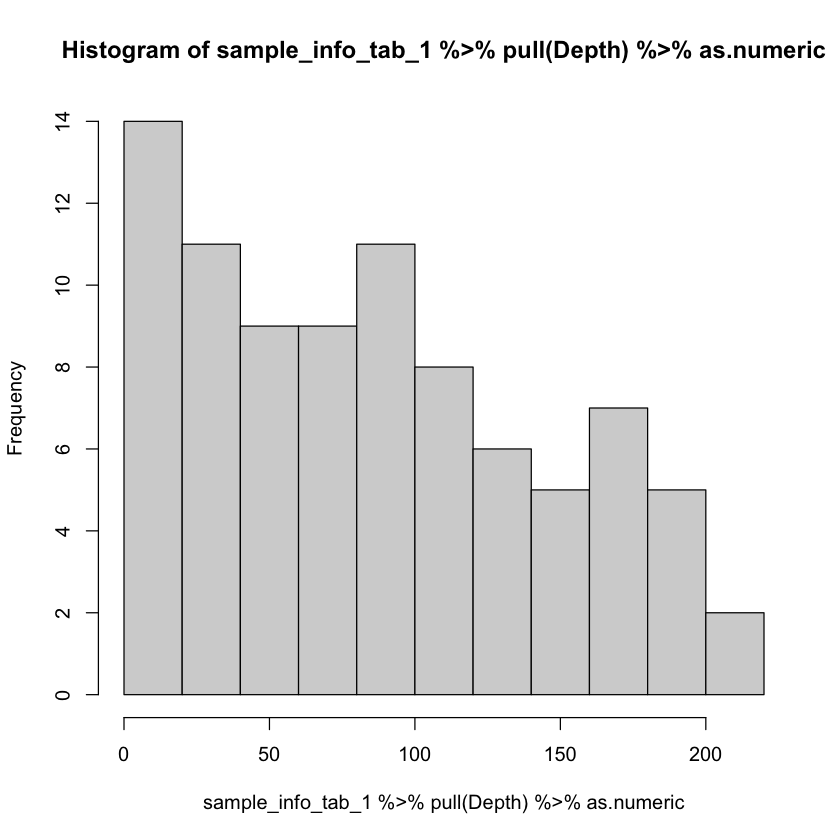

In [71]:
hist(sample_info_tab_1 %>% pull(Depth) %>% as.numeric)

We’ll make 4 bins for depth: 0-20, 21-50, 51-100, and 101-220. We will get 4 colors we can use:

In [73]:
# first let's get 4 color codes we can use
four_colors <-brewer.pal(4, "Dark2")
four_colors

[1] "#1B9E77" "#D95F02" "#7570B3" "#E7298A"

In [74]:
# reminding what the values are
sample_info_tab_1 %>% pull(Core) %>% unique()

[1] "GC06" "GC04" "GC02" "MC01"

Now we're going to loop through the values in the core column and set the color value based on the core:

In [76]:
# making an empty vector for the core colors
core_colors <- c()

for ( entry in sample_info_tab_1 %>% pull(Core)) {
  
  if ( entry == "MC01" ) {
    
    core_colors <- c(core_colors, four_colors[1])
    
  } else if ( entry == "GC02" ) {
    
    core_colors <- c(core_colors, four_colors[2])
    
  } else if ( entry == "GC04" ) {
    
    core_colors <- c(core_colors, four_colors[3])
    
  } else {
    
    core_colors <- c(core_colors, four_colors[4])
  }
  
}

We will do something similar for depth, but also making a new column holding the group labels:

In [451]:
depth_colors <- c()
depth_bins <- c()

for (entry in sample_info_tab_1 %>% pull(Depth)) {
  
  if (as.numeric(entry) %>% between(0,20)) {
    
    depth_colors <- c(depth_colors, four_colors[1])
    depth_bins <- c(depth_bins, "0-20")
    
  } else if (as.numeric(entry) %>% between(21,60.9)) {
    
    depth_colors <- c(depth_colors, four_colors[2])
    depth_bins <- c(depth_bins, "21-60")
    
  } else if (as.numeric(entry) %>% between(61,140)) {
    
    depth_colors <- c(depth_colors, four_colors[3])
    depth_bins <- c(depth_bins, "61-140")
    
  } else {
    
    depth_colors <- c(depth_colors, four_colors[4])
    depth_bins <- c(depth_bins, "141-220")
    
  }
  
}

And now we can add those color columns to the table with the sample information:

In [452]:
sample_info_tab_1$core_colors <- core_colors
sample_info_tab_1$depth_colors <- depth_colors
sample_info_tab_1$Depth_bin <- depth_bins

head(sample_info_tab_1)

Sample           Core Depth core_colors Depth_bin depth_colors
1 DO-01_GC06_126   GC06 126   #E7298A     61-140    #7570B3     
2 DO-101_GC04_136  GC04 136   #7570B3     61-140    #7570B3     
3 DO-102_GC06_111  GC06 111   #E7298A     61-140    #7570B3     
4 DO-105_GC04_26   GC04 26    #7570B3     21-60     #D95F02     
5 DO-107_GC02_15.5 GC02 15.5  #D95F02     0-20      #1B9E77     
6 DO-10_GC06_81    GC06 81    #E7298A     61-140    #7570B3

### Beta diversity

The first step to visualize the Euclidean distances between samples will be a normalization by sampling depth, implementing a variance stabilizing transformation with DESeq2.

In [ ]:
# First we need to make a DESeq2 data object
deseq_counts <- DESeqDataSetFromMatrix(counts_tab, 
                                       data.frame(samples=colnames(counts_tab)), 
                                       design=~samples)

deseq_counts <- estimateSizeFactors(deseq_counts, type = "poscounts")

In [454]:
#Now we will implement the transformation
deseq_counts_vst <- varianceStabilizingTransformation(deseq_counts)
# And here is how we can pull out our transformed table
vst_trans_count_tab <- assay(deseq_counts_vst)
#We will implement a correction for negative values
vst_non_neg <- vst_trans_count_tab
vst_non_neg[vst_non_neg<0] <- 0
head(vst_non_neg)

DO-101_GC04_136 DO-102_GC06_111 DO-10_GC06_81 DO-110_GC06_156
ASV_5  0.000000        0.000000        0.000000      0              
ASV_6  5.361861        0.000000        4.234921      0              
ASV_7  0.000000        7.336638        3.235735      0              
ASV_8  5.963837        2.566546        0.000000      0              
ASV_9  7.579849        0.000000        1.654025      0              
ASV_11 6.131630        4.301698        4.457197      0              
       DO-113_GC04_156 DO-114_GC06_166 DO-115_GC06_171 DO-116_GC06_146
ASV_5  0               0.000000        0.000000        0.000000       
ASV_6  0               3.146897        4.920791        3.414408       
ASV_7  0               6.551319        8.371542        6.113630       
ASV_8  0               6.973105        0.000000        0.000000       
ASV_9  0               0.000000        7.312698        0.000000       
ASV_11 0               6.467265        0.000000        2.999851       
       DO-11_GC06_71 DO-12_GC06_121 ... DO-68_GC04_51 DO-69_GC04_46
ASV_5  0.2830526     0.000000       ... 0.000000      0.000000     
ASV_6  3.9718267     0.000000       ... 5.403446      0.000000     
ASV_7  7.8479038     7.803238       ... 0.000000      1.407268     
ASV_8  0.0000000     0.000000       ... 4.554624      0.000000     
ASV_9  0.0000000     0.000000       ... 0.000000      0.000000     
ASV_11 3.4417465     0.000000       ... 0.000000      4.402200     
       DO-71_GC04_61 DO-78_GC02_9.5 DO-79_GC04_66 DO-84_GC04_11 DO-85_GC04_126
ASV_5  0             1.394850       0.0000000     4.959557      0.000000      
ASV_6  0             1.394850       0.0000000     5.213661      2.828542      
ASV_7  0             5.637242       6.8748974     0.000000      0.000000      
ASV_8  0             0.000000       0.0000000     6.894912      0.000000      
ASV_9  0             0.000000       6.3819107     0.000000      0.000000      
ASV_11 0             3.390470       0.6367296     7.112831      4.412063      
       DO-87_GC02_12.5 DO-93_GC04_31 DO-98_GC04_116
ASV_5  0.000000        0.000000      0.000000      
ASV_6  0.000000        0.000000      4.524342      
ASV_7  7.774549        2.963469      4.283455      
ASV_8  0.000000        0.000000      3.631829      
ASV_9  0.000000        0.000000      0.000000      
ASV_11 0.000000        4.769418      4.408920

In [455]:
#We will export the table for NMDS analysis
write.table(vst_non_neg, "ASVs-counts_norm.tsv", sep = "\t", quote = FALSE, col.names = NA)

### Hierarchical clustering

We are going to turn the normalized table into a distance matrix, which will be the foundation of what we use for hierarchical clustering:

In [88]:
# the dist() program works on rows, so first we will transpose the table with the t() function
euc_dist <- dist(t(vst_non_neg))

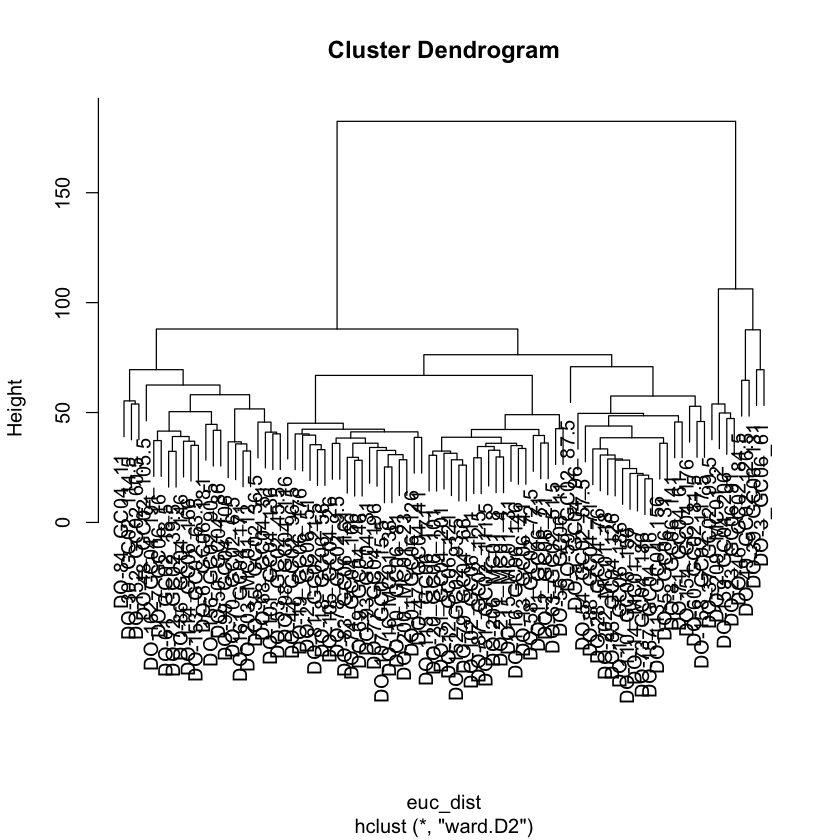

In [91]:
# hclust() is the function we will use to cluster the distance matrix
euc_clust <- hclust(euc_dist, method="ward.D2")
#now we can visualize the sequence dendrogram
plot(euc_clust)

We will transform it to a dendrogram so that we can rotate it and color it:

In [121]:
# Making one for core and depth to we color both ways
core_euc_dend <- as.dendrogram(euc_clust, hang = 0.1)
depth_euc_dend <- as.dendrogram(euc_clust, hang = 0.1)

# this line is getting a vector of colors in the order the sample names are in the dendrogram
core_dend_colors <- as.character(sample_info_tab_1$core_color[order.dendrogram(core_euc_dend)])

# Now doing the same for depth
depth_dend_colors <- as.character(sample_info_tab_1$depth_color[order.dendrogram(depth_euc_dend)])

# Coloring the labels in the dendrogram objects for each
labels_colors(core_euc_dend) <- core_dend_colors
labels_colors(depth_euc_dend) <- depth_dend_colors



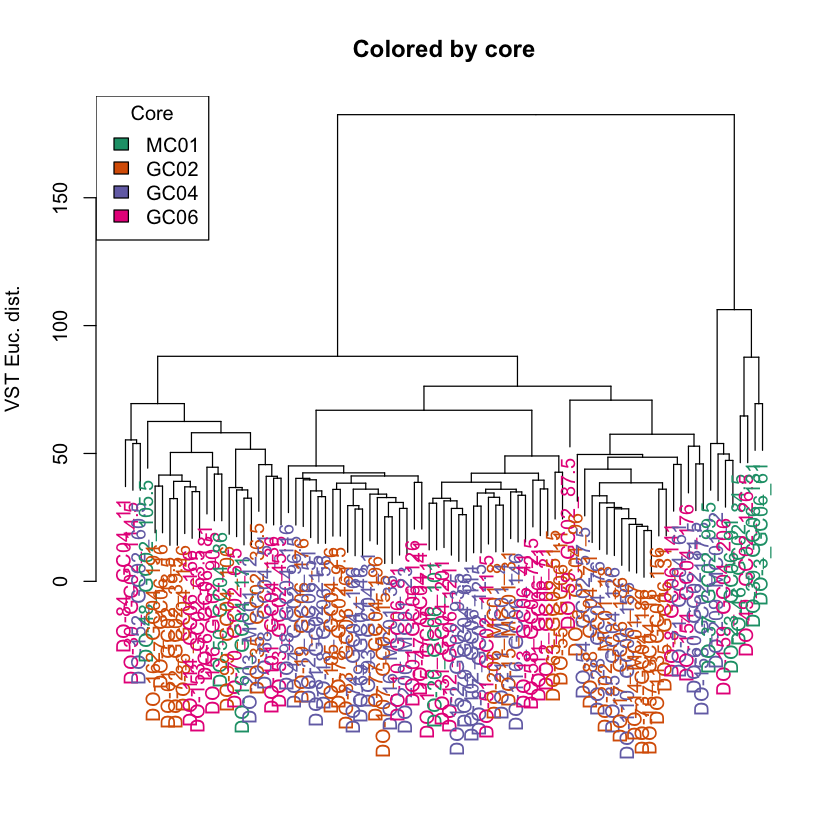

In [190]:
# Now here's plotting the one colored by core
# Adjusting margins so the labels are cut off from the bottom
par(mar = c(10, 4, 4, 2))
plot(core_euc_dend, ylab="VST Euc. dist.", main = "Colored by core")
# Adding a legend
legend("topleft", legend = c("MC01", "GC02", "GC04", "GC06"), fill = four_colors,
       pt.cex = 0.5, title = "Core")

As we can see, the core is not a very good separator for the sequences. We will now visualize the dendrogram colored by depth:

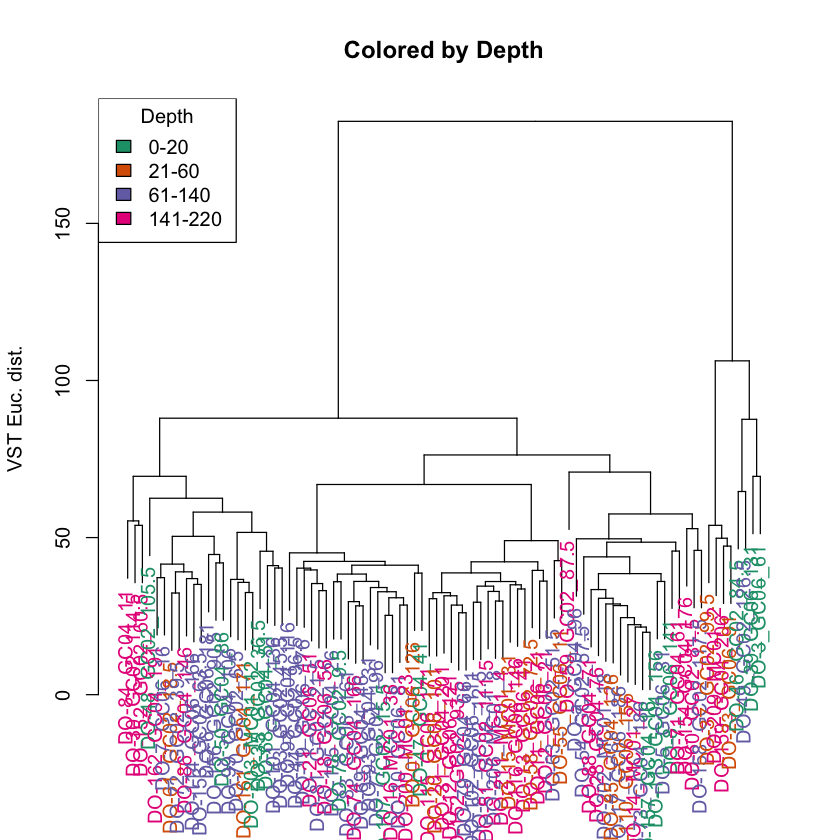

In [123]:
plot(depth_euc_dend, ylab="VST Euc. dist.", main = "Colored by Depth")
# adding a legend
legend("topleft", legend = c("0-20", "21-60", "61-140","141-220"), fill = four_colors,
       pt.cex = 0.5, title = "Depth")


The dendrogram above shows that depth is not a good separating variable for the sequences either.

In [152]:
# setting margins back to the default
# we can find that info in ?par
par(mar = c(5, 4, 4, 2))

### Ordination

#### Multidimensional analysis (MDA)

We will create the distance matrix for the non-linear dimensionality reduction.

In [ ]:
makeMDSbyLevel <- function(counts=vst_non_neg, 
                           tax=tax_tab, 
                           level='ASV', 
                           distance='bray', 
                           try=100, 
                           trymax=500) 
{
  counts <- cbind(tax[rownames(counts),], counts)
  counts <- dcast(melt(counts, variable.name='sample'), 
                  sample~get(level), 
                  value.var = 'value', 
                  fun.aggregate = sum)
  rownames(counts) <- counts$sample
  
  mds <- metaMDS(counts[,2:ncol(counts)], distance = distance, try = try, trymax = trymax)
  return(mds)
}

mds <- makeMDSbyLevel(counts=vst_non_neg, level='genus',try=100, trymax=200)

# Here we will merge the sample metadata onto the mds table to use for coloring points
mds_plot <- data.frame(mds$points)
mds_plot$sample <- rownames(mds_plot)

Now we will add other necessary columns for plotting:

In [136]:
#Creating GC and Depth columns in the mds dataframe
mds_plot <- data.frame(mds_plot,do.call(rbind,str_split(mds_plot$sample,"_")))
mds_plot$X1 <- NULL
colnames(mds_plot)[colnames(mds_plot) == 'X2'] <- 'Core'
colnames(mds_plot)[colnames(mds_plot) == 'X3'] <- 'Depth'
#And now we can add those color columns to our mds dataframe:
mds_plot$Depth_bin <- depth_bins
#Define a 4 color colorblind palette
cbbPalette <- c("#009E73", "#0072B2", "#D55E00", "#CC79A7")

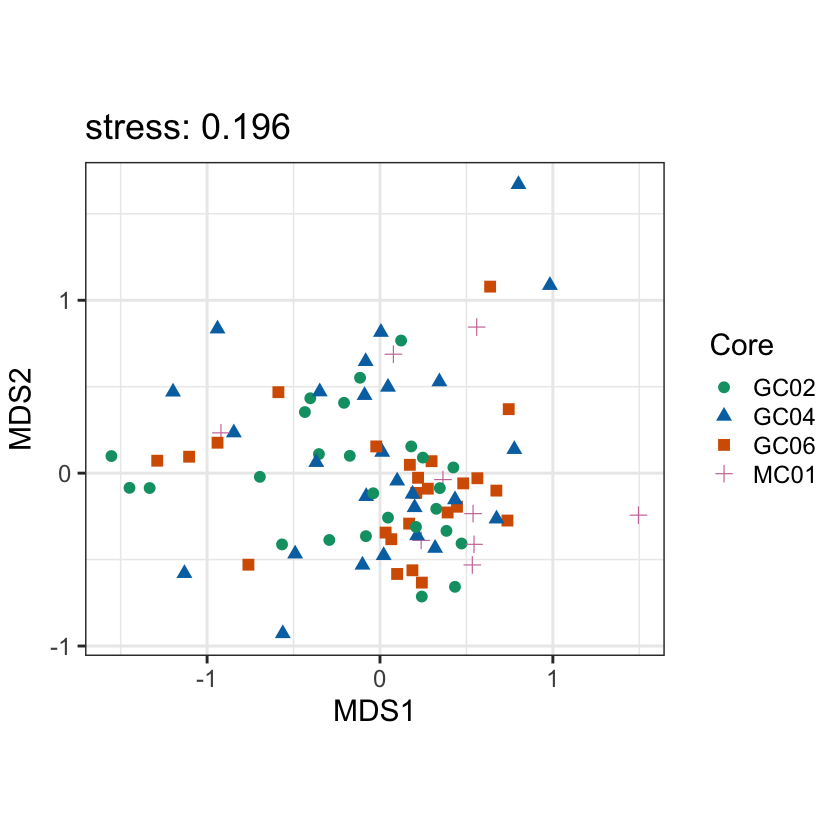

In [161]:
#Make plot coloured by core
ggplot(mds_plot, aes(x=MDS1, y=MDS2, color = Core)) + 
  scale_colour_manual(values=cbbPalette) +
  geom_point(aes(shape=Core), size=3) + ggtitle(paste0('stress: ', round(mds$stress,3))) +
#The following line adds labels
  #ggrepel::geom_text_repel(aes(label=sample)) +  
  coord_equal() + theme_bw(base_size = 18) 

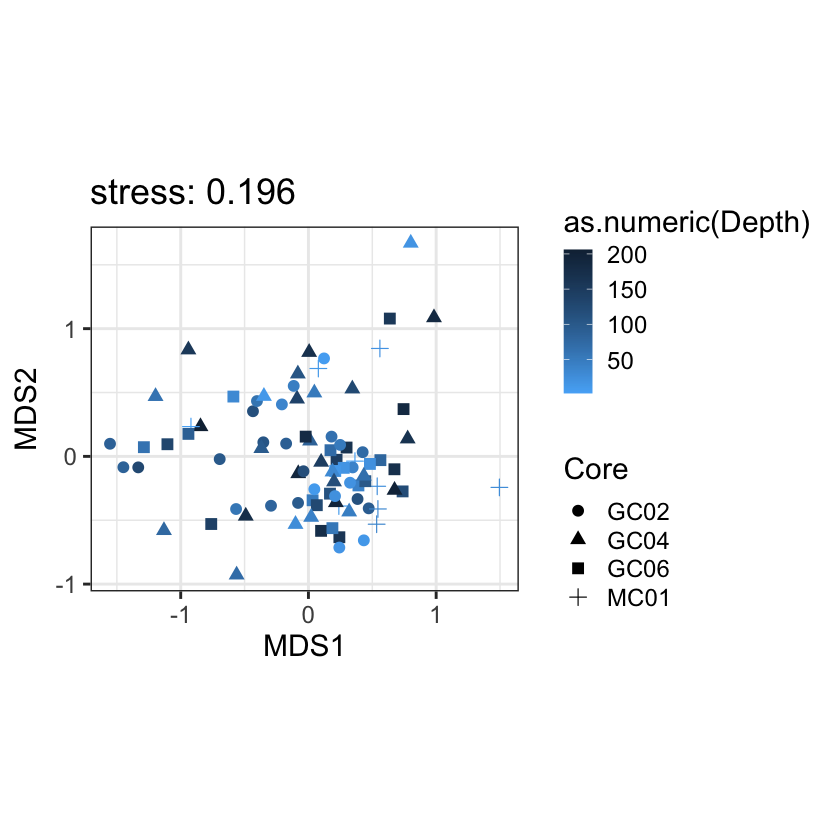

In [170]:
#Make plot coloured by depth with different markers for each core
ggplot(mds_plot, aes(x=MDS1, y=MDS2, color = as.numeric(Depth))) + 
  scale_colour_gradient(high = "#132B43", low = "#56B1F7") +
  geom_point(aes(shape=Core),size=3) + ggtitle(paste0('stress: ', round(mds$stress,3))) +
  #ggrepel::geom_text_repel(aes(label=sample)) +  # if a lot of samples, comment this off
  coord_equal() + theme_bw(base_size = 18)

#### Principal component analysis

To make and visualize a principal component analysis of the sequences, we will start by making a phyloseq object.

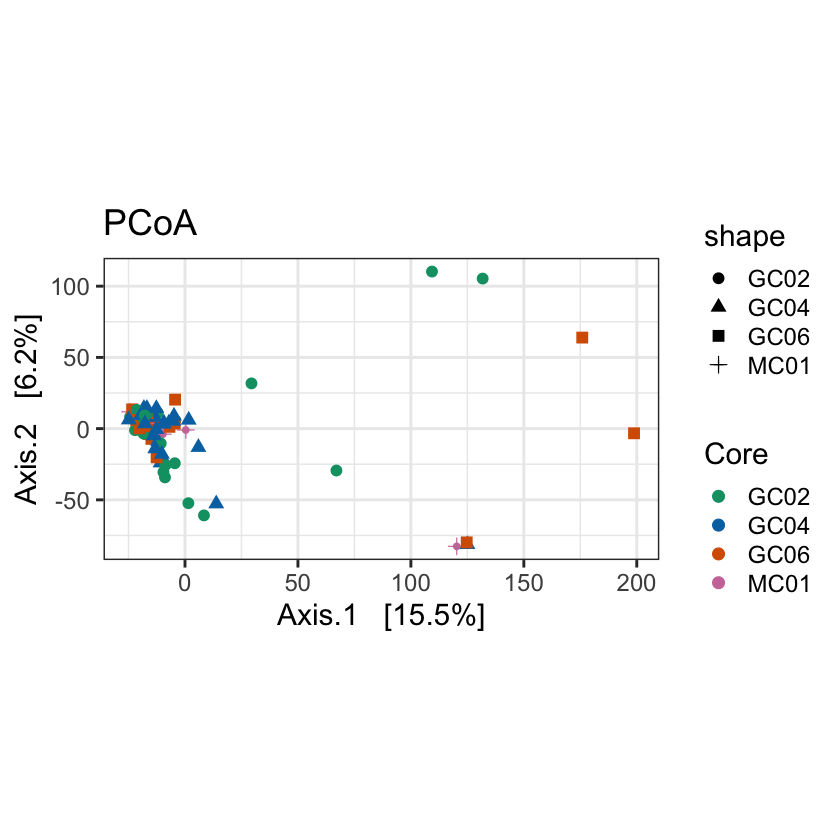

In [183]:
# making our phyloseq object with transformed table
vst_count_phy <- otu_table(vst_trans_count_tab, taxa_are_rows = TRUE)

# phyloseq expects our sample ID to be the row names in the sample_info_tab we give it,
# so here we make that change and specify input table
sample_info_tab_phy <- sample_data(sample_info_tab_1 %>% column_to_rownames("Sample"))
vst_physeq <- phyloseq(vst_count_phy, sample_info_tab_phy)

# generating and visualizing the PCoA with phyloseq
vst_pcoa <- ordinate(vst_physeq, method="MDS", distance="euclidean")
eigen_vals <- vst_pcoa$values$Eigenvalues 
# pulling these out helps us to scale the axes according to their 
# magnitude of separating apart the samples

# Plot colored by core
plot_ordination(vst_physeq, vst_pcoa, color = "Core") + 
  geom_point(aes(shape=Core), size=3) + 
  #Uncomment the next line to add labels  
  #geom_text_repel(label = sample_info_tab_1$Sample) + 
  scale_colour_manual(values=cbbPalette) +
  coord_fixed(sqrt(eigen_vals[2] / eigen_vals[1])) + ggtitle("PCoA") + 
  #scale_color_manual(values = unique(sample_info_tab_1$core_colors[order(sample_info_tab_1$Core)])) + 
  theme_bw(base_size = 18) 

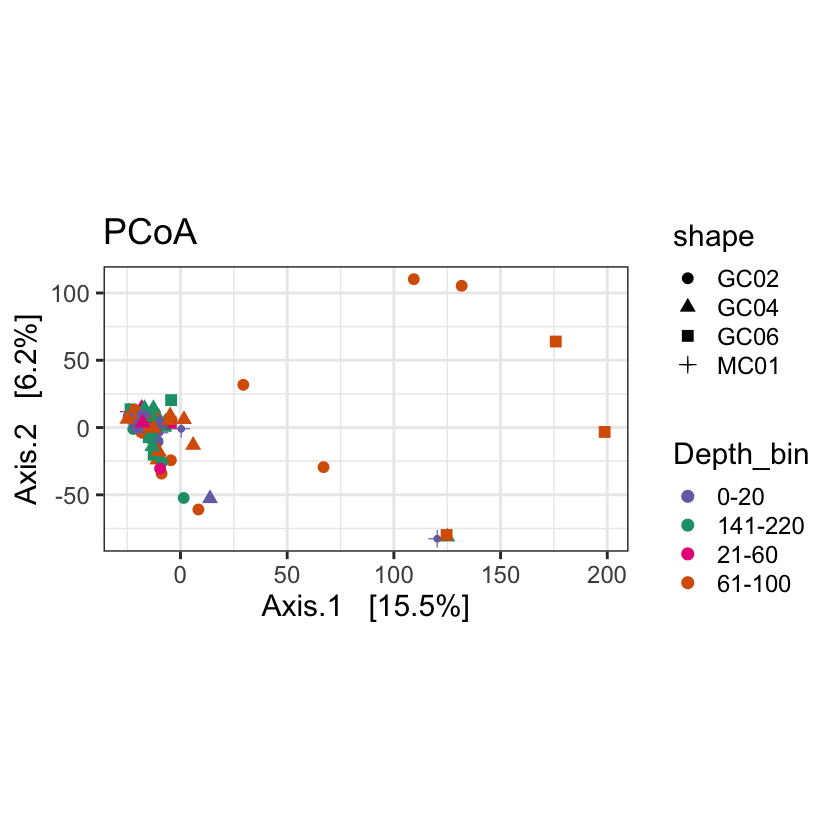

In [181]:
# Plot colored by core and depth
plot_ordination(vst_physeq, vst_pcoa, color = "Depth_bin") + 
  geom_point(aes(shape=Core), size=3) + 
  coord_fixed(sqrt(eigen_vals[2] / eigen_vals[1])) + ggtitle("PCoA") + 
  scale_color_manual(values = unique(sample_info_tab_1$depth_colors[order(sample_info_tab_1$Depth)])) + 
  theme_bw(base_size = 18)

### Alpha diversity

We will build rarefaction curves to get an overview of the diversity of sequences. 

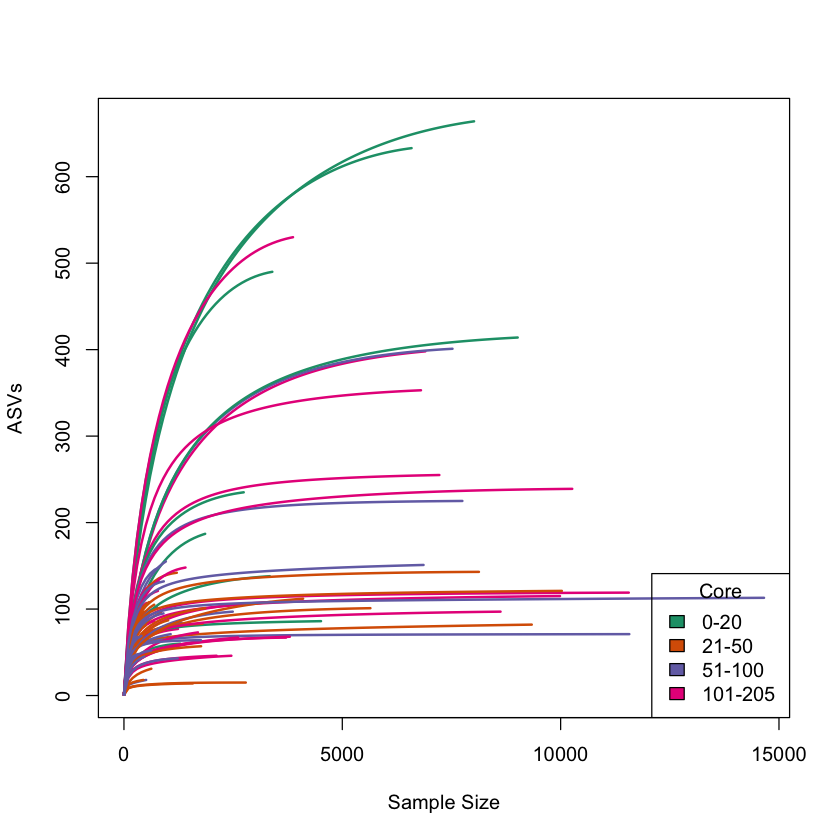

In [186]:
# colored by core
rarecurve(t(counts_tab), step = 100, col = sample_info_tab_1$core_color, lwd = 2, ylab = "ASVs", label = FALSE)
# adding a legend
legend("topleft", legend = c("MC01", "GC02", "GC04", "GC06"), fill = four_colors,
       pt.cex = 0.5, title = "Core")

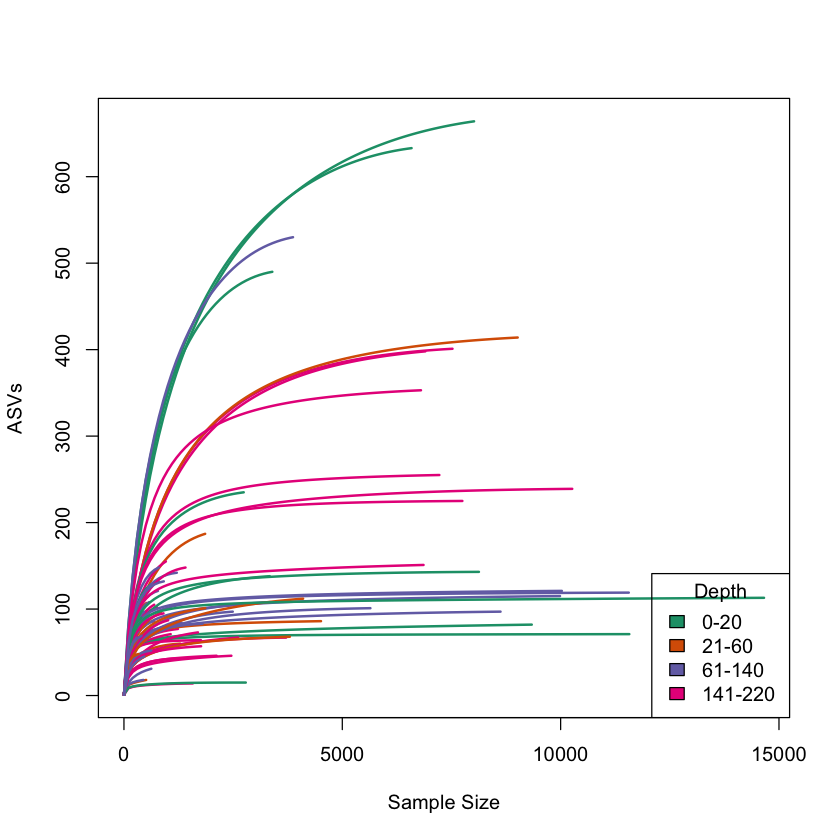

In [187]:
# colored by depth
rarecurve(t(counts_tab), step = 100, col = sample_info_tab_1$depth_color, lwd = 2, ylab = "ASVs", label = FALSE)
# adding a legend
legend("bottomright", legend = c("0-20", "21-60", "61-140","141-220"), fill = four_colors,
       pt.cex = 0.5, title = "Depth")

### Richness and diversity estimates

Here we are going to plot Chao1 richness estimates and Shannon diversity values.

In [192]:
# First, we need to create a phyloseq object using our not-transformed count table
count_tab_phy <- otu_table(counts_tab, taxa_are_rows = TRUE)
tax_tab_phy <- tax_table(as.matrix(tax_tab))
data_x <- as.data.frame((tax_tab_phy))
unique(data_x$phylum)

ASV_physeq <- phyloseq(count_tab_phy, tax_tab_phy, sample_info_tab_phy)


[1] "Proteobacteria"                "Caldatribacteriota"           
 [3] "Actinobacteriota"              "Crenarchaeota"                
 [5] "unclassified_Root"             "Aerophobota"                  
 [7] "Firmicutes"                    "Asgardarchaeota"              
 [9] "Chloroflexi"                   "BHI80-139"                    
[11] "TA06"                          "Acidobacteriota"              
[13] "Planctomycetota"               "Cyanobacteria"                
[15] "Thermoplasmatota"              "Marinimicrobia (SAR406 clade)"
[17] "Halobacterota"                 "Elusimicrobiota"              
[19] "Patescibacteria"               "Desulfobacterota_1"           
[21] "Armatimonadota"                "Bdellovibrionota_2"           
[23] "Verrucomicrobiota"             "NKB15"                        
[25] "AncK6"                         "unclassified_Bacteria"        
[27] "WS1"                           "Bacteroidota"                 
[29] "Myxococcota"                   "WS2"                          
[31] "Spirochaetota"                 "Schekmanbacteria"             
[33] "Bdellovibrionota_1"            "Deinococcota"                 
[35] "Desulfobacterota_2"            "Nitrospirota"                 
[37] "Latescibacterota"              "Methylomirabilota"            
[39] "Zixibacteria"                  "Dependentiae"                 
[41] "Fibrobacterota"                "NB1-j"                        
[43] "Gemmatimonadota"               "Sumerlaeota"                  
[45] "Dadabacteria"                  "Nanoarchaeota"                
[47] "Calditrichota"                 "LCP-89"                       
[49] "Hadarchaeota"                  "DTB120"                       
[51] "SAR324 clade(Marine group B)"  "Aenigmarchaeota"              
[53] "Nitrospinota"                  "Altiarchaeota"                
[55] "PAUC34f"                       "CK-2C2-2"                     
[57] "unclassified_Archaea"          "Fusobacteriota"               
[59] "Hydrothermarchaeota"           "Entotheonellaeota"            
[61] "GN01"                          "MBNT15"                       
[63] "Iainarchaeota"                 "Sva0485"                      
[65] "Euryarchaeota"                 "Cloacimonadota"               
[67] "WOR-1"

Now, we will define functions from the microViz package that are useful for filtering.

In [193]:
# internal helper that get phyloseq sample_data as plain dataframe
# without changing invalid colnames (like microbiome::meta does)
# or losing rownames / sample_names (like data.frame() with defaults does)
samdatAsDataframe <- function(ps) {
  samdat <- phyloseq::sample_data(ps)
  df <- data.frame(samdat, check.names = FALSE)
  return(df)
}
# Function that filters phyloseq samples by sample_data variables
ps_filter <- function(ps,
                      ...,
                      .target = "sample_data",
                      .keep_all_taxa = FALSE) {
  if (!inherits(ps, "phyloseq")) {
    stop("ps must be a phyloseq object. It is of class: ", class(ps))
  }
  
  if (!identical(.target, "sample_data")) {
    stop("Only .target = 'sample_data', has been implemented so far.")
  }
  # TODO: see if it is useful to facilitate
  # filtering by variables in other phyloseq slots
  
  df <- samdatAsDataframe(ps)
  df <- dplyr::filter(df, ...)
  phyloseq::sample_data(ps) <- df
  
  # remove taxa that now have zero counts (or relative abundance)
  # across all remaining samples
  if (isFALSE(.keep_all_taxa)) ps <- tax_filter_zeros(ps)
  return(ps)
}

# helper function used here and in ps_join
# removes all taxa which sum to zero across all samples
# (phyloseq::taxa_sums(ps) == 0)
# provides helpful warning if otu_table contains negative values
tax_filter_zeros <- function(ps) {
  # remove taxa that now have zero counts (or relative abundance)
  # across all remaining samples
  if (any(phyloseq::otu_table(ps) < 0)) {
    warning(
      "Removing taxa whose abundance across filtered samples is equal to zero.",
      "\nThis may not result in the desired outcome, ",
      "as some values in the otu_table are negative.",
      "\nAvoid performing transformations, ",
      "e.g. clr, before using `ps_filter()`, or set .keep_all_taxa = TRUE "
    )
  }
  return(phyloseq::prune_taxa(taxa = phyloseq::taxa_sums(ps) != 0, x = ps))
}

In [194]:
#We'll filter the phyloseq object by core
ASV_physeq_mc01 <- ps_filter(ASV_physeq, Core == 'MC01')
ASV_physeq_gc02 <- ps_filter(ASV_physeq, Core == 'GC02')
ASV_physeq_gc04 <- ps_filter(ASV_physeq, Core == 'GC04')
ASV_physeq_gc06 <- ps_filter(ASV_physeq, Core == 'GC06')

And now we can call the plot_richness() function on our phyloseq object.

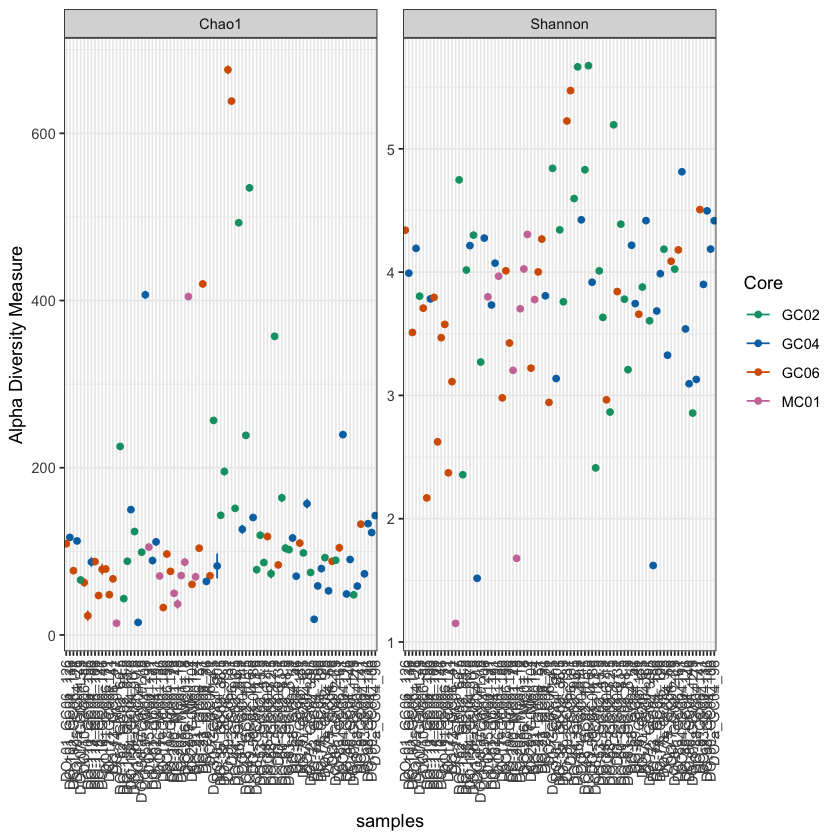

In [197]:
# Doing one based on Core
p<-plot_richness(ASV_physeq, color = "Core", measures = c("Chao1", "Shannon")) + 
  #scale_color_manual(values = unique(sample_info_tab_1$core_colors[order(sample_info_tab_1$Sample)])) +
  theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
p+scale_colour_manual(values=cbbPalette)
#Numbers on the left in the Chao1 plot=numbers of unique ASVs

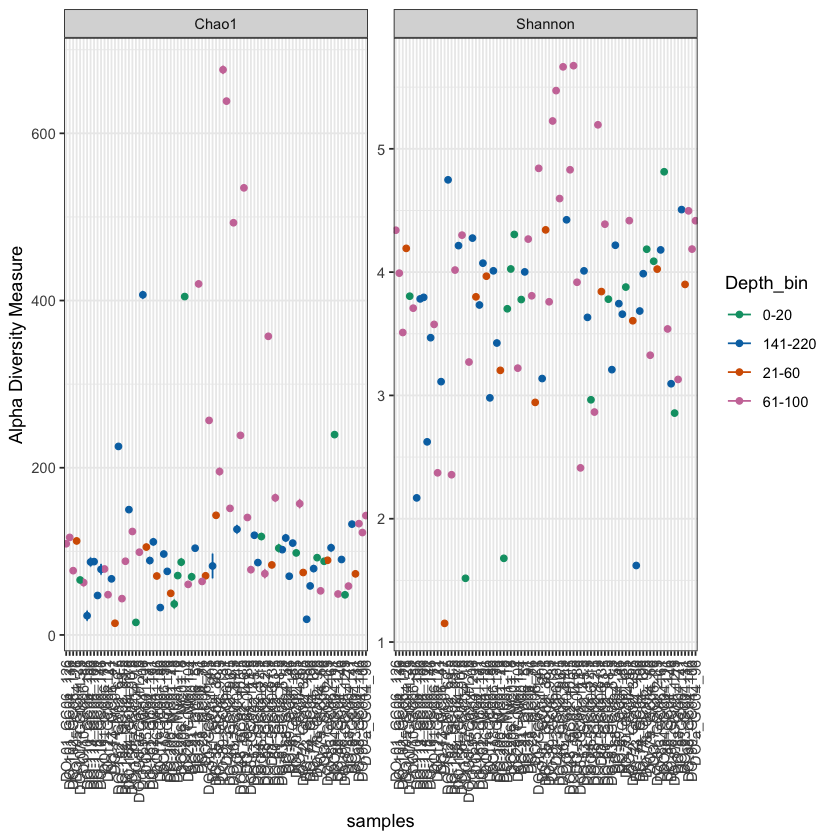

In [201]:
# And now one colored based on Depth
plot_richness(ASV_physeq, color = "Depth_bin", measures = c("Chao1", "Shannon")) + 
  #scale_color_manual(values = unique(sample_info_tab_1$depth_colors[order(sample_info_tab_1$Sample)])) +
  scale_colour_manual(values=cbbPalette) +
  theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

We can also easily group them with phyloseq.

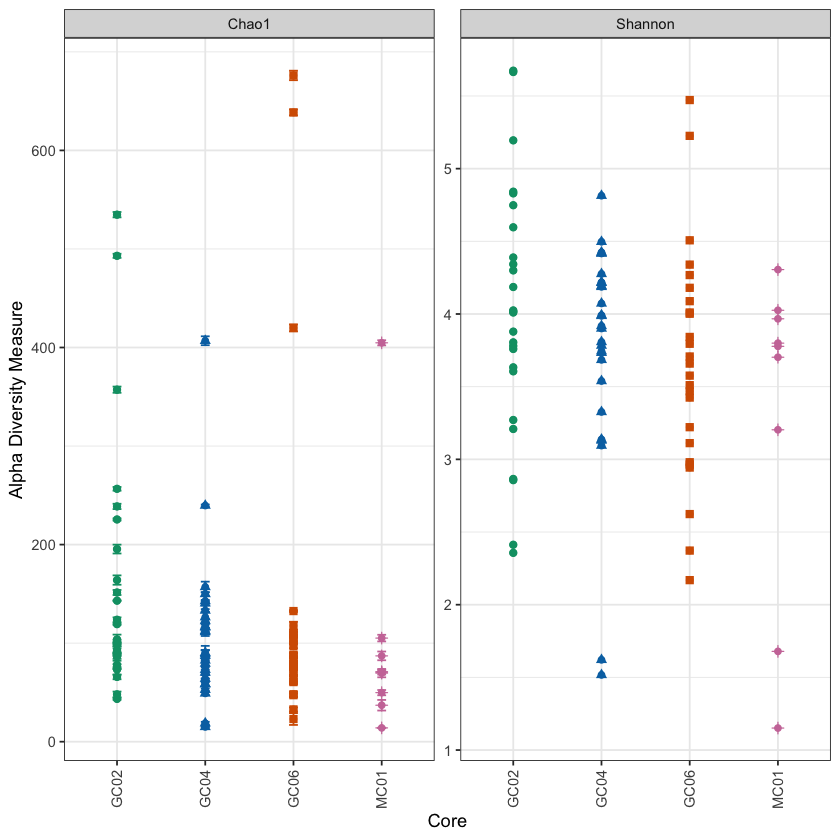

In [202]:
#Grouping by Core:
plot_richness(ASV_physeq, x = "Core", color = "Core", measures = c("Chao1", "Shannon")) + 
  scale_colour_manual(values=cbbPalette) +
  #scale_color_manual(values = unique(sample_info_tab$core_color[order(sample_info_tab$Sample)])) +
  geom_point(aes(shape=Core), size=2) +
  theme_bw() + theme(legend.position = "none", axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

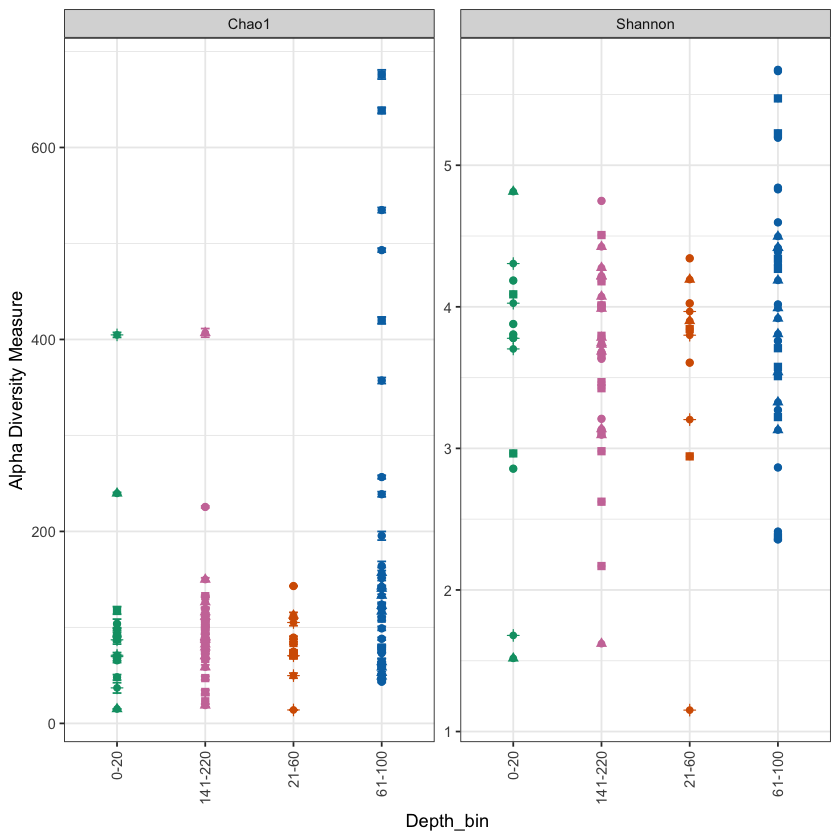

In [203]:
# And by depth
plot_richness(ASV_physeq, x = "Depth_bin", color = "depth_colors", measures = c("Chao1", "Shannon")) + 
  scale_colour_manual(values=cbbPalette) +
  #scale_color_manual(values = unique(sample_info_tab_1$depth_color[order(sample_info_tab_1$Sample)])) +
  geom_point(aes(shape=Core), size=2) +
  theme_bw() + theme(legend.position = "none", axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))


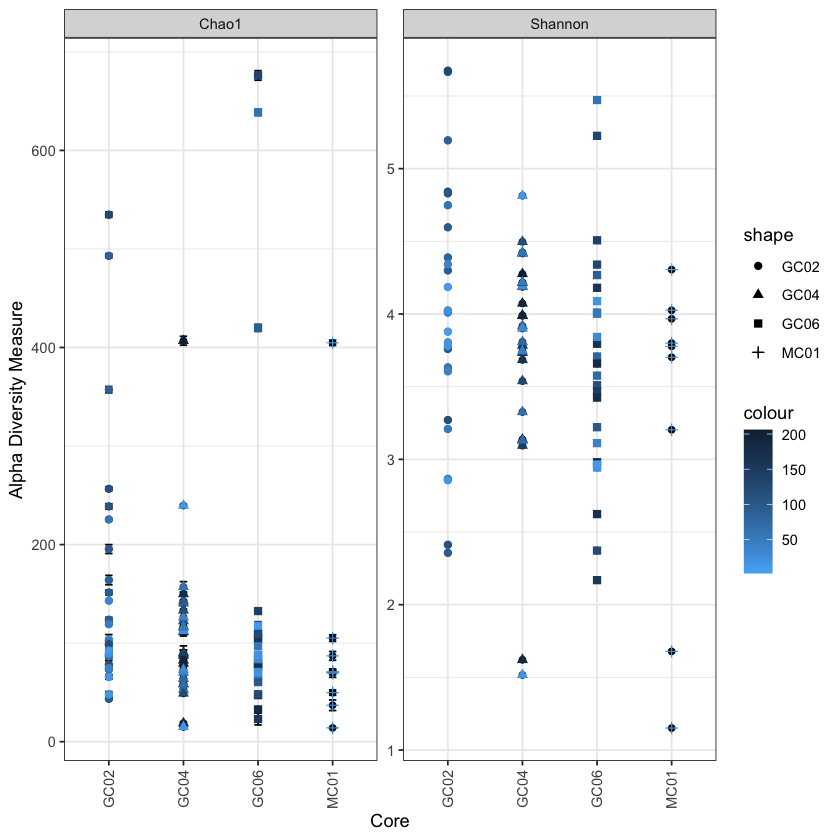

In [204]:
#Or by core and depth
plot_richness(ASV_physeq, x = "Core", measures = c("Chao1", "Shannon")) + 
  scale_colour_gradient(high = "#132B43", low = "#56B1F7") +
  #scale_color_manual(values = unique(sample_info_tab_1$core_color[order(sample_info_tab_1$Sample)])) +
  geom_point(aes(shape=Core, colour = as.numeric(Depth)), size=2) +
  theme_bw() + theme(legend.position = "right", axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))

Now, we will make a ridge plot based on Shannon diversity.

In [205]:
#First we will build the required dataframe
#We will start by getting diversity data
df_richness<-estimate_richness(ASV_physeq, split = TRUE, measures = NULL)
#We will add a column for samples 
df_richness$sample<-rownames(df_richness)
#Creating GC and Depth columns in the df_richness df
df_richness <- data.frame(df_richness,do.call(rbind,str_split(df_richness$sample,"_")))
df_richness$X1 <- NULL
colnames(df_richness)[colnames(df_richness) == 'X2'] <- 'Core'
colnames(df_richness)[colnames(df_richness) == 'X3'] <- 'Depth'
head(df_richness)

Observed Chao1     se.chao1 ACE       se.ACE   Shannon 
DO.101_GC04_136 115      116.66667 2.204730 117.61200 4.497167 3.991551
DO.102_GC06_111  73       76.88235 3.194336  81.10295 4.042235 3.510238
DO.10_GC06_81    56       62.66667 4.566424  67.63559 3.571545 3.707618
DO.110_GC06_156  18       23.00000 5.995923  24.95508 2.206068 2.168967
DO.113_GC04_156  82       87.25000 5.370987  87.99237 3.920805 3.782790
DO.114_GC06_166  86       87.71429 1.822376  90.88603 3.871376 3.795263
                Simpson   InvSimpson Fisher    sample          Core Depth
DO.101_GC04_136 0.9688977 32.151977  18.232364 DO.101_GC04_136 GC04 136  
DO.102_GC06_111 0.9439142 17.829812  21.482622 DO.102_GC06_111 GC06 111  
DO.10_GC06_81   0.9661388 29.532305  28.478108 DO.10_GC06_81   GC06 81   
DO.110_GC06_156 0.8604300  7.164862   3.639465 DO.110_GC06_156 GC06 156  
DO.113_GC04_156 0.9675563 30.822600  12.372295 DO.113_GC04_156 GC04 156  
DO.114_GC06_166 0.9620542 26.353371  25.912820 DO.114_GC06_166 GC06 166

Picking joint bandwidth of 0.303



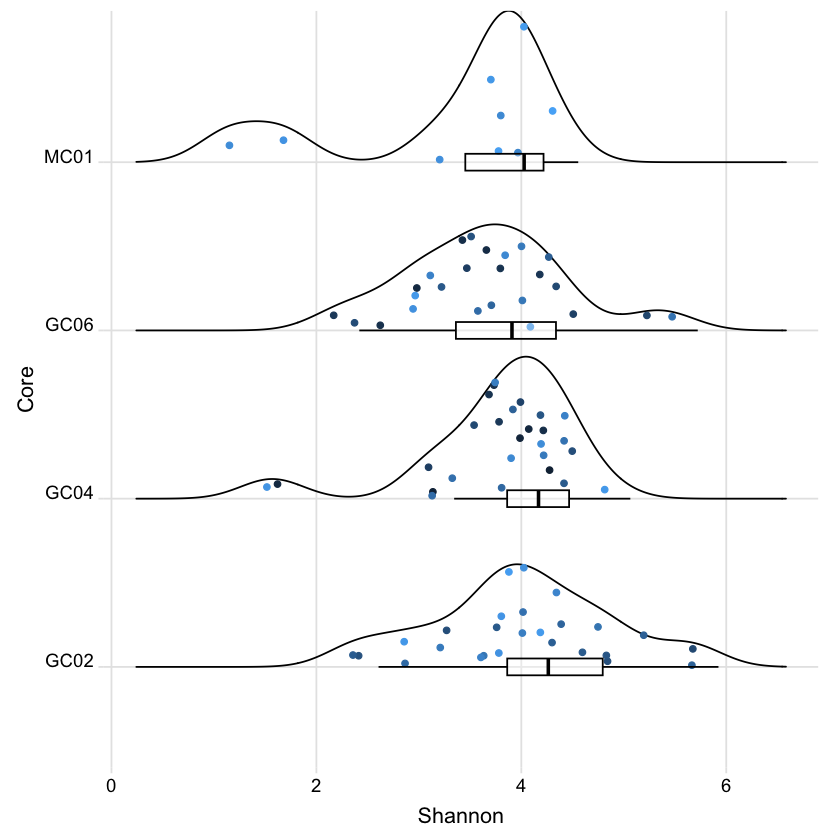

In [212]:
#Now we will make the ridge plot. 
# We will start by loading the required library.
library(ggridges)
#make plot
ggplot(df_richness, aes(x = Shannon, y = Core)) +
  #geom_density_ridges_gradient(scale = 0.7, rel_min_height = 0.005) +
  geom_density_ridges(
    aes(point_color = as.numeric(Depth), point_fill = as.numeric(Depth)),
    jittered_points = TRUE, alpha=0, point_alpha=1, scale = 0.9) +
  scale_point_colour_gradient(high = "#132B43", low = "#56B1F7")+
  geom_boxplot(aes(x = as.numeric(Shannon)+0.25, y = Core),outlier.shape = NA, alpha = 0.3, width = .1, colour = "BLACK") +
  #Uncomment the line below to add labels
  #geom_text(aes(label = Depth), vjust = -1, angle=45) + 
  theme_ridges(font_size = 13, line_size = 0.5, grid = TRUE, center_axis_labels = TRUE) 


### Taxonomic summaries

We will make different plots that will summarize the abundance of the ASVs identified in this study by core and depth for taxonomic clades where S utilizing organisms have been identified. The code to reproduce these plots for other groups of organisms can be found in the R script.W We will start by making a summary of all major taxa proportions across samples.

In [536]:
#To start, we need to parse the count matrix by taxonomy.
# Use phyloseq to make a count table that has summed all ASVs that were in the same phylum
phyla_counts_tab <- otu_table(tax_glom(ASV_physeq, taxrank = "phylum")) 
#for order
order_counts_tab <- otu_table(tax_glom(ASV_physeq, taxrank = "order"))
#for genus
genus_counts_tab <- otu_table(tax_glom(ASV_physeq, taxrank = "genus"))


In [537]:
#We'll filter the phyloseq object by core
ASV_physeq_mc01 <- ps_filter(ASV_physeq, Core == 'MC01')
ASV_physeq_gc02 <- ps_filter(ASV_physeq, Core == 'GC02')
ASV_physeq_gc04 <- ps_filter(ASV_physeq, Core == 'GC04')
ASV_physeq_gc06 <- ps_filter(ASV_physeq, Core == 'GC06')

In [539]:
#We'll create a table for each core
#For phylum
phyla_counts_tab_mc01 <- otu_table(tax_glom(ASV_physeq_mc01, taxrank = "phylum")) 
phyla_counts_tab_gc02 <- otu_table(tax_glom(ASV_physeq_gc02, taxrank = "phylum")) 
phyla_counts_tab_gc04 <- otu_table(tax_glom(ASV_physeq_gc04, taxrank = "phylum")) 
phyla_counts_tab_gc06 <- otu_table(tax_glom(ASV_physeq_gc06, taxrank = "phylum")) 
#For order
order_counts_tab_mc01 <- otu_table(tax_glom(ASV_physeq_mc01, taxrank = "order")) 
order_counts_tab_gc02 <- otu_table(tax_glom(ASV_physeq_gc02, taxrank = "order")) 
order_counts_tab_gc04 <- otu_table(tax_glom(ASV_physeq_gc04, taxrank = "order")) 
order_counts_tab_gc06 <- otu_table(tax_glom(ASV_physeq_gc06, taxrank = "order")) 
#For genus
genus_counts_tab_mc01 <- otu_table(tax_glom(ASV_physeq_mc01, taxrank = "genus")) 
genus_counts_tab_gc02 <- otu_table(tax_glom(ASV_physeq_gc02, taxrank = "genus")) 
genus_counts_tab_gc04 <- otu_table(tax_glom(ASV_physeq_gc04, taxrank = "genus")) 
genus_counts_tab_gc06 <- otu_table(tax_glom(ASV_physeq_gc06, taxrank = "genus"))

The step above kept some representative sequence headers as the row names though. Now we will replace those names.


In [540]:
# Make a vector of phyla names to set as row names next
#For phylum
phyla_tax_vec <- as.vector(tax_table(tax_glom(ASV_physeq, taxrank = "phylum"))[,"phylum"])
#For order
order_tax_vec <- as.vector(tax_table(tax_glom(ASV_physeq, taxrank = "order"))[,"order"])
#For genus
genus_tax_vec <- as.vector(tax_table(tax_glom(ASV_physeq, taxrank = "genus"))[,"genus"])
#Same for each core
#for phylum
phyla_tax_vec_mc01 <- as.vector(tax_table(tax_glom(ASV_physeq_mc01, taxrank = "phylum"))[,"phylum"])
phyla_tax_vec_gc02 <- as.vector(tax_table(tax_glom(ASV_physeq_gc02, taxrank = "phylum"))[,"phylum"])
phyla_tax_vec_gc04 <- as.vector(tax_table(tax_glom(ASV_physeq_gc04, taxrank = "phylum"))[,"phylum"])
phyla_tax_vec_gc06 <- as.vector(tax_table(tax_glom(ASV_physeq_gc06, taxrank = "phylum"))[,"phylum"])
#phyla_tax_vec_gcnone <- as.vector(tax_table(tax_glom(ASV_physeq_gcnone, taxrank = "phylum"))[,"phylum"])
#for order
order_tax_vec_mc01 <- as.vector(tax_table(tax_glom(ASV_physeq_mc01, taxrank = "order"))[,"order"])
order_tax_vec_gc02 <- as.vector(tax_table(tax_glom(ASV_physeq_gc02, taxrank = "order"))[,"order"])
order_tax_vec_gc04 <- as.vector(tax_table(tax_glom(ASV_physeq_gc04, taxrank = "order"))[,"order"])
order_tax_vec_gc06 <- as.vector(tax_table(tax_glom(ASV_physeq_gc06, taxrank = "order"))[,"order"])
#family_tax_vec_gcnone <- as.vector(tax_table(tax_glom(ASV_physeq_gcnone, taxrank = "family"))[,"family"])

#For genus
genus_tax_vec_mc01 <- as.vector(tax_table(tax_glom(ASV_physeq_mc01, taxrank = "genus"))[,"genus"])
genus_tax_vec_gc02 <- as.vector(tax_table(tax_glom(ASV_physeq_gc02, taxrank = "genus"))[,"genus"])
genus_tax_vec_gc04 <- as.vector(tax_table(tax_glom(ASV_physeq_gc04, taxrank = "genus"))[,"genus"])
genus_tax_vec_gc06 <- as.vector(tax_table(tax_glom(ASV_physeq_gc06, taxrank = "genus"))[,"genus"])
#genus_tax_vec_gcnone <- as.vector(tax_table(tax_glom(ASV_physeq_gcnone, taxrank = "genus"))[,"genus"])

In [542]:
#Replace row names in the general table
#for phyla
rownames(phyla_counts_tab) <- phyla_tax_vec
head(phyla_counts_tab[ ,1:5])
#for order
rownames(order_counts_tab) <- order_tax_vec

#for genus
rownames(genus_counts_tab) <- genus_tax_vec

#Replace row names in the table of each core
#For phylum
rownames(phyla_counts_tab_mc01) <- phyla_tax_vec_mc01
rownames(phyla_counts_tab_gc02) <- phyla_tax_vec_gc02
rownames(phyla_counts_tab_gc04) <- phyla_tax_vec_gc04
rownames(phyla_counts_tab_gc06) <- phyla_tax_vec_gc06
#For order
rownames(order_counts_tab_mc01) <- order_tax_vec_mc01
rownames(order_counts_tab_gc02) <- order_tax_vec_gc02
rownames(order_counts_tab_gc04) <- order_tax_vec_gc04
rownames(order_counts_tab_gc06) <- order_tax_vec_gc06
#For genus
rownames(genus_counts_tab_mc01) <- genus_tax_vec_mc01
rownames(genus_counts_tab_gc02) <- genus_tax_vec_gc02
rownames(genus_counts_tab_gc04) <- genus_tax_vec_gc04
rownames(genus_counts_tab_gc06) <- genus_tax_vec_gc06

#Rearrange columns in the tables in order of depth
#For phylum
phyla_counts_tab_gc02 <-phyla_counts_tab_gc02[,order(as.numeric(sapply(strsplit(colnames(phyla_counts_tab_gc02), "_"), "[[", 3)))]
phyla_counts_tab_gc04 <-phyla_counts_tab_gc04[,order(as.numeric(sapply(strsplit(colnames(phyla_counts_tab_gc04), "_"), "[[", 3)))]
phyla_counts_tab_gc06 <-phyla_counts_tab_gc06[,order(as.numeric(sapply(strsplit(colnames(phyla_counts_tab_gc06), "_"), "[[", 3)))]
phyla_counts_tab_mc01 <-phyla_counts_tab_mc01[,order(as.numeric(sapply(strsplit(colnames(phyla_counts_tab_mc01), "_"), "[[", 3)))]

#For order
order_counts_tab_gc02 <-order_counts_tab_gc02[,order(as.numeric(sapply(strsplit(colnames(order_counts_tab_gc02), "_"), "[[", 3)))]
order_counts_tab_gc04 <-order_counts_tab_gc04[,order(as.numeric(sapply(strsplit(colnames(order_counts_tab_gc04), "_"), "[[", 3)))]
order_counts_tab_gc06 <-order_counts_tab_gc06[,order(as.numeric(sapply(strsplit(colnames(order_counts_tab_gc06), "_"), "[[", 3)))]
order_counts_tab_mc01 <-order_counts_tab_mc01[,order(as.numeric(sapply(strsplit(colnames(order_counts_tab_mc01), "_"), "[[", 3)))]

#For genus
genus_counts_tab_gc02 <-genus_counts_tab_gc02[,order(as.numeric(sapply(strsplit(colnames(genus_counts_tab_gc02), "_"), "[[", 3)))]
genus_counts_tab_gc04 <-genus_counts_tab_gc04[,order(as.numeric(sapply(strsplit(colnames(genus_counts_tab_gc04), "_"), "[[", 3)))]
genus_counts_tab_gc06 <-genus_counts_tab_gc06[,order(as.numeric(sapply(strsplit(colnames(genus_counts_tab_gc06), "_"), "[[", 3)))]
genus_counts_tab_mc01 <-genus_counts_tab_mc01[,order(as.numeric(sapply(strsplit(colnames(genus_counts_tab_mc01), "_"), "[[", 3)))]

DO-101_GC04_136 DO-102_GC06_111 DO-10_GC06_81
Proteobacteria      155             21              2           
Caldatribacteriota 2213             22             14           
Actinobacteriota    126            170             11           
Crenarchaeota      2205              0              6           
Aerophobota        1177             26              6           
Firmicutes            2            155             45           
                   DO-110_GC06_156 DO-113_GC04_156
Proteobacteria     153             704            
Caldatribacteriota   0               6            
Actinobacteriota     0             281            
Crenarchaeota        0             976            
Aerophobota        104             294            
Firmicutes           0               0

We will build count tables for the ASVs at each core for different taxonomic levels.

In [461]:
#Make count tables for each core
counts_tab_mc01 <- counts_tab[,grepl("MC01", names(counts_tab))]
counts_tab_gc02 <- counts_tab[,grepl("GC02", names(counts_tab))]
counts_tab_gc04 <- counts_tab[,grepl("GC04", names(counts_tab))]
counts_tab_gc06 <- counts_tab[,grepl("GC06", names(counts_tab))]

#Rearrange columns in the count tables in order of depth
counts_tab_gc02 <-counts_tab_gc02[,order(as.numeric(sapply(strsplit(colnames(counts_tab_gc02), "_"), "[[", 3)))]
counts_tab_gc04 <-counts_tab_gc04[,order(as.numeric(sapply(strsplit(colnames(counts_tab_gc04), "_"), "[[", 3)))]
counts_tab_gc06 <-counts_tab_gc06[,order(as.numeric(sapply(strsplit(colnames(counts_tab_gc06), "_"), "[[", 3)))]
counts_tab_mc01 <-counts_tab_mc01[,order(as.numeric(sapply(strsplit(colnames(counts_tab_mc01), "_"), "[[", 3)))]

#Rearrange columns in the tables in order of depth
#For phylum
phyla_counts_tab_gc02 <-phyla_counts_tab_gc02[,order(as.numeric(sapply(strsplit(colnames(phyla_counts_tab_gc02), "_"), "[[", 3)))]
phyla_counts_tab_gc04 <-phyla_counts_tab_gc04[,order(as.numeric(sapply(strsplit(colnames(phyla_counts_tab_gc04), "_"), "[[", 3)))]
phyla_counts_tab_gc06 <-phyla_counts_tab_gc06[,order(as.numeric(sapply(strsplit(colnames(phyla_counts_tab_gc06), "_"), "[[", 3)))]
phyla_counts_tab_mc01 <-phyla_counts_tab_mc01[,order(as.numeric(sapply(strsplit(colnames(phyla_counts_tab_mc01), "_"), "[[", 3)))]

#For order
order_counts_tab_gc02 <-order_counts_tab_gc02[,order(as.numeric(sapply(strsplit(colnames(order_counts_tab_gc02), "_"), "[[", 3)))]
order_counts_tab_gc04 <-order_counts_tab_gc04[,order(as.numeric(sapply(strsplit(colnames(order_counts_tab_gc04), "_"), "[[", 3)))]
order_counts_tab_gc06 <-order_counts_tab_gc06[,order(as.numeric(sapply(strsplit(colnames(order_counts_tab_gc06), "_"), "[[", 3)))]
order_counts_tab_mc01 <-order_counts_tab_mc01[,order(as.numeric(sapply(strsplit(colnames(order_counts_tab_mc01), "_"), "[[", 3)))]
colnames(order_counts_tab_mc01)

#For genus
genus_counts_tab_gc02 <-genus_counts_tab_gc02[,order(as.numeric(sapply(strsplit(colnames(genus_counts_tab_gc02), "_"), "[[", 3)))]
genus_counts_tab_gc04 <-genus_counts_tab_gc04[,order(as.numeric(sapply(strsplit(colnames(genus_counts_tab_gc04), "_"), "[[", 3)))]
genus_counts_tab_gc06 <-genus_counts_tab_gc06[,order(as.numeric(sapply(strsplit(colnames(genus_counts_tab_gc06), "_"), "[[", 3)))]
genus_counts_tab_mc01 <-genus_counts_tab_mc01[,order(as.numeric(sapply(strsplit(colnames(genus_counts_tab_mc01), "_"), "[[", 3)))]

Now, we will determine which sequences were not assigned any taxonomy at different taxonomic levels and classify them.

In [ ]:
#Account for sequences that were not assigned any taxonomy at the phylum level
#For phylum
unclassified_tax_counts <- colSums(counts_tab) - colSums(phyla_counts_tab)
#For order
unclassified_tax_counts_o <- colSums(counts_tab) - colSums(order_counts_tab)
#For genus
unclassified_tax_counts_g <- colSums(counts_tab) - colSums(genus_counts_tab)

# Add the unclassifieds as a row to the phylum count table:
#For phylum
phyla_and_unidentified_counts_tab <- rbind(phyla_counts_tab, "Unclassified" = unclassified_tax_counts)
#For order
order_and_unidentified_counts_tab <- rbind(order_counts_tab, "Unclassified" = unclassified_tax_counts_o)
#For genus
genus_and_unidentified_counts_tab <- rbind(genus_counts_tab, "Unclassified" = unclassified_tax_counts_g)

In [464]:
#For each core
#Account for sequences that were not assigned any taxonomy at the phylum level
unclassified_tax_counts_mc01 <- colSums(counts_tab_mc01) - colSums(phyla_counts_tab_mc01)
unclassified_tax_counts_gc02 <- colSums(counts_tab_gc02) - colSums(phyla_counts_tab_gc02)
unclassified_tax_counts_gc04 <- colSums(counts_tab_gc04) - colSums(phyla_counts_tab_gc04)
unclassified_tax_counts_gc06 <- colSums(counts_tab_gc06) - colSums(phyla_counts_tab_gc06)

#Account for sequences that were not assigned any taxonomy at the order level
unclassified_tax_counts_o_mc01 <- colSums(counts_tab_mc01) - colSums(order_counts_tab_mc01)
unclassified_tax_counts_o_gc02 <- colSums(counts_tab_gc02) - colSums(order_counts_tab_gc02)
unclassified_tax_counts_o_gc04 <- colSums(counts_tab_gc04) - colSums(order_counts_tab_gc04)
unclassified_tax_counts_o_gc06 <- colSums(counts_tab_gc06) - colSums(order_counts_tab_gc06)

#Account for sequences that were not assigned any taxonomy at the genus level
unclassified_tax_counts_g_mc01 <- colSums(counts_tab_mc01) - colSums(genus_counts_tab_mc01)
unclassified_tax_counts_g_gc02 <- colSums(counts_tab_gc02) - colSums(genus_counts_tab_gc02)
unclassified_tax_counts_g_gc04 <- colSums(counts_tab_gc04) - colSums(genus_counts_tab_gc04)
unclassified_tax_counts_g_gc06 <- colSums(counts_tab_gc06) - colSums(genus_counts_tab_gc06)


In [465]:
# Add the unclassifieds as a row to the phylum count table:
phyla_and_unidentified_counts_tab_mc01 <- rbind(phyla_counts_tab_mc01, "Unclassified" = unclassified_tax_counts_mc01)
phyla_and_unidentified_counts_tab_gc02 <- rbind(phyla_counts_tab_gc02, "Unclassified" = unclassified_tax_counts_gc02)
phyla_and_unidentified_counts_tab_gc04 <- rbind(phyla_counts_tab_gc04, "Unclassified" = unclassified_tax_counts_gc04)
phyla_and_unidentified_counts_tab_gc06 <- rbind(phyla_counts_tab_gc06, "Unclassified" = unclassified_tax_counts_gc06)

# Add the unclassifieds as a row to the order count table:
order_and_unidentified_counts_tab_mc01 <- rbind(order_counts_tab_mc01, "Unclassified" = unclassified_tax_counts_o_mc01)
order_and_unidentified_counts_tab_gc02 <- rbind(order_counts_tab_gc02, "Unclassified" = unclassified_tax_counts_o_gc02)
order_and_unidentified_counts_tab_gc04 <- rbind(order_counts_tab_gc04, "Unclassified" = unclassified_tax_counts_o_gc04)
order_and_unidentified_counts_tab_gc06 <- rbind(order_counts_tab_gc06, "Unclassified" = unclassified_tax_counts_o_gc06)
# Add the unclassifieds as a row to the genus count table:
genus_and_unidentified_counts_tab_mc01 <- rbind(genus_counts_tab_mc01, "Unclassified" = unclassified_tax_counts_g_mc01)
genus_and_unidentified_counts_tab_gc02 <- rbind(genus_counts_tab_gc02, "Unclassified" = unclassified_tax_counts_g_gc02)
genus_and_unidentified_counts_tab_gc04 <- rbind(genus_counts_tab_gc04, "Unclassified" = unclassified_tax_counts_g_gc04)
genus_and_unidentified_counts_tab_gc06 <- rbind(genus_counts_tab_gc06, "Unclassified" = unclassified_tax_counts_g_gc06)


To check we didn't miss any other sequences somehow, we can compare the columnsums to see if they are the same. If "TRUE", we know nothing fell through the cracks

In [ ]:
#For phylum
identical(colSums(phyla_and_unidentified_counts_tab), colSums(counts_tab)) 
identical(colSums(phyla_and_unidentified_counts_tab_mc01), colSums(counts_tab_mc01)) 
identical(colSums(phyla_and_unidentified_counts_tab_gc02), colSums(counts_tab_gc02)) 
identical(colSums(phyla_and_unidentified_counts_tab_gc04), colSums(counts_tab_gc04)) 
identical(colSums(phyla_and_unidentified_counts_tab_gc06), colSums(counts_tab_gc06)) 
#For order
identical(colSums(order_and_unidentified_counts_tab), colSums(counts_tab)) 
identical(colSums(order_and_unidentified_counts_tab_mc01), colSums(counts_tab_mc01)) 
identical(colSums(order_and_unidentified_counts_tab_gc02), colSums(counts_tab_gc02)) 
identical(colSums(order_and_unidentified_counts_tab_gc04), colSums(counts_tab_gc04)) 
identical(colSums(order_and_unidentified_counts_tab_gc06), colSums(counts_tab_gc06)) 
#For genus
identical(colSums(genus_and_unidentified_counts_tab), colSums(counts_tab)) 
identical(colSums(genus_and_unidentified_counts_tab_mc01), colSums(counts_tab_mc01)) 
identical(colSums(genus_and_unidentified_counts_tab_gc02), colSums(counts_tab_gc02)) 
identical(colSums(genus_and_unidentified_counts_tab_gc04), colSums(counts_tab_gc04)) 
identical(colSums(genus_and_unidentified_counts_tab_gc06), colSums(counts_tab_gc06)) 

Now we'll generate a percent table for summarizing:

In [467]:
#For phylum
major_taxa_proportions_tab <- apply(phyla_and_unidentified_counts_tab, 2, function(x) x/sum(x)*100)
major_taxa_proportions_tab_mc01 <- apply(phyla_and_unidentified_counts_tab_mc01, 2, function(x) x/sum(x)*100)
major_taxa_proportions_tab_gc02 <- apply(phyla_and_unidentified_counts_tab_gc02, 2, function(x) x/sum(x)*100)
major_taxa_proportions_tab_gc04 <- apply(phyla_and_unidentified_counts_tab_gc04, 2, function(x) x/sum(x)*100)
major_taxa_proportions_tab_gc06 <- apply(phyla_and_unidentified_counts_tab_gc06, 2, function(x) x/sum(x)*100)
#major_taxa_proportions_tab_gcnone <- apply(phyla_and_unidentified_counts_tab_gcnone, 2, function(x) x/sum(x)*100)
head(major_taxa_proportions_tab_mc01)

DO-209_MC01_2 DO-211_MC01_4 DO-206_MC01_8 DO-203_MC01_12
Proteobacteria     55.4433072     0.6250       10.685484      5.582440     
Caldatribacteriota  3.5491160    11.8750        2.217742      2.618389     
Actinobacteriota    2.5920510     8.1250       14.919355      2.393709     
Crenarchaeota       6.7393327     6.8750        5.241935     14.474594     
TA06                0.0000000     0.0000        0.000000      0.000000     
Aerophobota         0.3190217    15.3125        3.427419     17.170757     
                   DO-202_MC01_18 DO-200_MC01_23 DO-14_MC01_27 DO-15_MC01_31
Proteobacteria     14.536741       4.2105263     4.251269       2.201933    
Caldatribacteriota  0.798722      38.5964912     8.629442       1.879699    
Actinobacteriota    1.757188      12.2807018     4.251269      22.932331    
Crenarchaeota      56.869010       0.0000000     0.000000       2.148228    
TA06                0.798722       0.0000000     0.000000       0.000000    
Aerophobota         0.000000       0.7017544     0.000000       6.283566    
                   DO-16_MC01_36
Proteobacteria     1.342282     
Caldatribacteriota 5.369128     
Actinobacteriota   9.060403     
Crenarchaeota      4.362416     
TA06               0.000000     
Aerophobota        0.000000

In [468]:
#For order
major_taxa_proportions_tab_o <- apply(order_and_unidentified_counts_tab, 2, function(x) x/sum(x)*100)
major_taxa_proportions_tab_o_mc01 <- apply(order_and_unidentified_counts_tab_mc01, 2, function(x) x/sum(x)*100)
major_taxa_proportions_tab_o_gc02 <- apply(order_and_unidentified_counts_tab_gc02, 2, function(x) x/sum(x)*100)
major_taxa_proportions_tab_o_gc04 <- apply(order_and_unidentified_counts_tab_gc04, 2, function(x) x/sum(x)*100)
major_taxa_proportions_tab_o_gc06 <- apply(order_and_unidentified_counts_tab_gc06, 2, function(x) x/sum(x)*100)
#major_taxa_proportions_tab_o_gcnone <- apply(order_and_unidentified_counts_tab_gcnone, 2, function(x) x/sum(x)*100)

#For genus
major_taxa_proportions_tab_g <- apply(genus_and_unidentified_counts_tab, 2, function(x) x/sum(x)*100)
major_taxa_proportions_tab_g_mc01 <- apply(genus_and_unidentified_counts_tab_mc01, 2, function(x) x/sum(x)*100)
major_taxa_proportions_tab_g_gc02 <- apply(genus_and_unidentified_counts_tab_gc02, 2, function(x) x/sum(x)*100)
major_taxa_proportions_tab_g_gc04 <- apply(genus_and_unidentified_counts_tab_gc04, 2, function(x) x/sum(x)*100)
major_taxa_proportions_tab_g_gc06 <- apply(genus_and_unidentified_counts_tab_gc06, 2, function(x) x/sum(x)*100)
#major_taxa_proportions_tab_g_gcnone <- apply(genus_and_unidentified_counts_tab_gcnone, 2, function(x) x/sum(x)*100)


In [469]:
# We will check the number of rows in the dataframe
dim(major_taxa_proportions_tab)[1]

[1] 67

There are currently 67 rows, which might be too busy for a summary figure. We will get the unique taxa for each core and then filter out the taxa that are in very little abundance.

In [470]:
#Get the names of all genuses identified
row.names(major_taxa_proportions_tab_g_mc01)
row.names(major_taxa_proportions_tab_g_gc02)
row.names(major_taxa_proportions_tab_g_gc04)
row.names(major_taxa_proportions_tab_g_gc06)
#row.names(major_taxa_proportions_tab_g_gcnone)

#Get the genuses that are in mc01 and not in gc02, gc04, gc06
setdiff(row.names(major_taxa_proportions_tab_g_mc01),row.names(major_taxa_proportions_tab_g_gc02))
setdiff(row.names(major_taxa_proportions_tab_g_mc01),row.names(major_taxa_proportions_tab_g_gc04))
setdiff(row.names(major_taxa_proportions_tab_g_mc01),row.names(major_taxa_proportions_tab_g_gc06))
setdiff(row.names(major_taxa_proportions_tab_g_mc01),row.names(major_taxa_proportions_tab_g_gcnone))

#Get the genuses that are in gc02 and not in mc01, gc04, gc06
setdiff(row.names(major_taxa_proportions_tab_g_gc02),row.names(major_taxa_proportions_tab_g_mc01))
setdiff(row.names(major_taxa_proportions_tab_g_gc02),row.names(major_taxa_proportions_tab_g_gc04))
setdiff(row.names(major_taxa_proportions_tab_g_gc02),row.names(major_taxa_proportions_tab_g_gc06))
setdiff(row.names(major_taxa_proportions_tab_g_gc02),row.names(major_taxa_proportions_tab_g_gcnone))

#Get the genuses that are in gc04 and not in mc01, gc02, gc06
setdiff(row.names(major_taxa_proportions_tab_g_gc04),row.names(major_taxa_proportions_tab_g_mc01))
setdiff(row.names(major_taxa_proportions_tab_g_gc04),row.names(major_taxa_proportions_tab_g_gc02))
setdiff(row.names(major_taxa_proportions_tab_g_gc04),row.names(major_taxa_proportions_tab_g_gc06))
setdiff(row.names(major_taxa_proportions_tab_g_gc04),row.names(major_taxa_proportions_tab_g_gcnone))

#Get the genuses that are in gc06 and not in mc01, gc02, gc04
setdiff(row.names(major_taxa_proportions_tab_g_gc06),row.names(major_taxa_proportions_tab_g_mc01))
setdiff(row.names(major_taxa_proportions_tab_g_gc06),row.names(major_taxa_proportions_tab_g_gc02))
setdiff(row.names(major_taxa_proportions_tab_g_gc06),row.names(major_taxa_proportions_tab_g_gc04))
setdiff(row.names(major_taxa_proportions_tab_g_gc06),row.names(major_taxa_proportions_tab_g_gcnone))

[1] "unclassified_Hyphomicrobiaceae"                    
  [2] "JS1"                                               
  [3] "Prauserella_1"                                     
  [4] "uncultured"                                        
  [5] "Bathyarchaeia"                                     
  [6] "unclassified_Marinococcaceae"                      
  [7] "TA06"                                              
  [8] "Aerophobales"                                      
  [9] "uncultured"                                        
 [10] "Chloroplast"                                       
 [11] "Marinimicrobia (SAR406 clade)"                     
 [12] "Alteribacillus_1"                                  
 [13] "unclassified_Actinobacteria"                       
 [14] "uncultured"                                        
 [15] "SG8-4"                                             
 [16] "unclassified_Bacilli"                              
 [17] "BHI80-139"                                         
 [18] "Thermoflexus"                                      
 [19] "unclassified_Pirellulaceae"                        
 [20] "MSB-5B2"                                           
 [21] "Candidatus Woesebacteria"                          
 [22] "GIF3"                                              
 [23] "Odinarchaeia"                                      
 [24] "LD1-PA32"                                          
 [25] "Oligoflexus"                                       
 [26] "Comamonadaceae"                                    
 [27] "Aminicenantales"                                   
 [28] "Geothermarchaeaceae"                               
 [29] "Azotobacter_5"                                     
 [30] "unclassified_Bacteria"                             
 [31] "DscP2"                                             
 [32] "Novosphingobium_2"                                 
 [33] "WCHB1-81"                                          
 [34] "Methanosarcina"                                    
 [35] "NKB15"                                             
 [36] "Lokiarchaeia"                                      
 [37] "uncultured"                                        
 [38] "Methylobacterium-Methylorubrum"                    
 [39] "Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium"
 [40] "unclassified_Dehalococcoidia"                      
 [41] "Aquabacterium"                                     
 [42] "unclassified_Enterococcaceae"                      
 [43] "Filomicrobium_1"                                   
 [44] "PHOS-HE36"                                         
 [45] "uncultured"                                        
 [46] "uncultured"                                        
 [47] "Heimdallarchaeia"                                  
 [48] "Thermus"                                           
 [49] "unclassified_Alphaproteobacteria"                  
 [50] "Nocardioides_1"                                    
 [51] "unclassified_Nocardiopsaceae"                      
 [52] "Gaiella"                                           
 [53] "unclassified_Pseudonocardiales"                    
 [54] "uncultured"                                        
 [55] "H3.93"                                             
 [56] "Methyloceanibacter_1"                              
 [57] "uncultured"                                        
 [58] "Marine Benthic Group D and DHVEG-1"                
 [59] "RBG-13-54-9"                                       
 [60] "Mitochondria"                                      
 [61] "Incertae Sedis"                                    
 [62] "S085"                                              
 [63] "AncK6"                                             
 [64] "unclassified_Bacillaceae_16"                       
 [65] "Geodermatophilus"                                  
 [66] "unclassified_Coriobacteriia"                       
 [67] "PAUC43f marine benthic group"                      
 [68] "unclassified_Microgenomatia"              

[1] "unclassified_Hyphomicrobiaceae"                    
  [2] "JS1"                                               
  [3] "Prauserella_1"                                     
  [4] "Bathyarchaeia"                                     
  [5] "Aerophobales"                                      
  [6] "uncultured"                                        
  [7] "unclassified_Marinococcaceae"                      
  [8] "Lokiarchaeia"                                      
  [9] "DscP2"                                             
 [10] "WCHB1-81"                                          
 [11] "BHI80-139"                                         
 [12] "Aminicenantales"                                   
 [13] "uncultured"                                        
 [14] "unclassified_Actinobacteria"                       
 [15] "Alteribacillus_1"                                  
 [16] "unclassified_Halobacterales"                       
 [17] "Pir4 lineage"                                      
 [18] "SG8-4"                                             
 [19] "unclassified_Bacilli"                              
 [20] "Heimdallarchaeia"                                  
 [21] "4-29"                                              
 [22] "uncultured"                                        
 [23] "GIF3"                                              
 [24] "uncultured"                                        
 [25] "unclassified_Oxalobacteraceae"                     
 [26] "Odinarchaeia"                                      
 [27] "Geothermarchaeaceae"                               
 [28] "Oligoflexus"                                       
 [29] "uncultured"                                        
 [30] "Candidatus Omnitrophus"                            
 [31] "NKB15"                                             
 [32] "Chloroplast"                                       
 [33] "SM2D12"                                            
 [34] "Comamonadaceae"                                    
 [35] "AncK6"                                             
 [36] "Thermoflexus"                                      
 [37] "Azotobacter_5"                                     
 [38] "uncultured"                                        
 [39] "RBG-16-55-12"                                      
 [40] "Candidatus Woesebacteria"                          
 [41] "Leuconostoc"                                       
 [42] "WS1"                                               
 [43] "Woeseia"                                           
 [44] "Novosphingobium_2"                                 
 [45] "uncultured"                                        
 [46] "Marine Benthic Group D and DHVEG-1"                
 [47] "Marinimicrobia (SAR406 clade)"                     
 [48] "Methanosarcina"                                    
 [49] "Subgroup 23"                                       
 [50] "WCHB1-41"                                          
 [51] "unclassified_Bacteria"                             
 [52] "Bythopirellula"                                    
 [53] "MSB-5B2"                                           
 [54] "Sh765B-AG-111"                                     
 [55] "unclassified_Enterococcaceae"                      
 [56] "uncultured"                                        
 [57] "uncultured"                                        
 [58] "S085"                                              
 [59] "MD2896-B216"                                       
 [60] "unclassified_Comamonadaceae"                       
 [61] "Filomicrobium_1"                                   
 [62] "Subgroup 10"                                       
 [63] "Spirochaeta_2"                                     
 [64] "ODP1230B23.02"                                     
 [65] "SEEP-SRB1"                                         
 [66] "Schekmanbacteria"                                  
 [67] "PHOS-HE36"                                         
 [68] "uncultured"                               

[1] "unclassified_Hyphomicrobiaceae"                      
  [2] "JS1"                                                 
  [3] "Prauserella_1"                                       
  [4] "Bathyarchaeia"                                       
  [5] "Aerophobales"                                        
  [6] "uncultured"                                          
  [7] "unclassified_Marinococcaceae"                        
  [8] "Lokiarchaeia"                                        
  [9] "DscP2"                                               
 [10] "WCHB1-81"                                            
 [11] "BHI80-139"                                           
 [12] "uncultured"                                          
 [13] "TA06"                                                
 [14] "Aminicenantales"                                     
 [15] "Marinimicrobia (SAR406 clade)"                       
 [16] "Alteribacillus_1"                                    
 [17] "unclassified_Actinobacteria"                         
 [18] "uncultured"                                          
 [19] "unclassified_Halobacterales"                         
 [20] "Pir4 lineage"                                        
 [21] "uncultured"                                          
 [22] "4-29"                                                
 [23] "Thermoflexus"                                        
 [24] "unclassified_Pirellulaceae"                          
 [25] "MSB-5B2"                                             
 [26] "GIF3"                                                
 [27] "uncultured"                                          
 [28] "unclassified_Oxalobacteraceae"                       
 [29] "Desulfatiglans"                                      
 [30] "unclassified_Bacilli"                                
 [31] "Odinarchaeia"                                        
 [32] "Heimdallarchaeia"                                    
 [33] "Geothermarchaeaceae"                                 
 [34] "Oligoflexus"                                         
 [35] "SG8-4"                                               
 [36] "Candidatus Omnitrophus"                              
 [37] "Ralstonia"                                           
 [38] "unclassified_Comamonadaceae"                         
 [39] "SM2D12"                                              
 [40] "Comamonadaceae"                                      
 [41] "AncK6"                                               
 [42] "uncultured"                                          
 [43] "Dehalococcoidia"                                     
 [44] "Azotobacter_5"                                       
 [45] "Reyranella"                                          
 [46] "Urania-1B-19 marine sediment group"                  
 [47] "uncultured"                                          
 [48] "Woeseia"                                             
 [49] "Novosphingobium_2"                                   
 [50] "Schleiferia"                                         
 [51] "Marine Benthic Group A"                              
 [52] "WS1"                                                 
 [53] "bacteriap25"                                         
 [54] "SEEP-SRB1"                                           
 [55] "Methanosarcina"                                      
 [56] "Subgroup 23"                                         
 [57] "NKB15"                                               
 [58] "uncultured"                                          
 [59] "unclassified_Bacteria"                               
 [60] "ODP1230B23.02"                                       
 [61] "Tundrisphaera"                                       
 [62] "Bythopirellula"                                      
 [63] "WS2"                                                 
 [64] "Subgroup 2"                                          
 [65] "Napoli-4B-65"                                        
 [66] "unclassified_Enterococcaceae" 

[1] "unclassified_Hyphomicrobiaceae"     "JS1"                               
  [3] "Prauserella_1"                      "Bathyarchaeia"                     
  [5] "Aerophobales"                       "uncultured"                        
  [7] "unclassified_Marinococcaceae"       "DscP2"                             
  [9] "WCHB1-81"                           "TA06"                              
 [11] "uncultured"                         "Chloroplast"                       
 [13] "Lokiarchaeia"                       "Aminicenantales"                   
 [15] "unclassified_Actinobacteria"        "Alteribacillus_1"                  
 [17] "unclassified_Bacilli"               "uncultured"                        
 [19] "unclassified_Pirellulaceae"         "uncultured"                        
 [21] "GIF3"                               "uncultured"                        
 [23] "Geothermarchaeaceae"                "BHI80-139"                         
 [25] "Candidatus Omnitrophus"             "MSB-5B2"                           
 [27] "Thermoflexus"                       "WS1"                               
 [29] "Subgroup 10"                        "Woeseia"                           
 [31] "Novosphingobium_2"                  "Marine Benthic Group D and DHVEG-1"
 [33] "Candidatus Chloroploca"             "AKAU3564 sediment group"           
 [35] "ODP1230B23.02"                      "Bythopirellula"                    
 [37] "Subgroup 2"                         "S085"                              
 [39] "unclassified_Bacteria"              "SG8-4"                             
 [41] "unclassified_Alphaproteobacteria"   "Filomicrobium_1"                   
 [43] "Spirochaeta_2"                      "unclassified_Cyanobiaceae"         
 [45] "PHOS-HE36"                          "Dongia"                            
 [47] "Sphingomonas_5"                     "uncultured"                        
 [49] "uncultured"                         "LD1-PA32"                          
 [51] "uncultured"                         "Heimdallarchaeia"                  
 [53] "Flavobacterium_1"                   "WCHB1-41"                          
 [55] "Methylobacterium-Methylorubrum"     "Desulfatiglans"                    
 [57] "Urania-1B-19 marine sediment group" "unclassified_Nocardiopsaceae"      
 [59] "H3.93"                              "Pir4 lineage"                      
 [61] "CG2-30-50-142"                      "CCM11a"                            
 [63] "Subgroup 23"                        "unclassified_Actinobacteriota"     
 [65] "Gaiella"                            "unclassified_Pseudonocardiales"    
 [67] "Jeotgalibacillus"                   "Babeliaceae"                       
 [69] "uncultured"                         "Geitlerinema PCC-7105"             
 [71] "Moraxellaceae"                      "Methyloceanibacter_1"              
 [73] "Rhodopirellula"                     "uncultured"                        
 [75] "uncultured"                         "unclassified_Azospirillaceae"      
 [77] "uncultured"                         "RBG-13-54-9"                       
 [79] "Paracoccus_1"                       "C0119"                             
 [81] "Incertae Sedis"                     "AncK6"                             
 [83] "Subgroup 9"                         "unclassified_Bacillaceae_16"       
 [85] "Geodermatophilus"                   "JG30-KF-CM45"                      
 [87] "67-14"                              "unclassified_Coriobacteriia"       
 [89] "PAUC43f marine benthic group"       "uncultured"                        
 [91] "unclassified_Sphingomonadaceae"     "AT-s2-59"                          
 [93] "Vermiphilaceae"                     "Latescibacteraceae"                
 [95] "SCGC-AB-539-J10"                    "Carboxylicivirga"                  
 [97] "Candidatus Woesebacteria"           "unclassified_Babeliae"             
 [99] "Sva0081 sediment group"             "ANME-2a-2b"                        
[1

[1] "Aquabacterium"                 "Nocardioides_1"               
 [3] "unclassified_Coriobacteriia"   "unclassified_Microgenomatia"  
 [5] "unclassified_Patescibacteria"  "unclassified_Neisseriaceae"   
 [7] "Rubrobacter"                   "Babeliaceae"                  
 [9] "Obscuribacteraceae"            "Candidatus Latescibacter"     
[11] "unclassified_Haloferacaceae_1" "Actinomyces_1"                
[13] "Pla4 lineage"                  "ZOR0006"                      
[15] "Howardella"                    "Clostridium sensu stricto 13" 
[17] "GN01"                          "MD2894-B20"                   
[19] "Prevotella_10"                 "Iainarchaeales"               
[21] "Shewanella"                    "Candidatus Peregrinibacteria" 
[23] "RB41"                          "Leptotrichia"                 
[25] "unclassified_Asgardarchaeota"  "Vallitalea"                   
[27] "Defluviitaleaceae UCG-011"     "Desulfobacter"                
[29] "Criblamydiaceae"               "unclassified_Weeksellaceae"

[1] "Aquabacterium"                  "Nocardioides_1"                
 [3] "unclassified_Nocardiopsaceae"   "unclassified_Pseudonocardiales"
 [5] "unclassified_Bacillaceae_16"    "Lutibacter"                    
 [7] "unclassified_Neisseriaceae"     "Rubripirellula"                
 [9] "Obscuribacteraceae"             "Parcubacteria"                 
[11] "unclassified_Haloferacaceae_1"  "Blastopirellula"               
[13] "F0332"                          "DG-56"                         
[15] "Group 1.1c"                     "Howardella"                    
[17] "Clostridium sensu stricto 13"   "GN01"                          
[19] "MD2894-B20"                     "Prevotella_10"                 
[21] "Iainarchaeales"                 "Izemoplasmatales"              
[23] "Shewanella"                     "Candidatus Peregrinibacteria"  
[25] "RB41"                           "Leptotrichia"                  
[27] "MD2902-B12"                     "unclassified_Asgardarchaeota"  
[29] "Vallitalea"                     "Defluviitaleaceae UCG-011"     
[31] "Desulfobacter"                  "Criblamydiaceae"               
[33] "Omnitrophales"                  "unclassified_Weeksellaceae"

[1] "Oligoflexus"                                       
 [2] "Comamonadaceae"                                    
 [3] "Azotobacter_5"                                     
 [4] "Methanosarcina"                                    
 [5] "Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium"
 [6] "Aquabacterium"                                     
 [7] "unclassified_Enterococcaceae"                      
 [8] "Thermus"                                           
 [9] "Nocardioides_1"                                    
[10] "Mitochondria"                                      
[11] "unclassified_Microgenomatia"                       
[12] "unclassified_Neisseriaceae"                        
[13] "Obscuribacteraceae"                                
[14] "unclassified_Haloferacaceae_1"                     
[15] "Actinomyces_1"                                     
[16] "F0332"                                             
[17] "Howardella"                                        
[18] "Clostridium sensu stricto 13"                      
[19] "MD2894-B20"                                        
[20] "Prevotella_10"                                     
[21] "Iainarchaeales"                                    
[22] "Izemoplasmatales"                                  
[23] "Shewanella"                                        
[24] "Candidatus Peregrinibacteria"                      
[25] "RB41"                                              
[26] "Leptotrichia"                                      
[27] "Defluviitaleaceae UCG-011"                         
[28] "Desulfobacter"                                     
[29] "Criblamydiaceae"                                   
[30] "unclassified_Weeksellaceae"

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'y' in selecting a method for function 'setdiff': object 'major_taxa_proportions_tab_g_gcnone' not found


In [471]:
#Create dataframe with unique taxa for each core
comp<-list(list_mc01 = row.names(major_taxa_proportions_tab_g_mc01),
           list_gc02 = row.names(major_taxa_proportions_tab_g_gc02),
           list_gc04 = row.names(major_taxa_proportions_tab_g_gc04),
           list_gc06 = row.names(major_taxa_proportions_tab_g_gc06)
)
df_unique_taxa<-lapply(1:length(comp), function(n) setdiff(comp[[n]], unlist(comp[-n])))

In [472]:
# Many of these taxa make up a very small percentage, so we're going to filter some out
# This is a completely arbitrary decision solely to ease visualization 
# Here, we'll only keep rows (taxa) that make up greater than 5% in any individual sample
#For phylum
temp_filt_major_taxa_proportions_tab <- data.frame(major_taxa_proportions_tab[apply(major_taxa_proportions_tab, 1, max) > 5, ])
temp_filt_major_taxa_proportions_tab_mc01 <- data.frame(major_taxa_proportions_tab_mc01[apply(major_taxa_proportions_tab_mc01, 1, max) > 5, ])
temp_filt_major_taxa_proportions_tab_gc02 <- data.frame(major_taxa_proportions_tab_gc02[apply(major_taxa_proportions_tab_gc02, 1, max) > 5, ])
temp_filt_major_taxa_proportions_tab_gc04 <- data.frame(major_taxa_proportions_tab_gc04[apply(major_taxa_proportions_tab_gc04, 1, max) > 5, ])
temp_filt_major_taxa_proportions_tab_gc06 <- data.frame(major_taxa_proportions_tab_gc06[apply(major_taxa_proportions_tab_gc06, 1, max) > 5, ])
#For order
temp_filt_major_taxa_proportions_tab_o <- data.frame(major_taxa_proportions_tab_o[apply(major_taxa_proportions_tab_o, 1, max) > 5, ])
temp_filt_major_taxa_proportions_tab_o_mc01 <- data.frame(major_taxa_proportions_tab_o_mc01[apply(major_taxa_proportions_tab_o_mc01, 1, max) > 5, ])
temp_filt_major_taxa_proportions_tab_o_gc02 <- data.frame(major_taxa_proportions_tab_o_gc02[apply(major_taxa_proportions_tab_o_gc02, 1, max) > 5, ])
temp_filt_major_taxa_proportions_tab_o_gc04 <- data.frame(major_taxa_proportions_tab_o_gc04[apply(major_taxa_proportions_tab_o_gc04, 1, max) > 5, ])
temp_filt_major_taxa_proportions_tab_o_gc06 <- data.frame(major_taxa_proportions_tab_o_gc06[apply(major_taxa_proportions_tab_o_gc06, 1, max) > 5, ])
#For genus
temp_filt_major_taxa_proportions_tab_g <- data.frame(major_taxa_proportions_tab_g[apply(major_taxa_proportions_tab_g, 1, max) > 5, ])
temp_filt_major_taxa_proportions_tab_g_mc01 <- data.frame(major_taxa_proportions_tab_g_mc01[apply(major_taxa_proportions_tab_g_mc01, 1, max) > 5, ])
temp_filt_major_taxa_proportions_tab_g_gc02 <- data.frame(major_taxa_proportions_tab_g_gc02[apply(major_taxa_proportions_tab_g_gc02, 1, max) > 5, ])
temp_filt_major_taxa_proportions_tab_g_gc04 <- data.frame(major_taxa_proportions_tab_g_gc04[apply(major_taxa_proportions_tab_g_gc04, 1, max) > 5, ])
temp_filt_major_taxa_proportions_tab_g_gc06 <- data.frame(major_taxa_proportions_tab_g_gc06[apply(major_taxa_proportions_tab_g_gc06, 1, max) > 5, ])
#And make dataframe for all the others for phylum
other_filt_major_taxa_proportions_tab <- data.frame(major_taxa_proportions_tab[apply(major_taxa_proportions_tab, 1, max) < 5, ])
other_filt_major_taxa_proportions_tab_mc01 <- data.frame(major_taxa_proportions_tab_mc01[apply(major_taxa_proportions_tab_mc01, 1, max) < 5, ])
other_filt_major_taxa_proportions_tab_gc02 <- data.frame(major_taxa_proportions_tab_gc02[apply(major_taxa_proportions_tab_gc02, 1, max) < 5, ])
other_filt_major_taxa_proportions_tab_gc04 <- data.frame(major_taxa_proportions_tab_gc04[apply(major_taxa_proportions_tab_gc04, 1, max) < 5, ])
other_filt_major_taxa_proportions_tab_gc06 <- data.frame(major_taxa_proportions_tab_gc06[apply(major_taxa_proportions_tab_gc06, 1, max) < 5, ])


In [473]:
# checking how many taxa (rows) we have that were above this threshold
dim(temp_filt_major_taxa_proportions_tab)[1] # now we have 24, much more manageable for an overview figure


[1] 24

In [ ]:
#Check for the cores
#For phylum
dim(temp_filt_major_taxa_proportions_tab_mc01) # 17 main rows (taxa)
dim(temp_filt_major_taxa_proportions_tab_gc02) # 16 main rows (taxa)
dim(temp_filt_major_taxa_proportions_tab_gc04) # 19 main rows (taxa)
dim(temp_filt_major_taxa_proportions_tab_gc06) # 18 main rows (taxa)

#For order
dim(temp_filt_major_taxa_proportions_tab_o_mc01) # 21 main rows (taxa)
dim(temp_filt_major_taxa_proportions_tab_o_gc02) # 32 main rows (taxa)
dim(temp_filt_major_taxa_proportions_tab_o_gc04) # 35 main rows (taxa)
dim(temp_filt_major_taxa_proportions_tab_o_gc06) # 32 main rows (taxa)

#For genus
dim(temp_filt_major_taxa_proportions_tab_g_mc01) # 21 main rows (taxa)
dim(temp_filt_major_taxa_proportions_tab_g_gc02) # 32 main rows (taxa)
dim(temp_filt_major_taxa_proportions_tab_g_gc04) # 40 main rows (taxa)
dim(temp_filt_major_taxa_proportions_tab_g_gc06) # 36 main rows (taxa)

In [475]:
#Get the names of the taxa that comprise the "Other" pool for each core
#For phyla
others_phyla <- data.frame(major_taxa_proportions_tab) %>% filter_all(all_vars(.< 5.0))
others_phyla_mc01 <- data.frame(major_taxa_proportions_tab_mc01) %>% filter_all(all_vars(.< 5.0))
others_phyla_gc02 <- data.frame(major_taxa_proportions_tab_gc02) %>% filter_all(all_vars(.< 5.0))
others_phyla_gc04 <- data.frame(major_taxa_proportions_tab_gc04) %>% filter_all(all_vars(.< 5.0))
others_phyla_gc06 <- data.frame(major_taxa_proportions_tab_gc06) %>% filter_all(all_vars(.< 5.0))

#For order
others_order <- data.frame(major_taxa_proportions_tab_o) %>% filter_all(all_vars(.< 5.0))
others_order_mc01 <- data.frame(major_taxa_proportions_tab_o_mc01) %>% filter_all(all_vars(.< 5.0))
others_order_gc02 <- data.frame(major_taxa_proportions_tab_o_gc02) %>% filter_all(all_vars(.< 5.0))
others_order_gc04 <- data.frame(major_taxa_proportions_tab_o_gc04) %>% filter_all(all_vars(.< 5.0))
others_order_gc06 <- data.frame(major_taxa_proportions_tab_o_gc06) %>% filter_all(all_vars(.< 5.0))

#For genus
others_genus <- data.frame(major_taxa_proportions_tab_g) %>% filter_all(all_vars(.< 5.0))
others_genus_mc01 <- data.frame(major_taxa_proportions_tab_g_mc01) %>% filter_all(all_vars(.< 5.0))
others_genus_gc02 <- data.frame(major_taxa_proportions_tab_g_gc02) %>% filter_all(all_vars(.< 5.0))
others_genus_gc04 <- data.frame(major_taxa_proportions_tab_g_gc04) %>% filter_all(all_vars(.< 5.0))
others_genus_gc06 <- data.frame(major_taxa_proportions_tab_g_gc06) %>% filter_all(all_vars(.< 5.0))

#Create dataframe with unique "Other" taxa for each core
comp_other<-list(list_mc01 = row.names(others_genus_mc01),
                 list_gc02 = row.names(others_genus_gc02),
                 list_gc04 = row.names(others_genus_gc04),
                 list_gc06 = row.names(others_genus_gc06)
)
df_unique_other_taxa<-lapply(1:length(comp_other), function(n) setdiff(comp_other[[n]], unlist(comp_other[-n])))


Though each of the filtered taxa made up less than 5% alone, together they may add up, and they should still be included in the overall summary, so we're going to add a row called "Other" that keeps track of how much we
filtered out (which will also keep our totals at 100%).

In [476]:
#For phylum
filtered_proportions <- colSums(major_taxa_proportions_tab) - colSums(temp_filt_major_taxa_proportions_tab)
filt_major_taxa_proportions_tab <- rbind(temp_filt_major_taxa_proportions_tab, "Other" = filtered_proportions)

#For order
filtered_proportions_o <- colSums(major_taxa_proportions_tab_o) - colSums(temp_filt_major_taxa_proportions_tab_o)
filt_major_taxa_proportions_tab_o <- rbind(temp_filt_major_taxa_proportions_tab_o, "Other" = filtered_proportions_o)

#For genus
filtered_proportions_g <- colSums(major_taxa_proportions_tab_g) - colSums(temp_filt_major_taxa_proportions_tab_g)
filt_major_taxa_proportions_tab_g <- rbind(temp_filt_major_taxa_proportions_tab_g, "Other" = filtered_proportions_g)

In [477]:
#For the cores 
#By phylum
filtered_proportions_mc01 <- colSums(major_taxa_proportions_tab_mc01) - colSums(temp_filt_major_taxa_proportions_tab_mc01)
filtered_proportions_gc02 <- colSums(major_taxa_proportions_tab_gc02) - colSums(temp_filt_major_taxa_proportions_tab_gc02)
filtered_proportions_gc04 <- colSums(major_taxa_proportions_tab_gc04) - colSums(temp_filt_major_taxa_proportions_tab_gc04)
filtered_proportions_gc06 <- colSums(major_taxa_proportions_tab_gc06) - colSums(temp_filt_major_taxa_proportions_tab_gc06)

filt_major_taxa_proportions_tab_mc01 <- rbind(temp_filt_major_taxa_proportions_tab_mc01, "Other" = filtered_proportions_mc01)
filt_major_taxa_proportions_tab_gc02 <- rbind(temp_filt_major_taxa_proportions_tab_gc02, "Other" = filtered_proportions_gc02)
filt_major_taxa_proportions_tab_gc04 <- rbind(temp_filt_major_taxa_proportions_tab_gc04, "Other" = filtered_proportions_gc04)
filt_major_taxa_proportions_tab_gc06 <- rbind(temp_filt_major_taxa_proportions_tab_gc06, "Other" = filtered_proportions_gc06)


In [478]:
#By order
filtered_proportions_o_mc01 <- colSums(major_taxa_proportions_tab_o_mc01) - colSums(temp_filt_major_taxa_proportions_tab_o_mc01)
filtered_proportions_o_gc02 <- colSums(major_taxa_proportions_tab_o_gc02) - colSums(temp_filt_major_taxa_proportions_tab_o_gc02)
filtered_proportions_o_gc04 <- colSums(major_taxa_proportions_tab_o_gc04) - colSums(temp_filt_major_taxa_proportions_tab_o_gc04)
filtered_proportions_o_gc06 <- colSums(major_taxa_proportions_tab_o_gc06) - colSums(temp_filt_major_taxa_proportions_tab_o_gc06)

filt_major_taxa_proportions_tab_o_mc01 <- rbind(temp_filt_major_taxa_proportions_tab_o_mc01, "Other" = filtered_proportions_o_mc01)
filt_major_taxa_proportions_tab_o_gc02 <- rbind(temp_filt_major_taxa_proportions_tab_o_gc02, "Other" = filtered_proportions_o_gc02)
filt_major_taxa_proportions_tab_o_gc04 <- rbind(temp_filt_major_taxa_proportions_tab_o_gc04, "Other" = filtered_proportions_o_gc04)
filt_major_taxa_proportions_tab_o_gc06 <- rbind(temp_filt_major_taxa_proportions_tab_o_gc06, "Other" = filtered_proportions_o_gc06)


In [479]:
#By genus
filtered_proportions_g_mc01 <- colSums(major_taxa_proportions_tab_g_mc01) - colSums(temp_filt_major_taxa_proportions_tab_g_mc01)
filtered_proportions_g_gc02 <- colSums(major_taxa_proportions_tab_g_gc02) - colSums(temp_filt_major_taxa_proportions_tab_g_gc02)
filtered_proportions_g_gc04 <- colSums(major_taxa_proportions_tab_g_gc04) - colSums(temp_filt_major_taxa_proportions_tab_g_gc04)
filtered_proportions_g_gc06 <- colSums(major_taxa_proportions_tab_g_gc06) - colSums(temp_filt_major_taxa_proportions_tab_g_gc06)

filt_major_taxa_proportions_tab_g_mc01 <- rbind(temp_filt_major_taxa_proportions_tab_g_mc01, "Other" = filtered_proportions_g_mc01)
filt_major_taxa_proportions_tab_g_gc02 <- rbind(temp_filt_major_taxa_proportions_tab_g_gc02, "Other" = filtered_proportions_g_gc02)
filt_major_taxa_proportions_tab_g_gc04 <- rbind(temp_filt_major_taxa_proportions_tab_g_gc04, "Other" = filtered_proportions_g_gc04)
filt_major_taxa_proportions_tab_g_gc06 <- rbind(temp_filt_major_taxa_proportions_tab_g_gc06, "Other" = filtered_proportions_g_gc06)


#### Plotting

First, let's make copies of the table that are safe for manipulating.

In [480]:
#For Phylum
filt_major_taxa_proportions_tab_for_plot <- filt_major_taxa_proportions_tab
#for each core
filt_major_taxa_proportions_tab_for_plot_mc01 <- filt_major_taxa_proportions_tab_mc01
filt_major_taxa_proportions_tab_for_plot_gc02 <- filt_major_taxa_proportions_tab_gc02
filt_major_taxa_proportions_tab_for_plot_gc04 <- filt_major_taxa_proportions_tab_gc04
filt_major_taxa_proportions_tab_for_plot_gc06 <- filt_major_taxa_proportions_tab_gc06
#For order
filt_major_taxa_proportions_tab_for_plot_o <- filt_major_taxa_proportions_tab_o
#for each core
filt_major_taxa_proportions_tab_for_plot_o_mc01 <- filt_major_taxa_proportions_tab_o_mc01
filt_major_taxa_proportions_tab_for_plot_o_gc02 <- filt_major_taxa_proportions_tab_o_gc02
filt_major_taxa_proportions_tab_for_plot_o_gc04 <- filt_major_taxa_proportions_tab_o_gc04
filt_major_taxa_proportions_tab_for_plot_o_gc06 <- filt_major_taxa_proportions_tab_o_gc06
#For genus
filt_major_taxa_proportions_tab_for_plot_g <- filt_major_taxa_proportions_tab_g
#for each core
filt_major_taxa_proportions_tab_for_plot_g_mc01 <- filt_major_taxa_proportions_tab_g_mc01
filt_major_taxa_proportions_tab_for_plot_g_gc02 <- filt_major_taxa_proportions_tab_g_gc02
filt_major_taxa_proportions_tab_for_plot_g_gc04 <- filt_major_taxa_proportions_tab_g_gc04
filt_major_taxa_proportions_tab_for_plot_g_gc06 <- filt_major_taxa_proportions_tab_g_gc06


And add a column of the taxa names so that it is within the table, rather than just as row names (this makes working with ggplot easier).

In [481]:
#For phylum
filt_major_taxa_proportions_tab_for_plot <- filt_major_taxa_proportions_tab_for_plot %>% rownames_to_column("Phylum")

phyla_and_unidentified_counts_tab <- data.frame(phyla_and_unidentified_counts_tab)
phyla_and_unidentified_counts_tab_export <- phyla_and_unidentified_counts_tab %>% rownames_to_column("Phylum")
head(phyla_and_unidentified_counts_tab_export)

Phylum             DO.101_GC04_136 DO.102_GC06_111 DO.10_GC06_81
1 Proteobacteria      155             21              2           
2 Caldatribacteriota 2213             22             14           
3 Actinobacteriota    126            170             11           
4 Crenarchaeota      2205              0              6           
5 Aerophobota        1177             26              6           
6 Firmicutes            2            155             45           
  DO.110_GC06_156 DO.113_GC04_156 DO.114_GC06_166 DO.115_GC06_171
1 153             704               3               9            
2   0               6             152             552            
3   0             281             114             691            
4   0             976               2             252            
5 104             294             113             255            
6   0               0              49              72            
  DO.116_GC06_146 DO.11_GC06_71 ... DO.68_GC04_51 DO.69_GC04_46 DO.71_GC04_61
1   5              37           ... 1018            7           898          
2  26              85           ... 2289            8             8          
3 143             277           ...  626           33           273          
4  90               2           ... 1012            1           227          
5 357             214           ... 3437            2             9          
6 222             152           ...    0          189            82          
  DO.78_GC02_9.5 DO.79_GC04_66 DO.84_GC04_11 DO.85_GC04_126 DO.87_GC02_12.5
1  21              3            771          42              33            
2   5             12           1681          43               0            
3  69            177            261          15             212            
4  13             54            744          17               0            
5   0             72            367          30               2            
6 191            174             62          23              57            
  DO.93_GC04_31 DO.98_GC04_116
1  5             43           
2 41             34           
3 49            160           
4 21             68           
5 27             89           
6 71            387

In [482]:
#For the cores
filt_major_taxa_proportions_tab_for_plot_mc01 <- filt_major_taxa_proportions_tab_for_plot_mc01 %>% rownames_to_column("Phylum")
filt_major_taxa_proportions_tab_for_plot_gc02 <- filt_major_taxa_proportions_tab_for_plot_gc02 %>% rownames_to_column("Phylum")
filt_major_taxa_proportions_tab_for_plot_gc04 <- filt_major_taxa_proportions_tab_for_plot_gc04 %>% rownames_to_column("Phylum")
filt_major_taxa_proportions_tab_for_plot_gc06 <- filt_major_taxa_proportions_tab_for_plot_gc06 %>% rownames_to_column("Phylum")

In [483]:
#For order
filt_major_taxa_proportions_tab_for_plot_o <- filt_major_taxa_proportions_tab_for_plot_o %>% rownames_to_column("Order")

order_and_unidentified_counts_tab <- data.frame(order_and_unidentified_counts_tab)
order_and_unidentified_counts_tab_export <- order_and_unidentified_counts_tab %>% rownames_to_column("Order")
head(order_and_unidentified_counts_tab_export)

Order             DO.101_GC04_136 DO.102_GC06_111 DO.10_GC06_81
1 Rhizobiales_5        0             0               0           
2 JS1               2213            22              14           
3 Pseudonocardiales    0            82               3           
4 Bathyarchaeia     2119             0               6           
5 Aerophobales      1177            26               6           
6 Bacillales_14        0             7               0           
  DO.110_GC06_156 DO.113_GC04_156 DO.114_GC06_166 DO.115_GC06_171
1   5              10               0               0            
2   0               6             152             552            
3   0               0              65             610            
4   0               7               2             252            
5 104             294             113             255            
6   0               0              16              29            
  DO.116_GC06_146 DO.11_GC06_71 ... DO.68_GC04_51 DO.69_GC04_46 DO.71_GC04_61
1   1               1           ...    0          0             176          
2  26              85           ... 2289          8               8          
3  52             203           ...    0          1               0          
4  90               2           ... 1012          1               1          
5 357             214           ... 3437          2               9          
6  12              68           ...    0          1               0          
  DO.78_GC02_9.5 DO.79_GC04_66 DO.84_GC04_11 DO.85_GC04_126 DO.87_GC02_12.5
1  1              0             442           0              0             
2  5             12            1681          43              0             
3 19             76               0           0             97             
4 13             54             489          17              0             
5  0             72             367          30              2             
6 19             55               0           0             19             
  DO.93_GC04_31 DO.98_GC04_116
1  0             0            
2 41            34            
3  4            11            
4 10            68            
5 27            89            
6  9             6

In [484]:
#For the cores
filt_major_taxa_proportions_tab_for_plot_o_mc01 <- filt_major_taxa_proportions_tab_for_plot_o_mc01 %>% rownames_to_column("Order")
filt_major_taxa_proportions_tab_for_plot_o_gc02 <- filt_major_taxa_proportions_tab_for_plot_o_gc02 %>% rownames_to_column("Order")
filt_major_taxa_proportions_tab_for_plot_o_gc04 <- filt_major_taxa_proportions_tab_for_plot_o_gc04 %>% rownames_to_column("Order")
filt_major_taxa_proportions_tab_for_plot_o_gc06 <- filt_major_taxa_proportions_tab_for_plot_o_gc06 %>% rownames_to_column("Order")

In [485]:
#For genus
filt_major_taxa_proportions_tab_for_plot_g <- filt_major_taxa_proportions_tab_for_plot_g %>% rownames_to_column("Genus")

genus_and_unidentified_counts_tab <- data.frame(genus_and_unidentified_counts_tab)
genus_and_unidentified_counts_tab_export <- genus_and_unidentified_counts_tab %>% rownames_to_column("Genus")
head(genus_and_unidentified_counts_tab_export)

Genus                          DO.101_GC04_136 DO.102_GC06_111 DO.10_GC06_81
1 unclassified_Hyphomicrobiaceae    0             0               0           
2 JS1                            2213            22              14           
3 Prauserella_1                     0            82               3           
4 Bathyarchaeia                  2119             0               6           
5 Aerophobales                   1177            26               6           
6 uncultured                        0             0               0           
  DO.110_GC06_156 DO.113_GC04_156 DO.114_GC06_166 DO.115_GC06_171
1   1               0               0               0            
2   0               6             152             552            
3   0               0              65             610            
4   0               7               2             252            
5 104             294             113             255            
6   3              10               0               0            
  DO.116_GC06_146 DO.11_GC06_71 ... DO.68_GC04_51 DO.69_GC04_46 DO.71_GC04_61
1   0               1           ...    0          0              19          
2  26              85           ... 2289          8               8          
3  52             194           ...    0          1               0          
4  90               2           ... 1012          1               1          
5 357             214           ... 3437          2               9          
6   1               0           ...    0          0             157          
  DO.78_GC02_9.5 DO.79_GC04_66 DO.84_GC04_11 DO.85_GC04_126 DO.87_GC02_12.5
1  1              0             118           0              0             
2  5             12            1681          43              0             
3 19             76               0           0             97             
4 13             54             489          17              0             
5  0             72             367          30              2             
6  0              0             321           0              0             
  DO.93_GC04_31 DO.98_GC04_116
1  0             0            
2 41            34            
3  4            11            
4 10            68            
5 27            89            
6  0             0

In [486]:
#For the cores
filt_major_taxa_proportions_tab_for_plot_g_mc01 <- filt_major_taxa_proportions_tab_for_plot_g_mc01 %>% rownames_to_column("Genus")
filt_major_taxa_proportions_tab_for_plot_g_gc02 <- filt_major_taxa_proportions_tab_for_plot_g_gc02 %>% rownames_to_column("Genus")
filt_major_taxa_proportions_tab_for_plot_g_gc04 <- filt_major_taxa_proportions_tab_for_plot_g_gc04 %>% rownames_to_column("Genus")
filt_major_taxa_proportions_tab_for_plot_g_gc06 <- filt_major_taxa_proportions_tab_for_plot_g_gc06 %>% rownames_to_column("Genus")


Now we'll transform the table into narrow, or long, format (also makes plotting easier).

In [487]:
#For phylum
filt_major_taxa_proportions_tab_for_plot.g <- filt_major_taxa_proportions_tab_for_plot %>% pivot_longer(!Phylum, names_to = "Sample", values_to = "Proportion") %>% data.frame(check.names = FALSE)
#for the cores
filt_major_taxa_proportions_tab_for_plot_mc01.g <- filt_major_taxa_proportions_tab_for_plot_mc01 %>% pivot_longer(!Phylum, names_to = "Sample", values_to = "Proportion") %>% data.frame(check.names = FALSE)
filt_major_taxa_proportions_tab_for_plot_gc02.g <- filt_major_taxa_proportions_tab_for_plot_gc02 %>% pivot_longer(!Phylum, names_to = "Sample", values_to = "Proportion") %>% data.frame(check.names = FALSE)
filt_major_taxa_proportions_tab_for_plot_gc04.g <- filt_major_taxa_proportions_tab_for_plot_gc04 %>% pivot_longer(!Phylum, names_to = "Sample", values_to = "Proportion") %>% data.frame(check.names = FALSE)
filt_major_taxa_proportions_tab_for_plot_gc06.g <- filt_major_taxa_proportions_tab_for_plot_gc06 %>% pivot_longer(!Phylum, names_to = "Sample", values_to = "Proportion") %>% data.frame(check.names = FALSE)


In [488]:
#For order
filt_major_taxa_proportions_tab_for_plot_o.g <- filt_major_taxa_proportions_tab_for_plot_o %>% pivot_longer(!Order, names_to = "Sample", values_to = "Proportion") %>% data.frame(check.names = FALSE)
#for the cores
filt_major_taxa_proportions_tab_for_plot_o_mc01.g <- filt_major_taxa_proportions_tab_for_plot_o_mc01 %>% pivot_longer(!Order, names_to = "Sample", values_to = "Proportion") %>% data.frame(check.names = FALSE)
filt_major_taxa_proportions_tab_for_plot_o_gc02.g <- filt_major_taxa_proportions_tab_for_plot_o_gc02 %>% pivot_longer(!Order, names_to = "Sample", values_to = "Proportion") %>% data.frame(check.names = FALSE)
filt_major_taxa_proportions_tab_for_plot_o_gc04.g <- filt_major_taxa_proportions_tab_for_plot_o_gc04 %>% pivot_longer(!Order, names_to = "Sample", values_to = "Proportion") %>% data.frame(check.names = FALSE)
filt_major_taxa_proportions_tab_for_plot_o_gc06.g <- filt_major_taxa_proportions_tab_for_plot_o_gc06 %>% pivot_longer(!Order, names_to = "Sample", values_to = "Proportion") %>% data.frame(check.names = FALSE)


In [489]:
#For genus
filt_major_taxa_proportions_tab_for_plot_g.g <- filt_major_taxa_proportions_tab_for_plot_g %>% pivot_longer(!Genus, names_to = "Sample", values_to = "Proportion") %>% data.frame(check.names = FALSE)
#for the cores
filt_major_taxa_proportions_tab_for_plot_g_mc01.g <- filt_major_taxa_proportions_tab_for_plot_g_mc01 %>% pivot_longer(!Genus, names_to = "Sample", values_to = "Proportion") %>% data.frame(check.names = FALSE)
filt_major_taxa_proportions_tab_for_plot_g_gc02.g <- filt_major_taxa_proportions_tab_for_plot_g_gc02 %>% pivot_longer(!Genus, names_to = "Sample", values_to = "Proportion") %>% data.frame(check.names = FALSE)
filt_major_taxa_proportions_tab_for_plot_g_gc04.g <- filt_major_taxa_proportions_tab_for_plot_g_gc04 %>% pivot_longer(!Genus, names_to = "Sample", values_to = "Proportion") %>% data.frame(check.names = FALSE)
filt_major_taxa_proportions_tab_for_plot_g_gc06.g <- filt_major_taxa_proportions_tab_for_plot_g_gc06 %>% pivot_longer(!Genus, names_to = "Sample", values_to = "Proportion") %>% data.frame(check.names = FALSE)


Here we will take a look at the new table and compare it with the old one.

In [490]:
#For phylum
head(filt_major_taxa_proportions_tab_for_plot.g)

Phylum         Sample          Proportion
1 Proteobacteria DO.101_GC04_136  1.5523285
2 Proteobacteria DO.102_GC06_111  3.3816425
3 Proteobacteria DO.10_GC06_81    1.1428571
4 Proteobacteria DO.110_GC06_156 30.1181102
5 Proteobacteria DO.113_GC04_156  7.5390876
6 Proteobacteria DO.114_GC06_166  0.4347826

In [491]:
head(filt_major_taxa_proportions_tab_for_plot)

Phylum             DO.101_GC04_136 DO.102_GC06_111 DO.10_GC06_81
1 Proteobacteria      1.55232849      3.381643        1.142857    
2 Caldatribacteriota 22.16324487      3.542673        8.000000    
3 Actinobacteriota    1.26189284     27.375201        6.285714    
4 Crenarchaeota      22.08312469      0.000000        3.428571    
5 Aerophobota        11.78768152      4.186795        3.428571    
6 Firmicutes          0.02003005     24.959742       25.714286    
  DO.110_GC06_156 DO.113_GC04_156 DO.114_GC06_166 DO.115_GC06_171
1 30.11811         7.53908760      0.4347826       0.4243281     
2  0.00000         0.06425359     22.0289855      26.0254597     
3  0.00000         3.00920968     16.5217391      32.5789722     
4  0.00000        10.45191690      0.2898551      11.8811881     
5 20.47244         3.14842579     16.3768116      12.0226308     
6  0.00000         0.00000000      7.1014493       3.3946252     
  DO.116_GC06_146 DO.11_GC06_71 ... DO.68_GC04_51 DO.69_GC04_46 DO.71_GC04_61
1  0.4677268       2.9935275    ...  6.945487      2.4305556    13.0903790   
2  2.4321796       6.8770227    ... 15.617111      2.7777778     0.1166181   
3 13.3769878      22.4110032    ...  4.270997     11.4583333     3.9795918   
4  8.4190833       0.1618123    ...  6.904551      0.3472222     3.3090379   
5 33.3956969      17.3139159    ... 23.449546      0.6944444     0.1311953   
6 20.7670720      12.2977346    ...  0.000000     65.6250000     1.1953353   
  DO.78_GC02_9.5 DO.79_GC04_66 DO.84_GC04_11 DO.85_GC04_126 DO.87_GC02_12.5
1  5.263158       0.4815409     7.5109596    12.537313       7.0967742     
2  1.253133       1.9261637    16.3760351    12.835821       0.0000000     
3 17.293233      28.4109149     2.5426206     4.477612      45.5913978     
4  3.258145       8.6677368     7.2479299     5.074627       0.0000000     
5  0.000000      11.5569823     3.5752557     8.955224       0.4301075     
6 47.869674      27.9293740     0.6039942     6.865672      12.2580645     
  DO.93_GC04_31 DO.98_GC04_116
1  1.25          4.714912     
2 10.25          3.728070     
3 12.25         17.543860     
4  5.25          7.456140     
5  6.75          9.758772     
6 17.75         42.434211

Now, we will merge the plotting and the sample information table based on the Sample ID.

In [492]:
# First, we will modify the sample names to match how they were
# changed by phyloseq (really the data.frame() function)
mod_sample_info_tab <- sample_info_tab_1
#Make sample info tables for each core
mod_sample_info_tab_mc01 <- filter(mod_sample_info_tab, Core == "MC01")
mod_sample_info_tab_gc02 <- filter(mod_sample_info_tab, Core == "GC02")
mod_sample_info_tab_gc04 <- filter(mod_sample_info_tab, Core == "GC04")
mod_sample_info_tab_gc06 <- filter(mod_sample_info_tab, Core == "GC06")

In [493]:
#Change the depth column to integers in the core tables
mod_sample_info_tab_mc01$Depth <- as.integer(mod_sample_info_tab_mc01$Depth)
mod_sample_info_tab_gc02$Depth <- as.integer(mod_sample_info_tab_gc02$Depth)
mod_sample_info_tab_gc04$Depth <- as.integer(mod_sample_info_tab_gc04$Depth)
mod_sample_info_tab_gc06$Depth <- as.integer(mod_sample_info_tab_gc06$Depth)

In [494]:
#Rearrange the tables of each core by depth
mod_sample_info_tab_mc01 <- mod_sample_info_tab_mc01[order(mod_sample_info_tab_mc01$Depth),]
mod_sample_info_tab_gc02 <- mod_sample_info_tab_gc02[order(mod_sample_info_tab_gc02$Depth),]
mod_sample_info_tab_gc04 <- mod_sample_info_tab_gc04[order(mod_sample_info_tab_gc04$Depth),]
mod_sample_info_tab_gc06 <- mod_sample_info_tab_gc06[order(mod_sample_info_tab_gc06$Depth),]

In [495]:
#Change dashes to periods
mod_sample_info_tab$Sample <- gsub("-", ".", mod_sample_info_tab$Sample)
#For phylum
filt_major_taxa_proportions_tab_for_plot.g2 <- filt_major_taxa_proportions_tab_for_plot.g %>% left_join(mod_sample_info_tab)
#For order
filt_major_taxa_proportions_tab_for_plot_o.g2 <- filt_major_taxa_proportions_tab_for_plot_o.g %>% left_join(mod_sample_info_tab)
#For genus
filt_major_taxa_proportions_tab_for_plot_g.g2 <- filt_major_taxa_proportions_tab_for_plot_g.g %>% left_join(mod_sample_info_tab)

Joining with `by = join_by(Sample)`
Joining with `by = join_by(Sample)`
Joining with `by = join_by(Sample)`


In [496]:
#For the cores
#MC01
mod_sample_info_tab_mc01$Sample <- gsub("-", ".", mod_sample_info_tab_mc01$Sample)
#For phylum
filt_major_taxa_proportions_tab_for_plot_mc01.g2 <- filt_major_taxa_proportions_tab_for_plot_mc01.g %>% left_join(mod_sample_info_tab_mc01)
#For order
filt_major_taxa_proportions_tab_for_plot_o_mc01.g2 <- filt_major_taxa_proportions_tab_for_plot_o_mc01.g %>% left_join(mod_sample_info_tab_mc01)
#For genus
filt_major_taxa_proportions_tab_for_plot_g_mc01.g2 <- filt_major_taxa_proportions_tab_for_plot_g_mc01.g %>% left_join(mod_sample_info_tab_mc01)

Joining with `by = join_by(Sample)`
Joining with `by = join_by(Sample)`
Joining with `by = join_by(Sample)`


In [497]:
#GC02
mod_sample_info_tab_gc02$Sample <- gsub("-", ".", mod_sample_info_tab_gc02$Sample)
#For phylum
filt_major_taxa_proportions_tab_for_plot_gc02.g2 <- filt_major_taxa_proportions_tab_for_plot_gc02.g %>% left_join(mod_sample_info_tab_gc02)
#For order
filt_major_taxa_proportions_tab_for_plot_o_gc02.g2 <- filt_major_taxa_proportions_tab_for_plot_o_gc02.g %>% left_join(mod_sample_info_tab_gc02)
#For genus
filt_major_taxa_proportions_tab_for_plot_g_gc02.g2 <- filt_major_taxa_proportions_tab_for_plot_g_gc02.g %>% left_join(mod_sample_info_tab_gc02)

Joining with `by = join_by(Sample)`
Joining with `by = join_by(Sample)`
Joining with `by = join_by(Sample)`


In [498]:
#GC04
mod_sample_info_tab_gc04$Sample <- gsub("-", ".", mod_sample_info_tab_gc04$Sample)
#For phylum
filt_major_taxa_proportions_tab_for_plot_gc04.g2 <- filt_major_taxa_proportions_tab_for_plot_gc04.g %>% left_join(mod_sample_info_tab_gc04)
#For order
filt_major_taxa_proportions_tab_for_plot_o_gc04.g2 <- filt_major_taxa_proportions_tab_for_plot_o_gc04.g %>% left_join(mod_sample_info_tab_gc04)
#For genus
filt_major_taxa_proportions_tab_for_plot_g_gc04.g2 <- filt_major_taxa_proportions_tab_for_plot_g_gc04.g %>% left_join(mod_sample_info_tab_gc04)

Joining with `by = join_by(Sample)`
Joining with `by = join_by(Sample)`
Joining with `by = join_by(Sample)`


In [561]:
mod_sample_info_tab_gc06

Sample   Core Depth core_colors Depth_bin depth_colors
20 GC06_11  GC06  11   #E7298A     0-20      #1B9E77     
23 GC06_16  GC06  16   #E7298A     0-20      #1B9E77     
17 GC06_21  GC06  21   #E7298A     21-60     #D95F02     
21 GC06_31  GC06  31   #E7298A     21-60     #D95F02     
10 GC06_41  GC06  41   #E7298A     21-60     #D95F02     
15 GC06_51  GC06  51   #E7298A     21-60     #D95F02     
12 GC06_56  GC06  56   #E7298A     21-60     #D95F02     
19 GC06_61  GC06  61   #E7298A     61-140    #7570B3     
8  GC06_71  GC06  71   #E7298A     61-140    #7570B3     
3  GC06_81  GC06  81   #E7298A     61-140    #7570B3     
16 GC06_91  GC06  91   #E7298A     61-140    #7570B3     
14 GC06_101 GC06 101   #E7298A     61-140    #7570B3     
2  GC06_111 GC06 111   #E7298A     61-140    #7570B3     
9  GC06_121 GC06 121   #E7298A     61-140    #7570B3     
1  GC06_126 GC06 126   #E7298A     61-140    #7570B3     
18 GC06_131 GC06 131   #E7298A     61-140    #7570B3     
25 GC06_141 GC06 141   #E7298A     141-220   #E7298A     
7  GC06_146 GC06 146   #E7298A     141-220   #E7298A     
4  GC06_156 GC06 156   #E7298A     141-220   #E7298A     
24 GC06_161 GC06 161   #E7298A     141-220   #E7298A     
5  GC06_166 GC06 166   #E7298A     141-220   #E7298A     
6  GC06_171 GC06 171   #E7298A     141-220   #E7298A     
13 GC06_176 GC06 176   #E7298A     141-220   #E7298A     
22 GC06_181 GC06 181   #E7298A     141-220   #E7298A     
11 GC06_186 GC06 186   #E7298A     141-220   #E7298A

In [562]:
#For phylum
filt_major_taxa_proportions_tab_for_plot_gc06.g

Phylum             Sample          Proportion
1   Proteobacteria     DO.55_GC06_11    3.9736714
2   Proteobacteria     DO.7_GC06_16     3.8461538
3   Proteobacteria     DO.2_GC06_21     1.0707457
4   Proteobacteria     DO.5_GC06_31    11.1790879
5   Proteobacteria     DO.13_GC06_41    1.1045259
6   Proteobacteria     DO.21_GC06_51    5.2980132
7   Proteobacteria     DO.18_GC06_56   10.2762431
8   Proteobacteria     DO.3_GC06_61    25.1897965
9   Proteobacteria     DO.11_GC06_71    2.9935275
10  Proteobacteria     DO.10_GC06_81    1.1428571
11  Proteobacteria     DO.23_GC06_91   57.7417924
12  Proteobacteria     DO.20_GC06_101   2.0979021
13  Proteobacteria     DO.102_GC06_111  3.3816425
14  Proteobacteria     DO.12_GC06_121   0.0000000
15  Proteobacteria     DO.01_GC06_126   2.6819923
16  Proteobacteria     DO.39_GC06_131  37.2333791
17  Proteobacteria     DO.8_GC06_141   12.8625473
18  Proteobacteria     DO.116_GC06_146  0.4677268
19  Proteobacteria     DO.110_GC06_156 30.1181102
20  Proteobacteria     DO.83_GC06_161   0.8695652
21  Proteobacteria     DO.114_GC06_166  0.4347826
22  Proteobacteria     DO.115_GC06_171  0.4243281
23  Proteobacteria     DO.19_GC06_176  46.8395462
24  Proteobacteria     DO.6_GC06_181    0.0000000
25  Proteobacteria     DO.17_GC06_186  10.2362205
26  Caldatribacteriota DO.55_GC06_11    6.0458313
27  Caldatribacteriota DO.7_GC06_16     6.7873303
28  Caldatribacteriota DO.2_GC06_21     2.5239006
29  Caldatribacteriota DO.5_GC06_31     1.2235818
30  Caldatribacteriota DO.13_GC06_41    2.2898707
... ...                ...             ...       
446 Halobacterota      DO.114_GC06_166  0.0000000
447 Halobacterota      DO.115_GC06_171  0.0000000
448 Halobacterota      DO.19_GC06_176   0.0000000
449 Halobacterota      DO.6_GC06_181    0.0000000
450 Halobacterota      DO.17_GC06_186   0.0000000
451 Other              DO.55_GC06_11    2.1696733
452 Other              DO.7_GC06_16     2.9411765
453 Other              DO.2_GC06_21     4.4741874
454 Other              DO.5_GC06_31    15.0166852
455 Other              DO.13_GC06_41    0.0000000
456 Other              DO.21_GC06_51    1.7218543
457 Other              DO.18_GC06_56    0.0000000
458 Other              DO.3_GC06_61    11.3270574
459 Other              DO.11_GC06_71    5.8252427
460 Other              DO.10_GC06_81    4.5714286
461 Other              DO.23_GC06_91    2.9059450
462 Other              DO.20_GC06_101   3.2634033
463 Other              DO.102_GC06_111  0.1610306
464 Other              DO.12_GC06_121   1.2606751
465 Other              DO.01_GC06_126   6.7049808
466 Other              DO.39_GC06_131   8.8062866
467 Other              DO.8_GC06_141   11.6015132
468 Other              DO.116_GC06_146  2.7128157
469 Other              DO.110_GC06_156  0.3937008
470 Other              DO.83_GC06_161   1.0869565
471 Other              DO.114_GC06_166  1.5942029
472 Other              DO.115_GC06_171  1.3672796
473 Other              DO.19_GC06_176   0.9724473
474 Other              DO.6_GC06_181    3.3104682
475 Other              DO.17_GC06_186   6.2992126

In [555]:
#GCO6
mod_sample_info_tab_gc06$Sample <- gsub("-", ".", mod_sample_info_tab_gc06$Sample)
#For phylum
filt_major_taxa_proportions_tab_for_plot_gc06.g2 <- filt_major_taxa_proportions_tab_for_plot_gc06.g %>% left_join(mod_sample_info_tab_gc06)
#For order
filt_major_taxa_proportions_tab_for_plot_o_gc06.g2 <- filt_major_taxa_proportions_tab_for_plot_o_gc06.g %>% left_join(mod_sample_info_tab_gc06)
#For genus
filt_major_taxa_proportions_tab_for_plot_o_gc06.g2 <- filt_major_taxa_proportions_tab_for_plot_o_gc06.g %>% left_join(mod_sample_info_tab_gc06)
head(filt_major_taxa_proportions_tab_for_plot_gc06.g2)

Joining with `by = join_by(Sample)`
Joining with `by = join_by(Sample)`
Joining with `by = join_by(Sample)`


Phylum         Sample        Proportion Core Depth core_colors Depth_bin
1 Proteobacteria DO.55_GC06_11  3.973671  NA   NA    NA          NA       
2 Proteobacteria DO.7_GC06_16   3.846154  NA   NA    NA          NA       
3 Proteobacteria DO.2_GC06_21   1.070746  NA   NA    NA          NA       
4 Proteobacteria DO.5_GC06_31  11.179088  NA   NA    NA          NA       
5 Proteobacteria DO.13_GC06_41  1.104526  NA   NA    NA          NA       
6 Proteobacteria DO.21_GC06_51  5.298013  NA   NA    NA          NA       
  depth_colors
1 NA          
2 NA          
3 NA          
4 NA          
5 NA          
6 NA

Now we have tables that are easy to plug into ggplot2. One common way to visualize this is with stacked bar charts.


In [501]:
#Define color palettes
cbbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73",
                "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#E69F00","#004949","#009292","#ff6db6","#924900",
                "#490092","#006ddb","#b66dff","#ffb6db", "#6db6ff",
                "#000000","#ffff6d",'#808080',"tomato", '#999999', '#f0e442', '#FFFFFF',
                "#920000","#924900","#24ff24","#ffff6d", '#999999', '#f0e442', '#FFFFFF')

stock_colors <- c("#FF0000","#F6A300","#0068CC","#6600AA","#AC0088","#AA33FF","#00FFFF","#00CC00","#006611","#00AC99",
                  "#AC6844","#FFFF00","#991100","#ACAC11","#a0f0aa","#FF00FF","#FF8611","#B9F6F6","#001166","#AC9A00",
                  "#994141","#ff1169","#0AF622","#119924","#Ac3311","#004A9A","#AcAc99","turquoise","tomato","sienna1",
                  "rosybrown","peachpuff","olivedrab3","mistyrose1","mediumorchid","indianred2","#114914","#660011",
                  "ivory3","deeppink","#331111", "#FF0000","#F6A300","#0068CC","#6600AA","#AC0088","#AA33FF","#00FFFF","#00CC00","#006611","#00AC99",
                  "#AC6844","#FFFF00","#991100","#ACAC11","#a0f0aa","#FF00FF","#FF8611","#B9F6F6","#001166","#AC9A00",
                  "#994141","#ff1169","#0AF622","#119924","#Ac3311","#004A9A","#AcAc99","turquoise","tomato","sienna1",
                  "rosybrown","peachpuff","olivedrab3","mistyrose1","mediumorchid","indianred2","#114914","#660011",
                  "ivory3","deeppink","#331111")
bold_mc01 <- c('#7F3C8D','#11A579','#3969AC','#F2B701','#E73F74',
               '#80BA5A','#E68310','#CF1C90','#008695','#f97b72',"#006ddb","#924900", "#FFE800", "#999999", "#E69F00", "#56B4E9", "#009E73")

# To use for fills
#scale_fill_manual(values=cbbPalette)
# To use for line and point colors
#scale_colour_manual(values=cbbPalette)


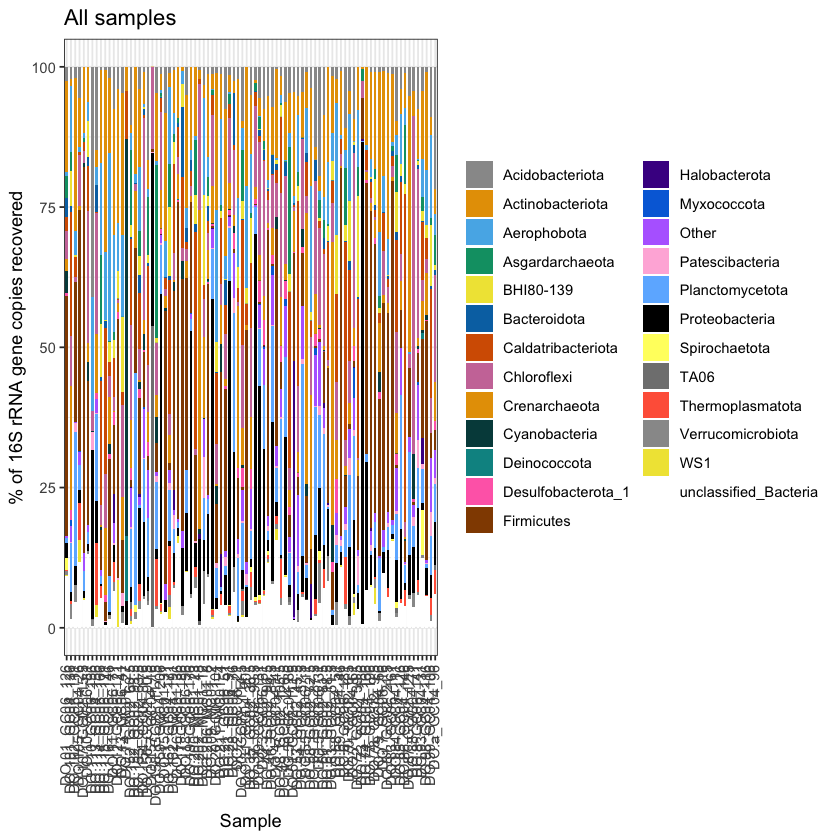

In [502]:
#General plot
ggplot(filt_major_taxa_proportions_tab_for_plot.g2, aes(x = Sample, y = Proportion, fill = Phylum)) +
  geom_bar(width = 0.6, stat = "identity") + scale_fill_manual(values = cbbPalette) +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.4, hjust = 1), legend.title = element_blank()) +
  labs(x = "Sample", y = "% of 16S rRNA gene copies recovered", title = "All samples")


The plot above is not very informative, so we will build separate plots for each core.

In [503]:
#Create a copy of the tables for plots
major_taxa_proportions_tab_mc01_for_plot <- data.frame(major_taxa_proportions_tab_mc01)
major_taxa_proportions_tab_gc02_for_plot <- data.frame(major_taxa_proportions_tab_gc02)
major_taxa_proportions_tab_gc04_for_plot <- data.frame(major_taxa_proportions_tab_gc04)
major_taxa_proportions_tab_gc06_for_plot <- data.frame(major_taxa_proportions_tab_gc06)

In [504]:
head(major_taxa_proportions_tab_mc01_for_plot)

DO.209_MC01_2 DO.211_MC01_4 DO.206_MC01_8 DO.203_MC01_12
Proteobacteria     55.4433072     0.6250       10.685484      5.582440     
Caldatribacteriota  3.5491160    11.8750        2.217742      2.618389     
Actinobacteriota    2.5920510     8.1250       14.919355      2.393709     
Crenarchaeota       6.7393327     6.8750        5.241935     14.474594     
TA06                0.0000000     0.0000        0.000000      0.000000     
Aerophobota         0.3190217    15.3125        3.427419     17.170757     
                   DO.202_MC01_18 DO.200_MC01_23 DO.14_MC01_27 DO.15_MC01_31
Proteobacteria     14.536741       4.2105263     4.251269       2.201933    
Caldatribacteriota  0.798722      38.5964912     8.629442       1.879699    
Actinobacteriota    1.757188      12.2807018     4.251269      22.932331    
Crenarchaeota      56.869010       0.0000000     0.000000       2.148228    
TA06                0.798722       0.0000000     0.000000       0.000000    
Aerophobota         0.000000       0.7017544     0.000000       6.283566    
                   DO.16_MC01_36
Proteobacteria     1.342282     
Caldatribacteriota 5.369128     
Actinobacteriota   9.060403     
Crenarchaeota      4.362416     
TA06               0.000000     
Aerophobota        0.000000

In [505]:
#Simplify sample names
colnames(major_taxa_proportions_tab_mc01_for_plot) <- gsub("^[^_]*_", "", colnames(major_taxa_proportions_tab_mc01_for_plot))
colnames(major_taxa_proportions_tab_gc02_for_plot) <- gsub("^[^_]*_", "", colnames(major_taxa_proportions_tab_gc02_for_plot))
colnames(major_taxa_proportions_tab_gc04_for_plot) <- gsub("^[^_]*_", "", colnames(major_taxa_proportions_tab_gc04_for_plot))
colnames(major_taxa_proportions_tab_gc06_for_plot) <- gsub("^[^_]*_", "", colnames(major_taxa_proportions_tab_gc06_for_plot))

mod_sample_info_tab_mc01$Sample <- gsub("^[^_]*_", "", mod_sample_info_tab_mc01$Sample)
mod_sample_info_tab_gc02$Sample <- gsub("^[^_]*_", "", mod_sample_info_tab_gc02$Sample)
mod_sample_info_tab_gc04$Sample <- gsub("^[^_]*_", "", mod_sample_info_tab_gc04$Sample)
mod_sample_info_tab_gc06$Sample <- gsub("^[^_]*_", "", mod_sample_info_tab_gc06$Sample)

In [506]:
# Add a column of the taxa names so that it is within the table, rather
# than just as row names (this makes working with ggplot easier)
major_taxa_proportions_tab_mc01_for_plot <- 
  major_taxa_proportions_tab_mc01_for_plot %>% rownames_to_column("Taxa")
major_taxa_proportions_tab_gc02_for_plot <- 
  major_taxa_proportions_tab_gc02_for_plot %>% rownames_to_column("Taxa")
major_taxa_proportions_tab_gc04_for_plot <- 
  major_taxa_proportions_tab_gc04_for_plot %>% rownames_to_column("Taxa")
major_taxa_proportions_tab_gc06_for_plot <- 
  major_taxa_proportions_tab_gc06_for_plot %>% rownames_to_column("Taxa")

In [507]:
# now we'll transform the tables into narrow, or long, format (also makes
# plotting easier)
major_taxa_proportions_tab_mc01_for_plot <- 
  major_taxa_proportions_tab_mc01_for_plot %>% 
  pivot_longer(!Taxa, names_to = "Sample", values_to = "Proportion") %>% 
  data.frame(check.names = FALSE)
major_taxa_proportions_tab_gc02_for_plot <- 
  major_taxa_proportions_tab_gc02_for_plot %>% 
  pivot_longer(!Taxa, names_to = "Sample", values_to = "Proportion") %>% 
  data.frame(check.names = FALSE)
major_taxa_proportions_tab_gc04_for_plot <- 
  major_taxa_proportions_tab_gc04_for_plot %>% 
  pivot_longer(!Taxa, names_to = "Sample", values_to = "Proportion") %>% 
  data.frame(check.names = FALSE)
major_taxa_proportions_tab_gc06_for_plot <- 
  major_taxa_proportions_tab_gc06_for_plot %>% 
  pivot_longer(!Taxa, names_to = "Sample", values_to = "Proportion") %>% 
  data.frame(check.names = FALSE)

In [510]:
#Add depth and core to tables
major_taxa_proportions_tab_mc01_for_plot <- 
  major_taxa_proportions_tab_mc01_for_plot %>% left_join(mod_sample_info_tab_mc01)
major_taxa_proportions_tab_gc02_for_plot <- 
  major_taxa_proportions_tab_gc02_for_plot %>% left_join(mod_sample_info_tab_gc02)
major_taxa_proportions_tab_gc04_for_plot <- 
  major_taxa_proportions_tab_gc04_for_plot %>% left_join(mod_sample_info_tab_gc04)
major_taxa_proportions_tab_gc06_for_plot <- 
  major_taxa_proportions_tab_gc06_for_plot %>% left_join(mod_sample_info_tab_gc06)

Joining with `by = join_by(Sample)`
Joining with `by = join_by(Sample)`
Joining with `by = join_by(Sample)`
Joining with `by = join_by(Sample)`


##### Plot for San Clemente Basin core 01

In [512]:
#Organize things in plot

major_taxa_proportions_tab_mc01_for_plot$Sample <-gsub("^.*_", "", major_taxa_proportions_tab_mc01_for_plot$Sample)
major_taxa_proportions_tab_mc01_for_plot$Sample <- factor(major_taxa_proportions_tab_mc01_for_plot$Sample, levels=unique(major_taxa_proportions_tab_mc01_for_plot$Sample)[order(as.numeric(gsub("^.*_","", unique(major_taxa_proportions_tab_mc01_for_plot$Sample))))])
#major_taxa_proportions_tab_mc01_for_plot$Genus <- with(proteobacteria_major_taxa_proportions_tab_g_mc01_for_plot.g2,factor(Class,Genus = rev(sort(unique(Genus)))))


In [513]:
`%ni%` <- Negate(`%in%`)
#Include only S cycling taxa
major_taxa_proportions_tab_mc01_for_plot.1 <- major_taxa_proportions_tab_mc01_for_plot %>%
  filter(Taxa %in%  c("Bacteroidota",
                      "Spirochaetota",
                      "Marinimicrobia (SAR406 clade)",
                      "Planctomycetota",
                      "Actinobacteriota",
                      "Crenarchaeota",
                      "Thermoplasmatota",
                      "Verrucomicrobiota",
                      "Desulfobacterota_1",
                      "Desulfobacterota_2",
                      "Dadabacteria",
                      "Chloroflexi",
                      "Zixibacteria",
                      "Halobacterota",
                      "Nitrospirota",
                      "Acidobacteriota"))
major_taxa_proportions_tab_mc01_for_plot.2 <- major_taxa_proportions_tab_mc01_for_plot.1 %>% 
  mutate(Taxa = if_else(Taxa %ni% c("Desulfobacterota_1",
                                    "Desulfobacterota_2") , Taxa, "Desulfobacterota"))


In [514]:
head(major_taxa_proportions_tab_mc01_for_plot)

Taxa           Sample Proportion Core Depth core_colors Depth_bin
1 Proteobacteria 2      55.443307  MC01  2    #1B9E77     0-20     
2 Proteobacteria 4       0.625000  MC01  4    #1B9E77     0-20     
3 Proteobacteria 8      10.685484  MC01  8    #1B9E77     0-20     
4 Proteobacteria 12      5.582440  MC01 12    #1B9E77     0-20     
5 Proteobacteria 18     14.536741  MC01 18    #1B9E77     0-20     
6 Proteobacteria 23      4.210526  MC01 23    #1B9E77     21-60    
  depth_colors
1 #1B9E77     
2 #1B9E77     
3 #1B9E77     
4 #1B9E77     
5 #1B9E77     
6 #D95F02

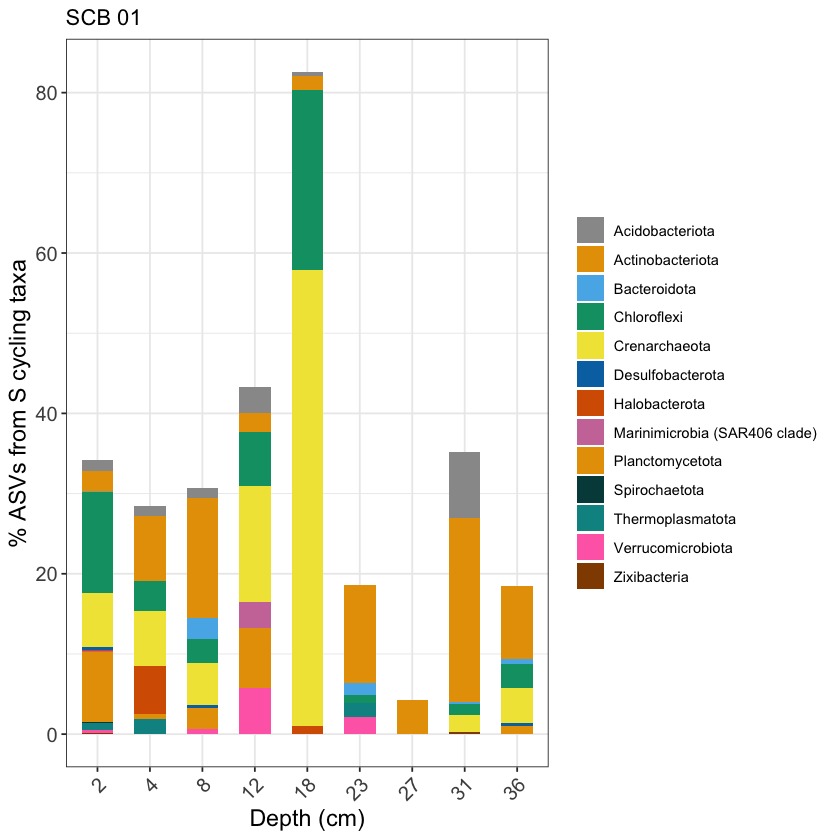

In [515]:
#For phyla
major_taxa_proportions_tab_mc01_for_plot.2 %>% 
  mutate(Depth = factor(Depth, levels = unique(Depth))) %>% 
  ggplot(aes(x = Depth, y = Proportion, fill = Taxa)) +
  geom_bar(width = 0.6, stat = "identity") + scale_fill_manual(values = cbbPalette) +
  theme_bw() +
  theme(axis.text.x = element_text(size=12, angle = 45, hjust = 1), 
        axis.text.y = element_text(size=12), axis.title = element_text(size=14), 
        legend.title = element_blank()) +
  labs(x = "Depth (cm)", y = "% ASVs from S cycling taxa", title = "SCB 01")

`summarise()` has grouped output by 'Depth_bin'. You can
override using the `.groups` argument.
Warning message:
"Removed 13 rows containing missing values or values outside the
scale range (`geom_bar()`)."


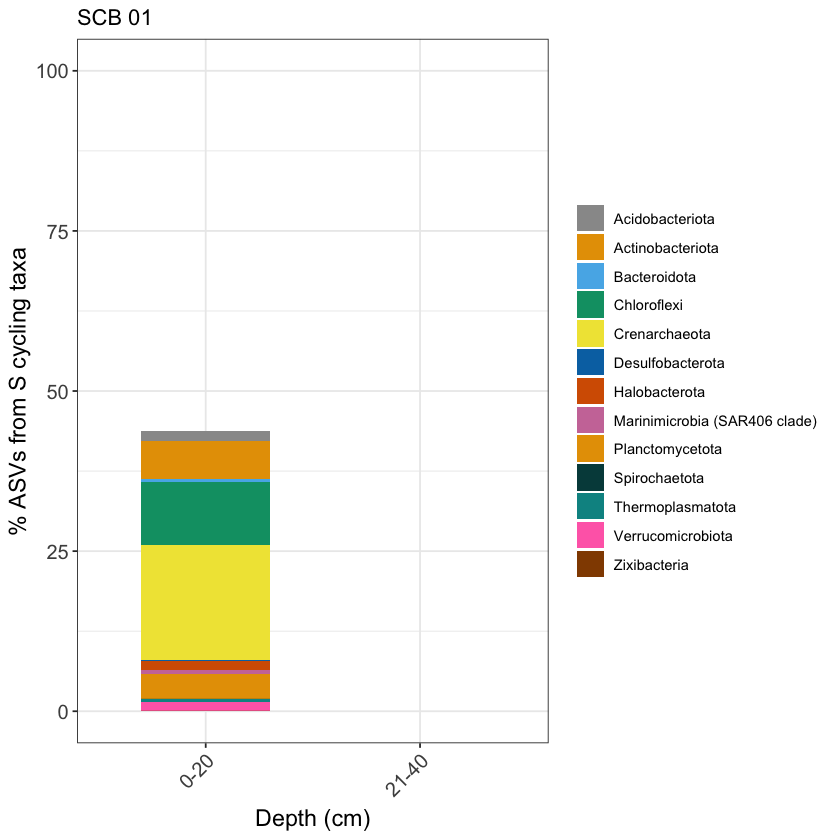

In [516]:
#Get averages for depth_bin
major_taxa_proportions_tab_mc01_for_plot.3<- major_taxa_proportions_tab_mc01_for_plot.2 %>% 
  group_by(Depth_bin, Taxa) %>% summarise(ave = mean(Proportion))
#plot
major_taxa_proportions_tab_mc01_for_plot.3 %>% 
  mutate(Depth_bin = factor(Depth_bin, levels = unique(Depth_bin))) %>% 
  ggplot(aes(x = Depth_bin, y = ave, fill = Taxa)) +
  geom_bar(width = 0.6, stat = "identity") + scale_fill_manual(values = cbbPalette) +
  theme_bw() +
  theme(axis.text.x = element_text(size=12, angle = 45, hjust = 1), 
        axis.text.y = element_text(size=12), axis.title = element_text(size=14), 
        legend.title = element_blank()) +
  labs(x = "Depth (cm)", y = "% ASVs from S cycling taxa", title = "SCB 01")+
  scale_x_discrete(limits = c("0-20", "21-40")) +
  scale_y_continuous(limits = c(0, 100))

##### Plot for Cocos Ridge station 02

In [517]:
#Organize things in plot
major_taxa_proportions_tab_gc02_for_plot$Sample <-gsub("^.*_", "", major_taxa_proportions_tab_gc02_for_plot$Sample)
major_taxa_proportions_tab_gc02_for_plot$Sample <- factor(major_taxa_proportions_tab_gc02_for_plot$Sample, levels=unique(major_taxa_proportions_tab_gc02_for_plot$Sample)[order(as.numeric(gsub("^.*_","", unique(major_taxa_proportions_tab_gc02_for_plot$Sample))))])
#major_taxa_proportions_tab_gc02_for_plot$Genus <- with(proteobacteria_major_taxa_proportions_tab_g_gc02_for_plot.g2,factor(Class,Genus = rev(sort(unique(Genus)))))

#Make plot
#Include only S cycling taxa
major_taxa_proportions_tab_gc02_for_plot.1 <- major_taxa_proportions_tab_gc02_for_plot %>%
  filter(Taxa %in%  c("Bacteroidota",
                      "Spirochaetota",
                      "Marinimicrobia (SAR406 clade)",
                      "Planctomycetota",
                      "Actinobacteriota",
                      "Crenarchaeota",
                      "Thermoplasmatota",
                      "Verrucomicrobiota",
                      "Desulfobacterota_1",
                      "Desulfobacterota_2",
                      "Dadabacteria",
                      "Chloroflexi",
                      "Zixibacteria",
                      "Halobacterota",
                      "Nitrospirota",
                      "Acidobacteriota"))
major_taxa_proportions_tab_gc02_for_plot.2 <- major_taxa_proportions_tab_gc02_for_plot.1 %>% 
  mutate(Taxa = if_else(Taxa %ni% c("Desulfobacterota_1",
                                    "Desulfobacterota_2") , Taxa, "Desulfobacterota"))


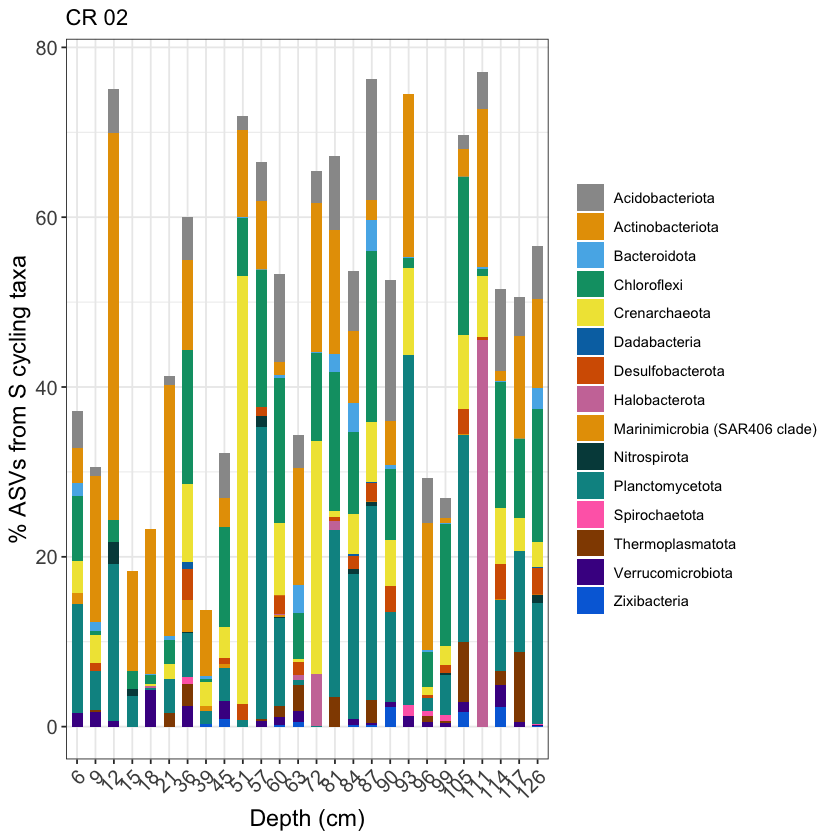

In [518]:
#For phyla
major_taxa_proportions_tab_gc02_for_plot.2 %>% 
  mutate(Depth = factor(Depth, levels = unique(Depth))) %>% 
  ggplot(aes(x = Depth, y = Proportion, fill = Taxa)) +
  geom_bar(width = 0.6, stat = "identity") + scale_fill_manual(values = cbbPalette) +
  theme_bw() +
  theme(axis.text.x = element_text(size=12, angle = 45, hjust = 1), 
        axis.text.y = element_text(size=12), axis.title = element_text(size=14), 
        legend.title = element_blank()) +
  labs(x = "Depth (cm)", y = "% ASVs from S cycling taxa", title = "CR 02")


`summarise()` has grouped output by 'Depth_bin'. You can
override using the `.groups` argument.


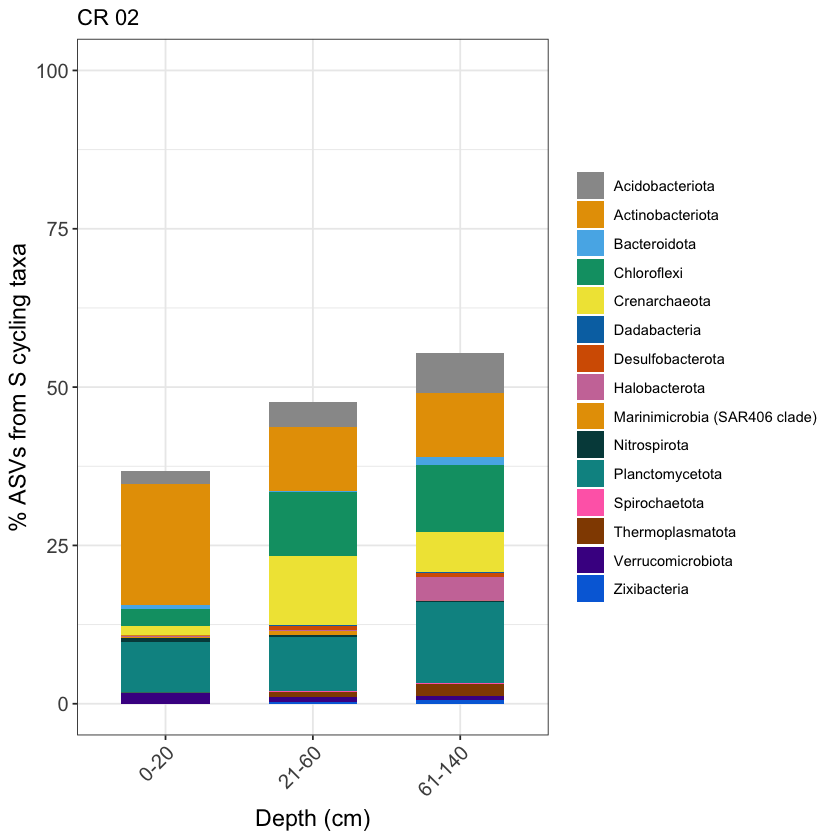

In [522]:
#Get averages for depth_bin
major_taxa_proportions_tab_gc02_for_plot.3<- major_taxa_proportions_tab_gc02_for_plot.2 %>% 
  group_by(Depth_bin, Taxa) %>% summarise(ave = mean(Proportion))
#plot
major_taxa_proportions_tab_gc02_for_plot.3 %>% 
  mutate(Depth_bin = factor(Depth_bin, levels = unique(Depth_bin))) %>% 
  ggplot(aes(x = Depth_bin, y = ave, fill = Taxa)) +
  geom_bar(width = 0.6, stat = "identity") + scale_fill_manual(values = cbbPalette) +
  theme_bw() +
  theme(axis.text.x = element_text(size=12, angle = 45, hjust = 1), 
        axis.text.y = element_text(size=12), axis.title = element_text(size=14), 
        legend.title = element_blank()) +
  labs(x = "Depth (cm)", y = "% ASVs from S cycling taxa", title = "CR 02")+
  scale_x_discrete(limits = c("0-20", "21-60","61-140")) +
  scale_y_continuous(limits = c(0, 100))

##### Plot for Cocos Ridge station 03

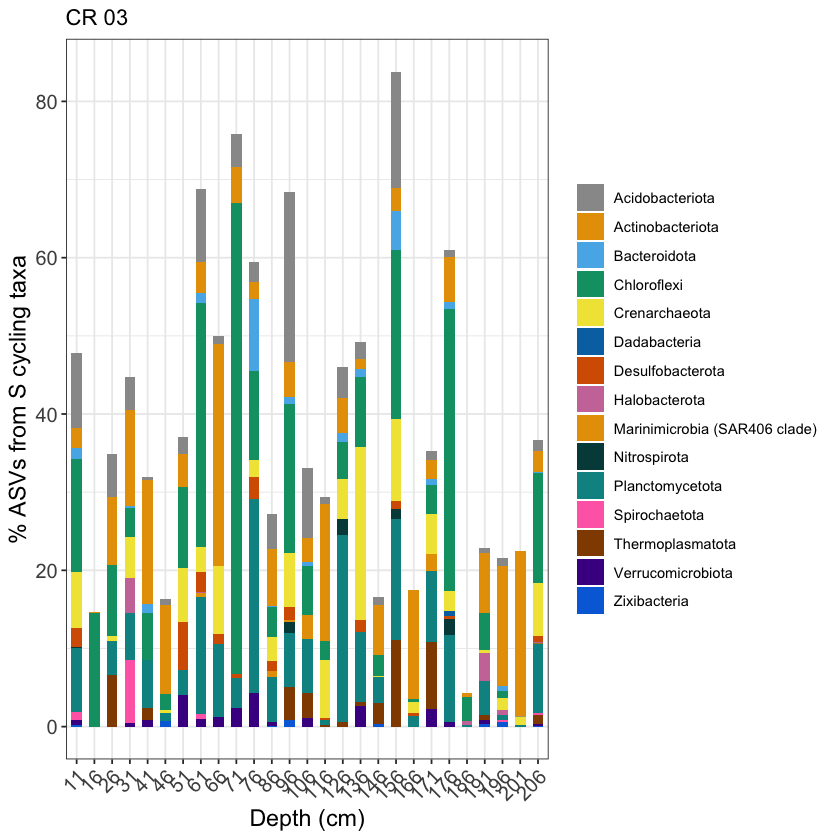

In [525]:
#Organize things in plot
major_taxa_proportions_tab_gc04_for_plot$Sample <-gsub("^.*_", "", major_taxa_proportions_tab_gc04_for_plot$Sample)
major_taxa_proportions_tab_gc04_for_plot$Sample <- factor(major_taxa_proportions_tab_gc04_for_plot$Sample, levels=unique(major_taxa_proportions_tab_gc04_for_plot$Sample)[order(as.numeric(gsub("^.*_","", unique(major_taxa_proportions_tab_gc04_for_plot$Sample))))])
#major_taxa_proportions_tab_gc04_for_plot$Genus <- with(proteobacteria_major_taxa_proportions_tab_g_gc04_for_plot.g2,factor(Class,Genus = rev(sort(unique(Genus)))))

#Make plot
#Include only S cycling taxa
major_taxa_proportions_tab_gc04_for_plot.1 <- major_taxa_proportions_tab_gc04_for_plot %>%
  filter(Taxa %in%  c("Bacteroidota",
                      "Spirochaetota",
                      "Marinimicrobia (SAR406 clade)",
                      "Planctomycetota",
                      "Actinobacteriota",
                      "Crenarchaeota",
                      "Thermoplasmatota",
                      "Verrucomicrobiota",
                      "Desulfobacterota_1",
                      "Desulfobacterota_2",
                      "Dadabacteria",
                      "Chloroflexi",
                      "Zixibacteria",
                      "Halobacterota",
                      "Nitrospirota",
                      "Acidobacteriota"))
major_taxa_proportions_tab_gc04_for_plot.2 <- major_taxa_proportions_tab_gc04_for_plot.1 %>% 
  mutate(Taxa = if_else(Taxa %ni% c("Desulfobacterota_1",
                                    "Desulfobacterota_2") , Taxa, "Desulfobacterota"))
#For phyla
major_taxa_proportions_tab_gc04_for_plot.2 %>% 
  mutate(Depth = factor(Depth, levels = unique(Depth))) %>% 
  ggplot(aes(x = Depth, y = Proportion, fill = Taxa)) +
  geom_bar(width = 0.6, stat = "identity") + scale_fill_manual(values = cbbPalette) +
  theme_bw() +
  theme(axis.text.x = element_text(size=12, angle = 45, hjust = 1), 
        axis.text.y = element_text(size=12), axis.title = element_text(size=14), 
        legend.title = element_blank()) +
  labs(x = "Depth (cm)", y = "% ASVs from S cycling taxa", title = "CR 03")


`summarise()` has grouped output by 'Depth_bin'. You can
override using the `.groups` argument.


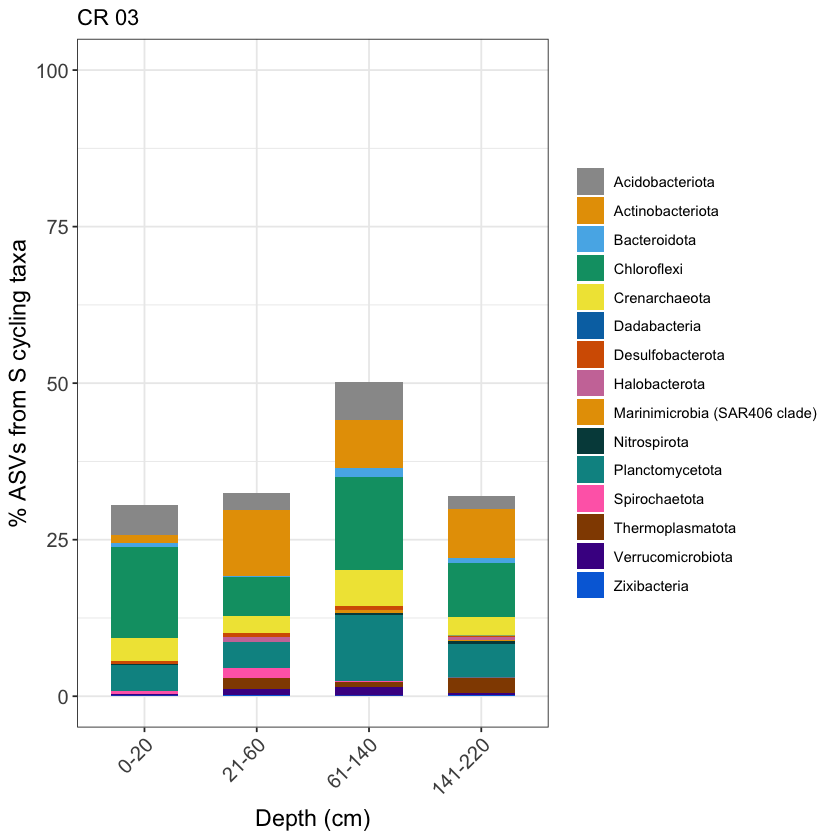

In [526]:
#Get averages for depth_bin
major_taxa_proportions_tab_gc04_for_plot.3<- major_taxa_proportions_tab_gc04_for_plot.2 %>% 
  group_by(Depth_bin, Taxa) %>% summarise(ave = mean(Proportion))
#plot
major_taxa_proportions_tab_gc04_for_plot.3 %>% 
  mutate(Depth_bin = factor(Depth_bin, levels = unique(Depth_bin))) %>% 
  ggplot(aes(x = Depth_bin, y = ave, fill = Taxa)) +
  geom_bar(width = 0.6, stat = "identity") + scale_fill_manual(values = cbbPalette) +
  theme_bw() +
  theme(axis.text.x = element_text(size=12, angle = 45, hjust = 1), 
        axis.text.y = element_text(size=12), axis.title = element_text(size=14), 
        legend.title = element_blank()) +
  labs(x = "Depth (cm)", y = "% ASVs from S cycling taxa", title = "CR 03")+
  scale_x_discrete(limits = c("0-20", "21-60", "61-140",'141-220')) +
  scale_y_continuous(limits = c(0, 100))

##### Plot for Cocos Ridge station 04

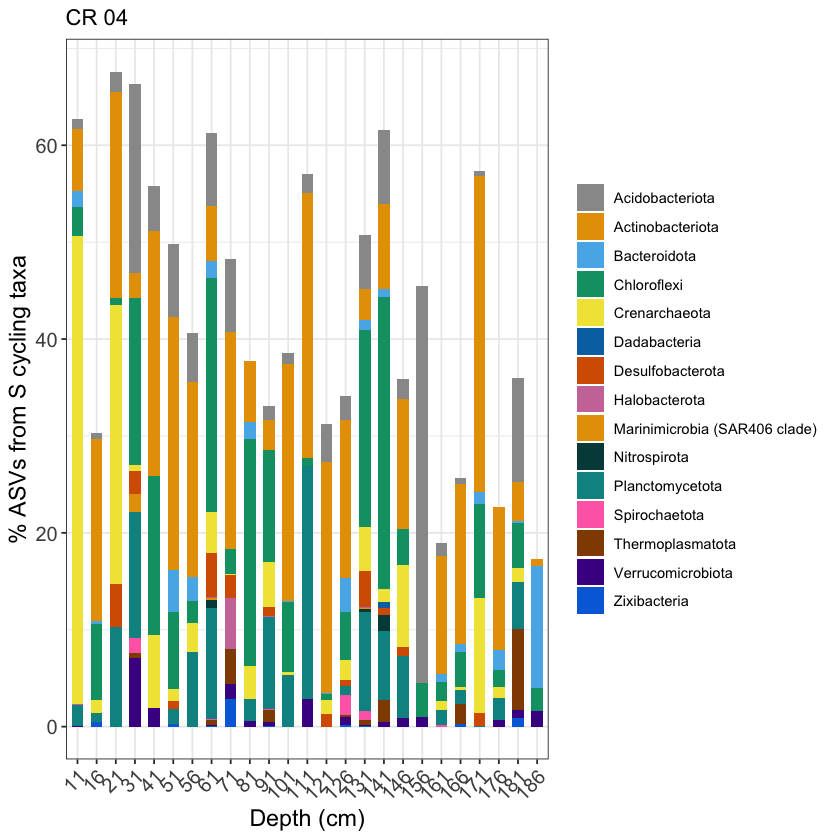

In [527]:
#Organize things in plot
major_taxa_proportions_tab_gc06_for_plot$Sample <-gsub("^.*_", "", major_taxa_proportions_tab_gc06_for_plot$Sample)
major_taxa_proportions_tab_gc06_for_plot$Sample <- factor(major_taxa_proportions_tab_gc06_for_plot$Sample, levels=unique(major_taxa_proportions_tab_gc06_for_plot$Sample)[order(as.numeric(gsub("^.*_","", unique(major_taxa_proportions_tab_gc06_for_plot$Sample))))])
#major_taxa_proportions_tab_gc06_for_plot$Genus <- with(proteobacteria_major_taxa_proportions_tab_g_gc06_for_plot.g2,factor(Class,Genus = rev(sort(unique(Genus)))))

#Make plot
#Include only S cycling taxa
major_taxa_proportions_tab_gc06_for_plot.1 <- major_taxa_proportions_tab_gc06_for_plot %>%
  filter(Taxa %in%  c("Bacteroidota",
                      "Spirochaetota",
                      "Marinimicrobia (SAR406 clade)",
                      "Planctomycetota",
                      "Actinobacteriota",
                      "Crenarchaeota",
                      "Thermoplasmatota",
                      "Verrucomicrobiota",
                      "Desulfobacterota_1",
                      "Desulfobacterota_2",
                      "Dadabacteria",
                      "Chloroflexi",
                      "Zixibacteria",
                      "Halobacterota",
                      "Nitrospirota",
                      "Acidobacteriota"))
major_taxa_proportions_tab_gc06_for_plot.2 <- major_taxa_proportions_tab_gc06_for_plot.1 %>% 
  mutate(Taxa = if_else(Taxa %ni% c("Desulfobacterota_1",
                                    "Desulfobacterota_2") , Taxa, "Desulfobacterota"))
#For phyla
major_taxa_proportions_tab_gc06_for_plot.2 %>% 
  mutate(Depth = factor(Depth, levels = unique(Depth))) %>% 
  ggplot(aes(x = Depth, y = Proportion, fill = Taxa)) +
  geom_bar(width = 0.6, stat = "identity") + scale_fill_manual(values = cbbPalette) +
  theme_bw() +
  theme(axis.text.x = element_text(size=12, angle = 45, hjust = 1), 
        axis.text.y = element_text(size=12), axis.title = element_text(size=14), 
        legend.title = element_blank()) +
  labs(x = "Depth (cm)", y = "% ASVs from S cycling taxa", title = "CR 04")


`summarise()` has grouped output by 'Depth_bin'. You can
override using the `.groups` argument.


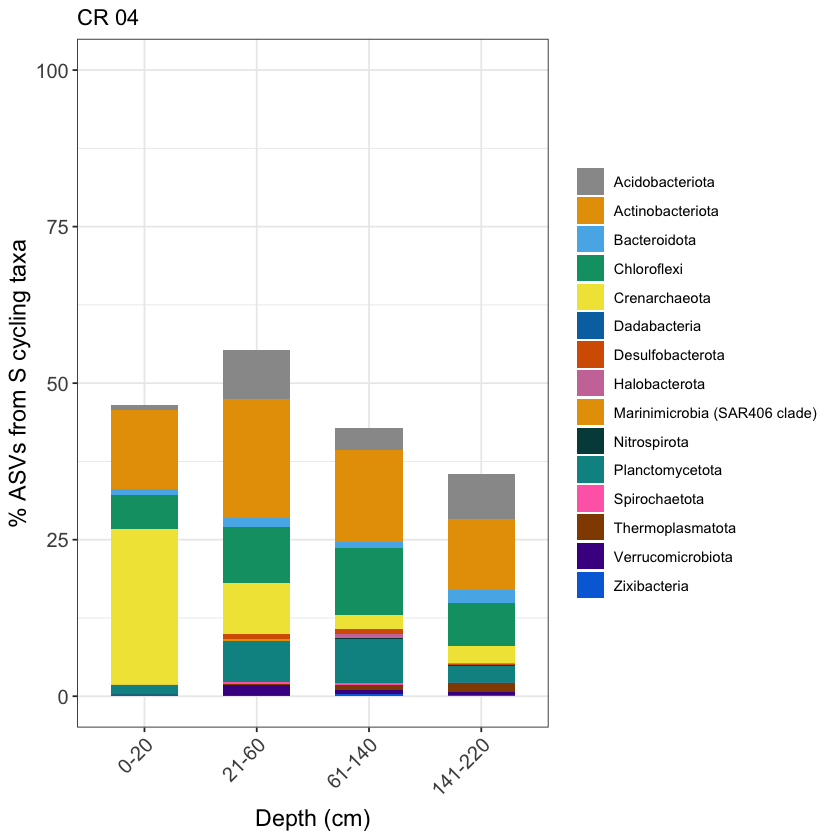

In [529]:
#Get averages for depth_bin
major_taxa_proportions_tab_gc06_for_plot.3<- major_taxa_proportions_tab_gc06_for_plot.2 %>% 
  group_by(Depth_bin, Taxa) %>% summarise(ave = mean(Proportion))
#plot
major_taxa_proportions_tab_gc06_for_plot.3 %>% 
  mutate(Depth_bin = factor(Depth_bin, levels = unique(Depth_bin))) %>% 
  ggplot(aes(x = Depth_bin, y = ave, fill = Taxa)) +
  geom_bar(width = 0.6, stat = "identity") + scale_fill_manual(values = cbbPalette) +
  theme_bw() +
  theme(axis.text.x = element_text(size=12, angle = 45, hjust = 1), 
        axis.text.y = element_text(size=12), axis.title = element_text(size=14), 
        legend.title = element_blank()) +
  labs(x = "Depth (cm)", y = "% ASVs from S cycling taxa", title = "CR 04")+
  scale_x_discrete(limits = c("0-20", "21-60", "61-140",'141-220')) +
  scale_y_continuous(limits = c(0, 100))

#### Other data visualizations

##### Boxplots

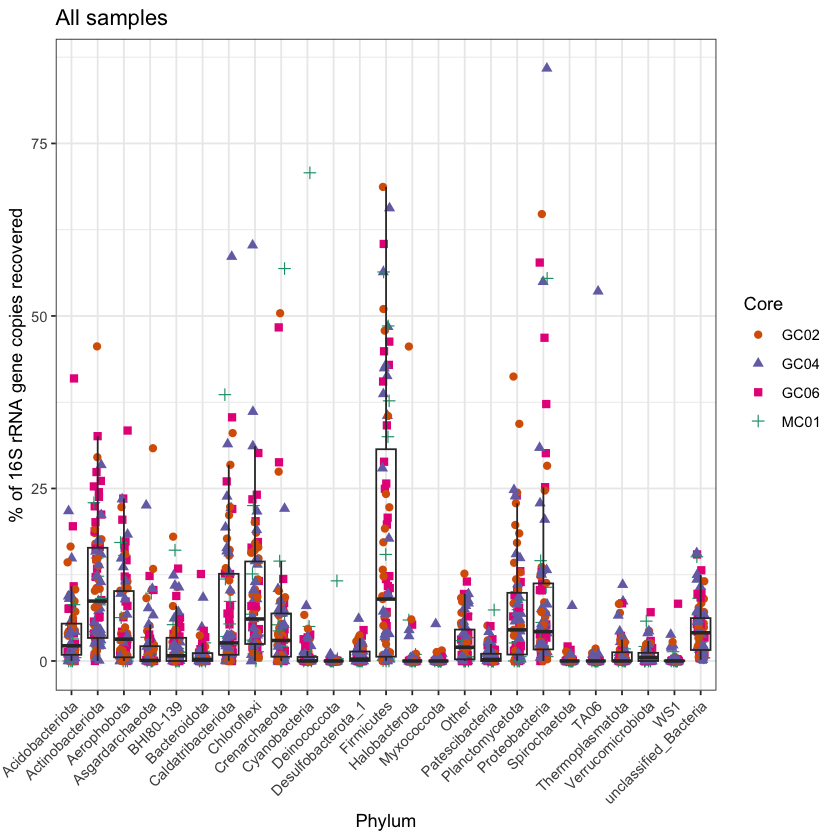

In [530]:
# We will now visualize diversity across the cores using boxplots, where each box is a major taxon, 
# with each point being colored/shaped based on core:
ggplot(filt_major_taxa_proportions_tab_for_plot.g2, aes(Phylum, Proportion)) +
  geom_jitter(aes(color = Core, shape = Core), size = 2, width = 0.15, height = 0) +
  scale_color_manual(values = unique(filt_major_taxa_proportions_tab_for_plot.g2$core_colors[order(filt_major_taxa_proportions_tab_for_plot.g2$Core)])) +
  geom_boxplot(fill = NA, outlier.color = NA) + theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x="Phylum", y = "% of 16S rRNA gene copies recovered", title = "All samples")

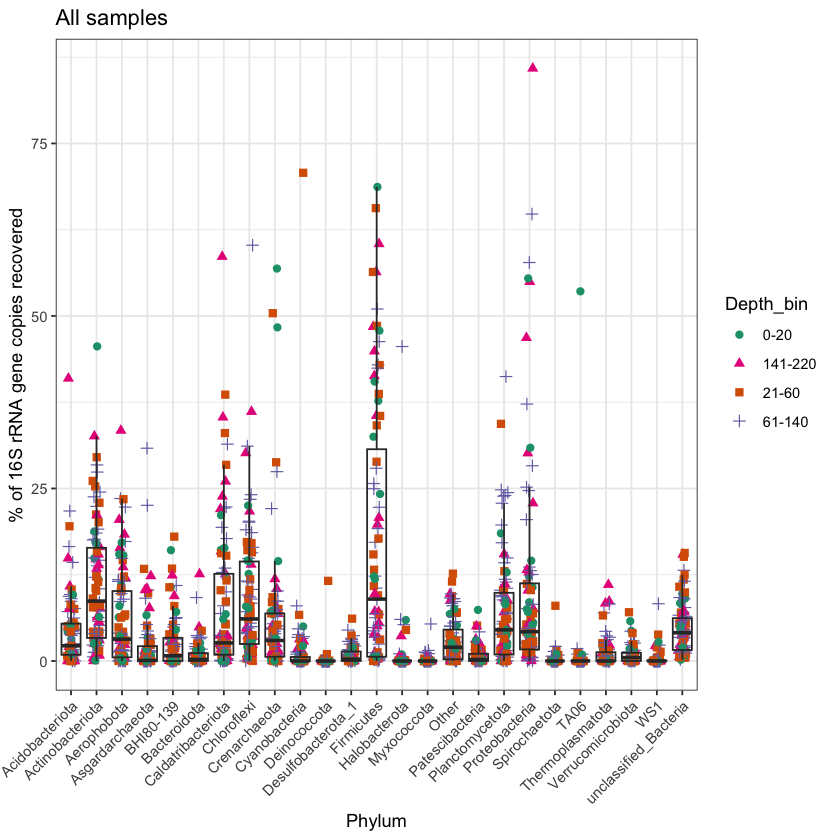

In [531]:
# We will now make the point color/shape based on Depth bins:
ggplot(filt_major_taxa_proportions_tab_for_plot.g2, aes(Phylum, Proportion)) +
  geom_jitter(aes(color = Depth_bin, shape = Depth_bin), size = 2, width = 0.15, height = 0) +
  scale_color_manual(values = unique(filt_major_taxa_proportions_tab_for_plot.g2$depth_colors[order(filt_major_taxa_proportions_tab_for_plot.g2$Depth_bin)])) +
  geom_boxplot(fill = NA, outlier.color = NA) + theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(x="Phylum", y = "% of 16S rRNA gene copies recovered", title = "All samples")


##### Pie charts

Warning message in RColorBrewer::brewer.pal(n, pal):
"n too large, allowed maximum for palette Paired is 12
Returning the palette you asked for with that many colors
"


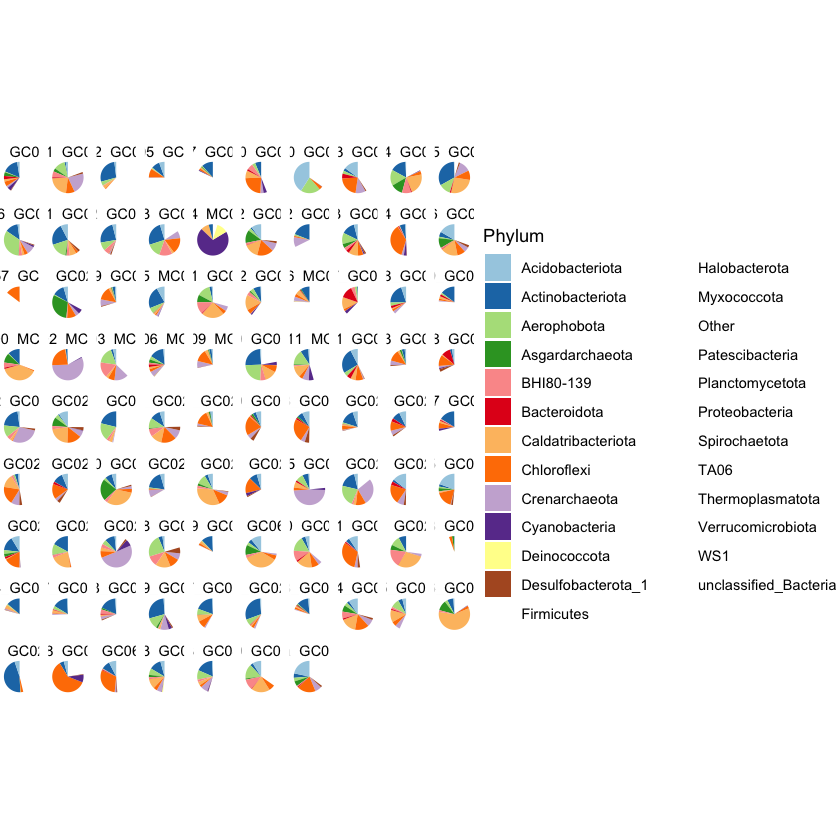

In [532]:
#This is not the best visualization method because there are to many depths and taxa.
ggplot(filt_major_taxa_proportions_tab_for_plot.g2, aes(x = " ", y = Proportion, group = Phylum, fill = Phylum)) +
  geom_bar(width = 1, stat = "identity") + scale_fill_brewer(palette = "Paired") +
  coord_polar("y", start = 0) + facet_wrap(~ Sample) + theme_void()


##### Heatmaps

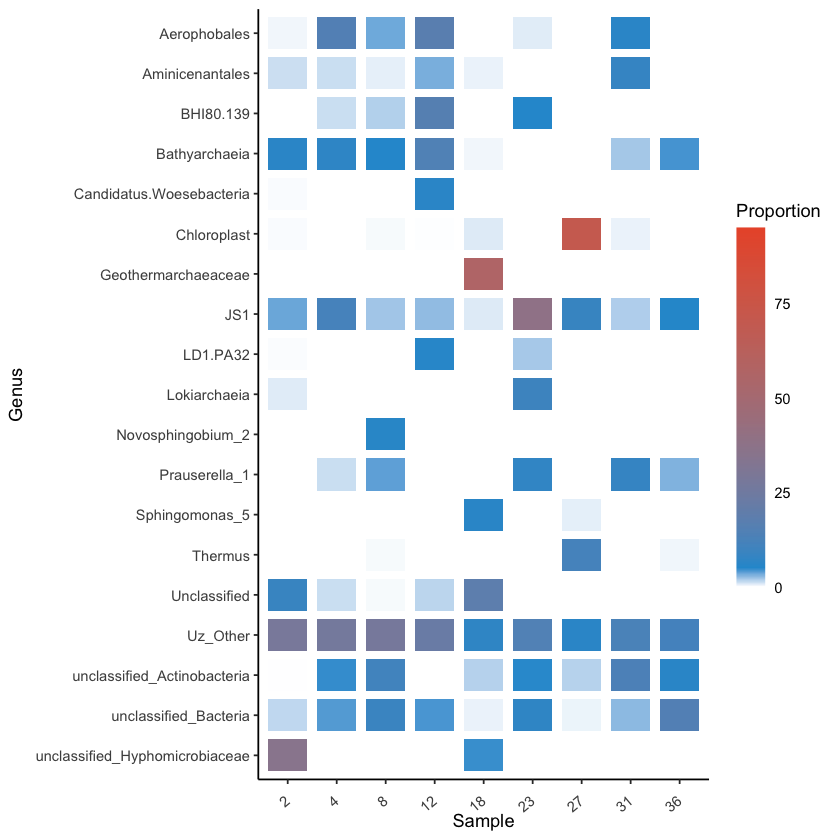

In [548]:
#Plot for MC01
#Filters
mc_01_genus_unc <- filt_major_taxa_proportions_tab_for_plot_g_mc01.g2 %>% 
  mutate(Genus = if_else(Genus %ni% c("uncultured.1",
                                      "uncultured.2",
                                      "uncultured",
                                      "unclassified_Root",
                                      "unclassified_Bacilli") , Genus, "Unclassified"))

mc_01_genus_unc_g1 <- mc_01_genus_unc %>% 
  mutate(Genus = if_else(Genus %ni% c('Other'), Genus, "Uz_Other"))

#Organize things in plot
mc_01_genus_unc_g1$Sample <-gsub("^.*_", "", mc_01_genus_unc_g1$Sample)
mc_01_genus_unc_g1$Sample <- factor(mc_01_genus_unc_g1$Sample, levels=unique(mc_01_genus_unc_g1$Sample)[order(as.numeric(gsub("^.*_","", unique(mc_01_genus_unc_g1$Sample))))])
mc_01_genus_unc_g1$Genus <- with(mc_01_genus_unc_g1,factor(Genus,levels = rev(sort(unique(Genus)))))

#Make plot
ggplot(mc_01_genus_unc_g1, aes(x=Sample, y = Genus, fill=Proportion)) + 
  geom_tile(width=0.8, height=0.8) +
  scale_fill_gradientn(
    colors=c("white","#2699D3","#EA5835"),
    values=rescale(c(0,5,95)),
    limits=c(0,95)
  ) +
  guides(fill=guide_colorbar(ticks.colour = NA, barheight = 15)) +
  theme_classic() + theme(axis.text.x = element_text(angle=40, hjust=1, vjust=0.5))


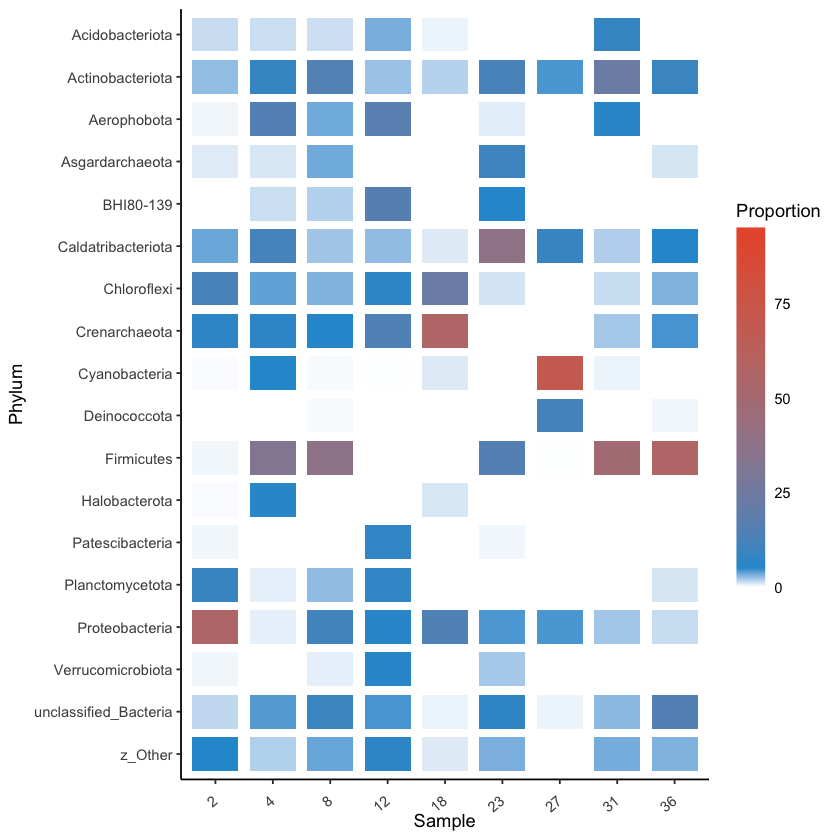

In [549]:
#Phylum
#Filters
`%ni%` <- Negate(`%in%`)
mc01_phylum_unc <- filt_major_taxa_proportions_tab_for_plot_mc01.g2 %>% 
  mutate(Phylum = if_else(Phylum %ni% c('Other'), Phylum, "z_Other"))

#Organize things in plot
mc01_phylum_unc$Sample <-gsub("^.*_", "", mc01_phylum_unc$Sample)
mc01_phylum_unc$Sample <- factor(mc01_phylum_unc$Sample, levels=unique(mc01_phylum_unc$Sample)[order(as.numeric(gsub("^.*_","", unique(mc01_phylum_unc$Sample))))])
mc01_phylum_unc$Phylum <- with(mc01_phylum_unc,factor(Phylum,levels = rev(sort(unique(Phylum)))))

#Make plot
ggplot(mc01_phylum_unc, aes(x=Sample, y = Phylum, fill=Proportion)) + 
  geom_tile(width=0.8, height=0.8) +
  scale_fill_gradientn(
    colors=c("white","#2699D3","#EA5835"),
    values=rescale(c(0,5,95)),
    limits=c(0,95)
  ) +
  guides(fill=guide_colorbar(ticks.colour = NA, barheight = 15)) +
  theme_classic() + theme(axis.text.x = element_text(angle=40, hjust=1, vjust=0.5))


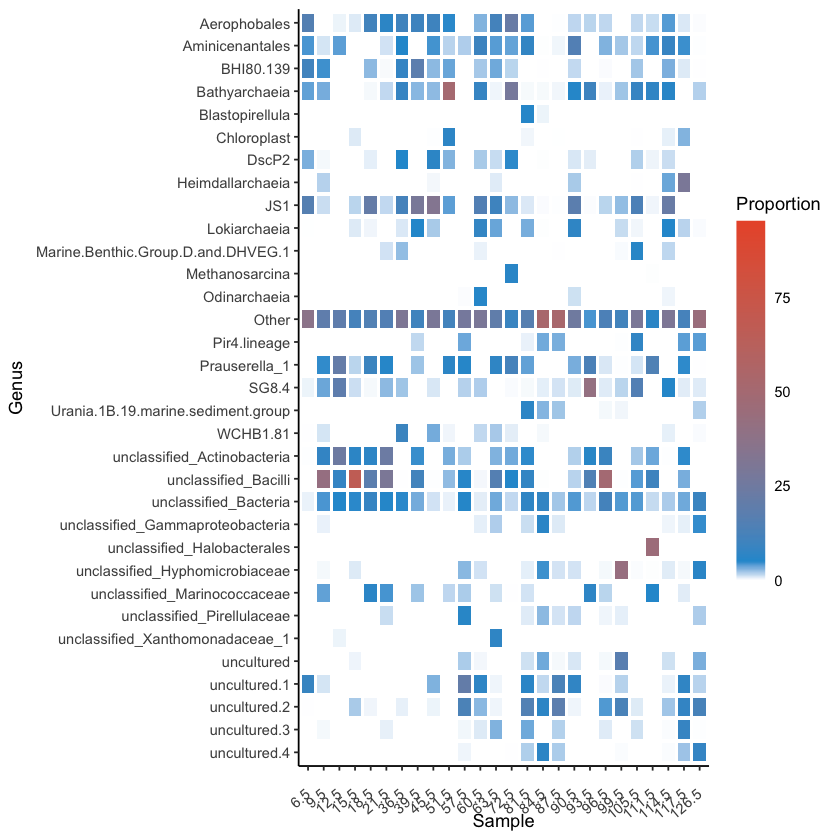

In [550]:
#Plot for GC02

#Genus
#Filters
`%ni%` <- Negate(`%in%`)
gc_02_genus_unc <- filt_major_taxa_proportions_tab_for_plot_g_gc02.g2 %>% 
  mutate(Genus = if_else(Genus %ni% c("uncultured.1",
                                      "uncultured.2",
                                      "uncultured.3",
                                      "uncultured",
                                      "unclassified_Root",
                                      "unclassified_Bacteria",
                                      "unclassified_Halobacterales",
                                      "Unclassified") , Genus, "Unclassified"))
gc_02_genus_unc_g1 <- gc_02_genus_unc %>% 
  mutate(Genus = if_else(Genus %ni% c("DscP2",
                                      "SG8.4",
                                      "WCHB1.81") , Genus, "Other"))
gc_02_genus_unc_g2 <- gc_02_genus_unc_g1 %>% 
  mutate(Genus = if_else(Genus %ni% c("Aminicenantales",
                                      "JS1",
                                      "Aerophobales",
                                      "BHI80.139") , Genus, "Aminicenantales group"))
gc_02_genus_unc_g3 <- gc_02_genus_unc_g2 %>% 
  mutate(Genus = if_else(Genus %ni% c('Other'), Genus, "Uz_Other"))
#Filter unclassifieds out
gc_02_genus_unc_g3 <- gc_02_genus_unc_g3 %>%
  filter(Genus != "Unclassified")

#Organize things in plot
gc_02_genus_unc_g3$Sample <-gsub("^.*_", "", gc_02_genus_unc_g3$Sample)
gc_02_genus_unc_g3$Sample <- factor(gc_02_genus_unc_g3$Sample, levels=unique(gc_02_genus_unc_g3$Sample)[order(as.numeric(gsub("^.*_","", unique(gc_02_genus_unc_g3$Sample))))])
gc_02_genus_unc_g3$Genus <- with(gc_02_genus_unc_g3,factor(Genus,levels = rev(sort(unique(Genus)))))

filt_major_taxa_proportions_tab_for_plot_g_gc02.g2$Sample <-gsub("^.*_", "", filt_major_taxa_proportions_tab_for_plot_g_gc02.g2$Sample)
filt_major_taxa_proportions_tab_for_plot_g_gc02.g2$Sample <- factor(filt_major_taxa_proportions_tab_for_plot_g_gc02.g2$Sample, levels=unique(filt_major_taxa_proportions_tab_for_plot_g_gc02.g2$Sample)[order(as.numeric(gsub("^.*_","", unique(filt_major_taxa_proportions_tab_for_plot_g_gc02.g2$Sample))))])
filt_major_taxa_proportions_tab_for_plot_g_gc02.g2$Genus <- with(filt_major_taxa_proportions_tab_for_plot_g_gc02.g2,factor(Genus,levels = rev(sort(unique(Genus)))))

#Make plot
ggplot(filt_major_taxa_proportions_tab_for_plot_g_gc02.g2, aes(x=Sample, y = Genus, fill=Proportion)) + 
  geom_tile(width=0.8, height=0.8) +
  scale_fill_gradientn(
    colors=c("white","#2699D3","#EA5835"),
    values=rescale(c(0,5,95)),
    limits=c(0,95)
  ) +
  guides(fill=guide_colorbar(ticks.colour = NA, barheight = 15)) +
  theme_classic() + theme(axis.text.x = element_text(angle=40, hjust=1, vjust=0.5))

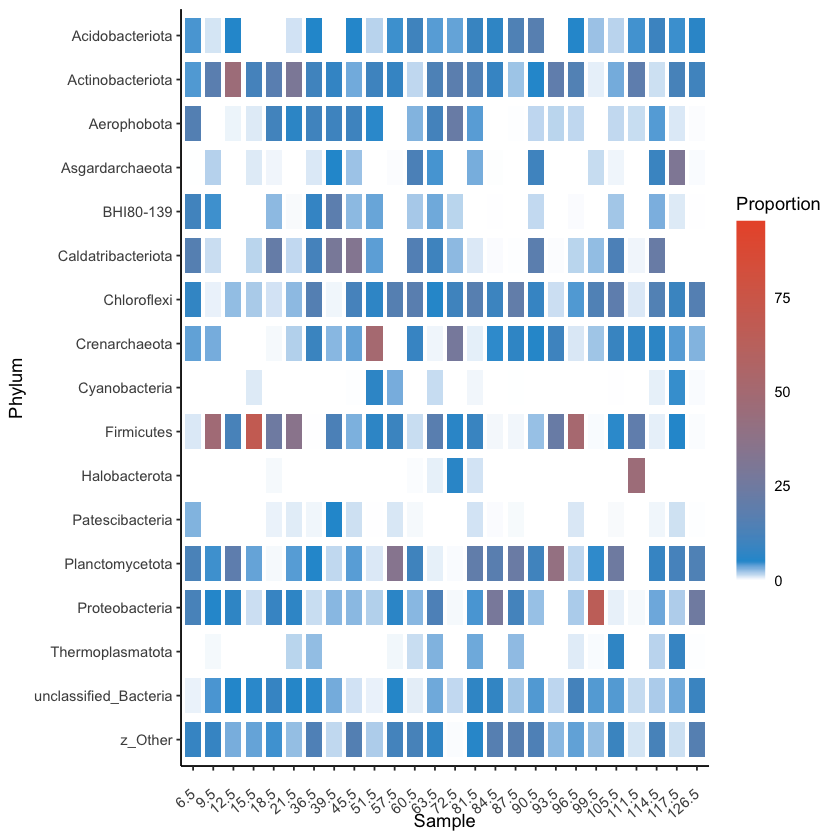

In [551]:
#Phylum
#Filters
gc_02_phylum_unc <- filt_major_taxa_proportions_tab_for_plot_gc02.g2 %>% 
  mutate(Phylum = if_else(Phylum %ni% c('Other'), Phylum, "z_Other"))

#Organize things in plot
gc_02_phylum_unc$Sample <-gsub("^.*_", "", gc_02_phylum_unc$Sample)
gc_02_phylum_unc$Sample <- factor(gc_02_phylum_unc$Sample, levels=unique(gc_02_phylum_unc$Sample)[order(as.numeric(gsub("^.*_","", unique(gc_02_phylum_unc$Sample))))])
gc_02_phylum_unc$Phylum <- with(gc_02_phylum_unc,factor(Phylum,levels = rev(sort(unique(Phylum)))))

#Make plot
ggplot(gc_02_phylum_unc, aes(x=Sample, y = Phylum, fill=Proportion)) + 
  geom_tile(width=0.8, height=0.8) +
  scale_fill_gradientn(
    colors=c("white","#2699D3","#EA5835"),
    values=rescale(c(0,5,95)),
    limits=c(0,95)
  ) +
  guides(fill=guide_colorbar(ticks.colour = NA, barheight = 15)) +
  theme_classic() + theme(axis.text.x = element_text(angle=40, hjust=1, vjust=0.5))

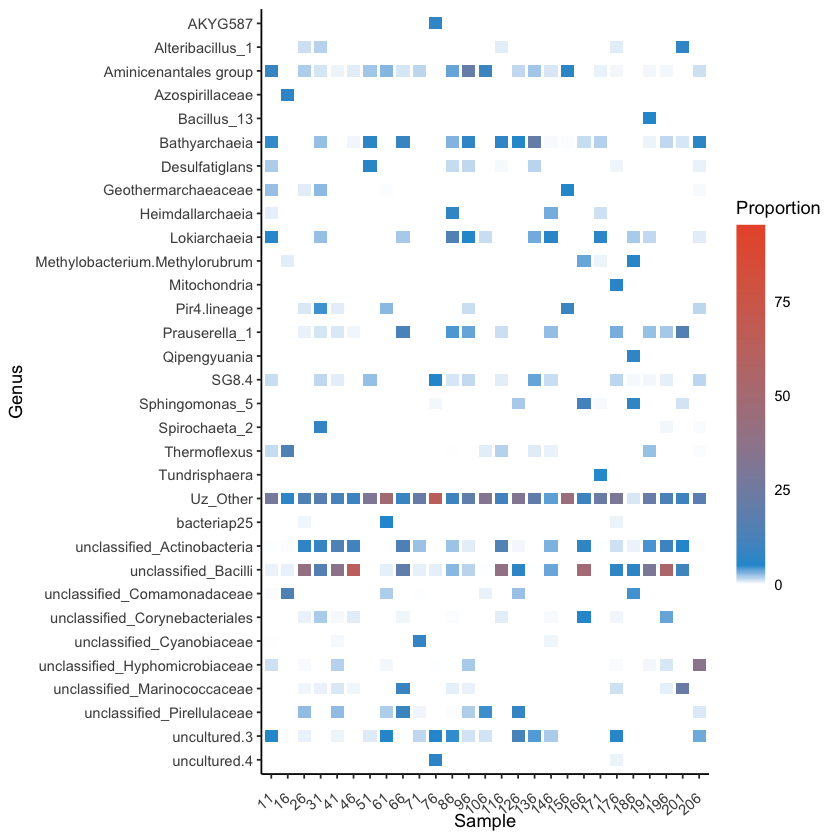

In [552]:
#Plot for GC04
#Genus
#Filters
`%ni%` <- Negate(`%in%`)
gc_04_genus_unc <- filt_major_taxa_proportions_tab_for_plot_g_gc04.g2 %>% 
  mutate(Genus = if_else(Genus %ni% c("uncultured.1",
                                      "uncultured.2",
                                      "uncultured",
                                      "unclassified_Root",
                                      "unclassified_Bacteria") , Genus, "Unclassified"))

gc_04_genus_unc_g1 <- gc_04_genus_unc %>% 
  mutate(Genus = if_else(Genus %ni% c("TA06",
                                      "Azotobacter_5") , Genus, "Other"))

gc_04_genus_unc_g2 <- gc_04_genus_unc_g1 %>% 
  mutate(Genus = if_else(Genus %ni% c("Aminicenantales",
                                      "JS1",
                                      "Aerophobales",
                                      "BHI80.139") , Genus, "Aminicenantales group"))

gc_04_genus_unc_g3 <- gc_04_genus_unc_g2 %>% 
  mutate(Genus = if_else(Genus %ni% c("Other"), Genus, "Uz_Other"))

#Filter unclassifieds out
gc_04_genus_unc_g3 <- gc_04_genus_unc_g3 %>%
  filter(Genus != "Unclassified")

#Organize things in plot
gc_04_genus_unc_g3$Sample <-gsub("^.*_", "", gc_04_genus_unc_g3$Sample)
gc_04_genus_unc_g3$Sample <- factor(gc_04_genus_unc_g3$Sample, levels=unique(gc_04_genus_unc_g3$Sample)[order(as.numeric(gsub("^.*_","", unique(gc_04_genus_unc_g3$Sample))))])
gc_04_genus_unc_g3$Genus <- with(gc_04_genus_unc_g3,factor(Genus,levels = rev(sort(unique(Genus)))))

#Make plot
ggplot(gc_04_genus_unc_g3, aes(x=Sample, y = Genus, fill=Proportion)) + 
  geom_tile(width=0.8, height=0.5) +
  scale_fill_gradientn(
    colors=c("white","#2699D3","#EA5835"),
    values=rescale(c(0,5,95)),
    limits=c(0,95)
  ) +
  guides(fill=guide_colorbar(ticks.colour = NA, barheight = 15)) +
  theme_classic() + theme(axis.text.x = element_text(angle=40, hjust=1, vjust=0.5))

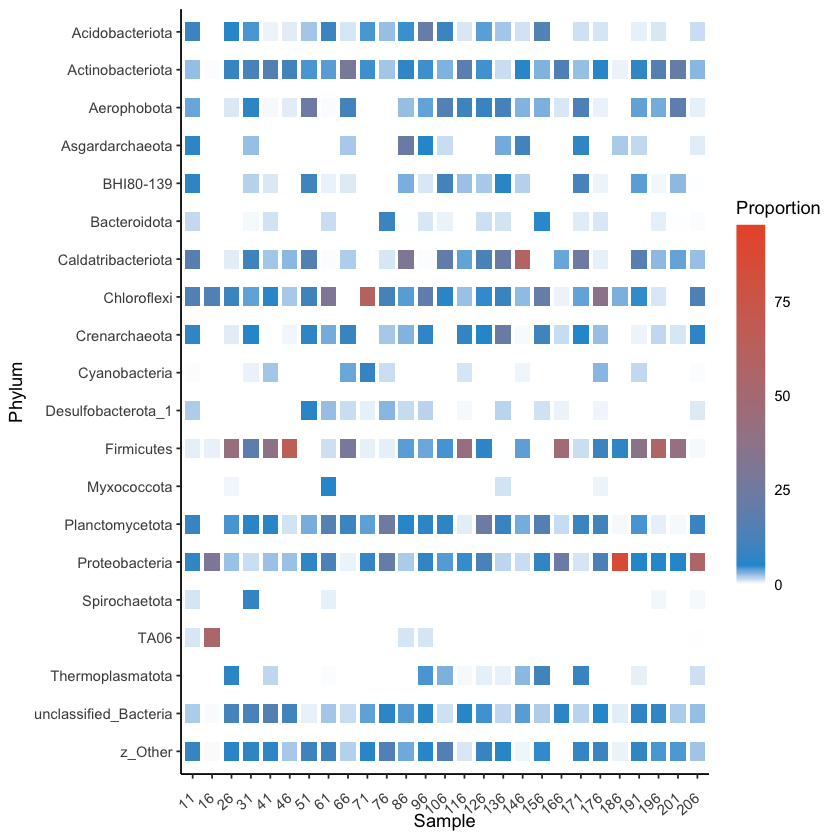

In [553]:
#Phylum
#Filters
`%ni%` <- Negate(`%in%`)
gc_04_phylum_unc <- filt_major_taxa_proportions_tab_for_plot_gc04.g2 %>% 
  mutate(Phylum = if_else(Phylum %ni% c('Other'), Phylum, "z_Other"))

#Organize things in plot
gc_04_phylum_unc$Sample <-gsub("^.*_", "", gc_04_phylum_unc$Sample)
gc_04_phylum_unc$Sample <- factor(gc_04_phylum_unc$Sample, levels=unique(gc_04_phylum_unc$Sample)[order(as.numeric(gsub("^.*_","", unique(gc_04_phylum_unc$Sample))))])
gc_04_phylum_unc$Phylum <- with(gc_04_phylum_unc,factor(Phylum,levels = rev(sort(unique(Phylum)))))

#Make plot
ggplot(gc_04_phylum_unc, aes(x=Sample, y = Phylum, fill=Proportion)) + 
  geom_tile(width=0.8, height=0.5) +
  scale_fill_gradientn(
    colors=c("white","#2699D3","#EA5835"),
    values=rescale(c(0,5,95)),
    limits=c(0,95)
  ) +
  guides(fill=guide_colorbar(ticks.colour = NA, barheight = 15)) +
  theme_classic() + theme(axis.text.x = element_text(angle=40, hjust=1, vjust=0.5))


Making heatplots without filtering phyla with less than 5% representation out.

In [563]:
#Create a copy of the tables for plots
major_taxa_proportions_tab_mc01_for_plot <- data.frame(major_taxa_proportions_tab_mc01)
major_taxa_proportions_tab_gc02_for_plot <- data.frame(major_taxa_proportions_tab_gc02)
major_taxa_proportions_tab_gc04_for_plot <- data.frame(major_taxa_proportions_tab_gc04)
major_taxa_proportions_tab_gc06_for_plot <- data.frame(major_taxa_proportions_tab_gc06)

# and add a column of the taxa names so that it is within the table, rather
# than just as row names (this makes working with ggplot easier)
#For phylum
major_taxa_proportions_tab_mc01_for_plot <- 
  major_taxa_proportions_tab_mc01_for_plot %>% rownames_to_column("Phylum")
major_taxa_proportions_tab_gc02_for_plot <- 
  major_taxa_proportions_tab_gc02_for_plot %>% rownames_to_column("Phylum")
major_taxa_proportions_tab_gc04_for_plot <- 
  major_taxa_proportions_tab_gc04_for_plot %>% rownames_to_column("Phylum")
major_taxa_proportions_tab_gc06_for_plot <- 
  major_taxa_proportions_tab_gc06_for_plot %>% rownames_to_column("Phylum")

# now we'll transform the table into narrow, or long, format (also makes
# plotting easier)
#For phylum
major_taxa_proportions_tab_mc01_for_plot.g <- 
  major_taxa_proportions_tab_mc01_for_plot %>% 
  pivot_longer(!Phylum, names_to = "Sample", values_to = "Proportion") %>% 
  data.frame(check.names = FALSE)
major_taxa_proportions_tab_gc02_for_plot.g <- 
  major_taxa_proportions_tab_gc02_for_plot %>% 
  pivot_longer(!Phylum, names_to = "Sample", values_to = "Proportion") %>% 
  data.frame(check.names = FALSE)
major_taxa_proportions_tab_gc04_for_plot.g <- 
  major_taxa_proportions_tab_gc04_for_plot %>% 
  pivot_longer(!Phylum, names_to = "Sample", values_to = "Proportion") %>% 
  data.frame(check.names = FALSE)
major_taxa_proportions_tab_gc06_for_plot.g <- 
  major_taxa_proportions_tab_gc06_for_plot %>% 
  pivot_longer(!Phylum, names_to = "Sample", values_to = "Proportion") %>% 
  data.frame(check.names = FALSE)

#Add depth and core to tables
major_taxa_proportions_tab_mc01_for_plot.g2 <- 
  major_taxa_proportions_tab_mc01_for_plot.g %>% left_join(mod_sample_info_tab_mc01)
major_taxa_proportions_tab_gc02_for_plot.g2 <- 
  major_taxa_proportions_tab_gc02_for_plot.g %>% left_join(mod_sample_info_tab_gc02)
major_taxa_proportions_tab_gc04_for_plot.g2 <- 
  major_taxa_proportions_tab_gc04_for_plot.g %>% left_join(mod_sample_info_tab_gc04)
major_taxa_proportions_tab_gc06_for_plot.g2 <- 
  major_taxa_proportions_tab_gc06_for_plot.g %>% left_join(mod_sample_info_tab_gc06)


Joining with `by = join_by(Sample)`
Joining with `by = join_by(Sample)`
Joining with `by = join_by(Sample)`
Joining with `by = join_by(Sample)`


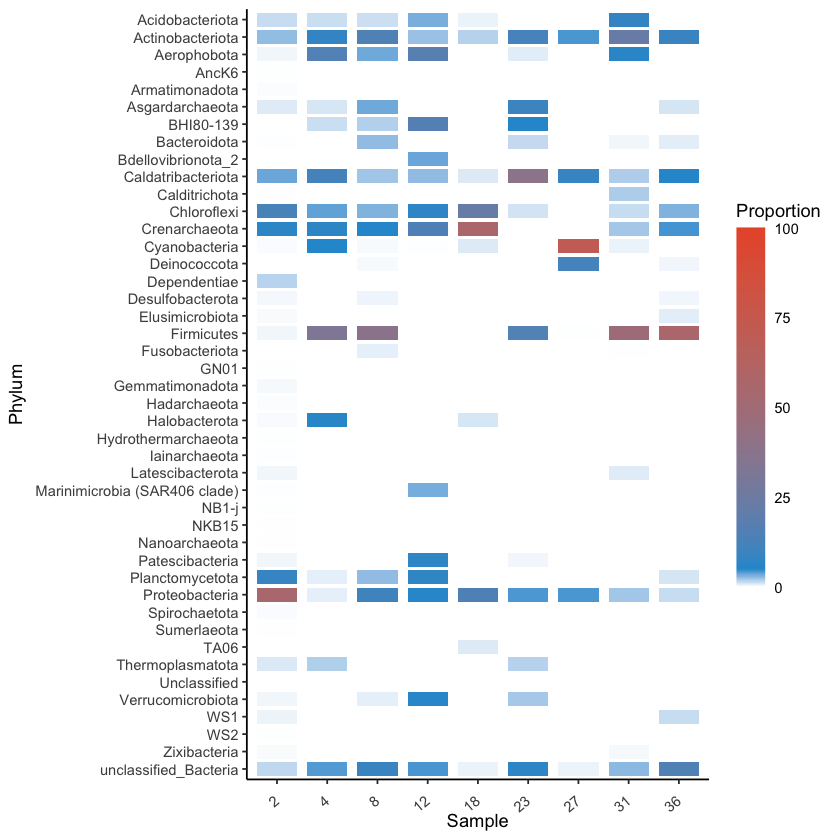

In [564]:
#MC01
#Combine Desulfobacterota
major_taxa_proportions_tab_mc01_for_plot.g2 <- major_taxa_proportions_tab_mc01_for_plot.g2 %>% 
  mutate(Phylum = if_else(Phylum  %ni% c('Desulfobacterota_1','Desulfobacterota_2'), Phylum , "Desulfobacterota"))
#Organize things in plot
major_taxa_proportions_tab_mc01_for_plot.g2$Sample <-gsub("^.*_", "", major_taxa_proportions_tab_mc01_for_plot.g2$Sample)
major_taxa_proportions_tab_mc01_for_plot.g2$Sample <- factor(major_taxa_proportions_tab_mc01_for_plot.g2$Sample, levels=unique(major_taxa_proportions_tab_mc01_for_plot.g2$Sample)[order(as.numeric(gsub("^.*_","", unique(major_taxa_proportions_tab_mc01_for_plot.g2$Sample))))])
major_taxa_proportions_tab_mc01_for_plot.g2$Phylum <- with(major_taxa_proportions_tab_mc01_for_plot.g2,factor(Phylum,levels = rev(sort(unique(Phylum)))))

#Make plot
ggplot(major_taxa_proportions_tab_mc01_for_plot.g2, aes(x=Sample, y = Phylum, fill=Proportion)) + 
  geom_tile(width=0.8, height=0.8) +
  scale_fill_gradientn(
    colors=c("white","#2699D3","#EA5835"),
    values=rescale(c(0,5,100)),
    limits=c(0,100)
  ) +
  guides(fill=guide_colorbar(ticks.colour = NA, barheight = 15)) +
  theme_classic() + theme(axis.text.x = element_text(angle=40, hjust=1, vjust=0.5))


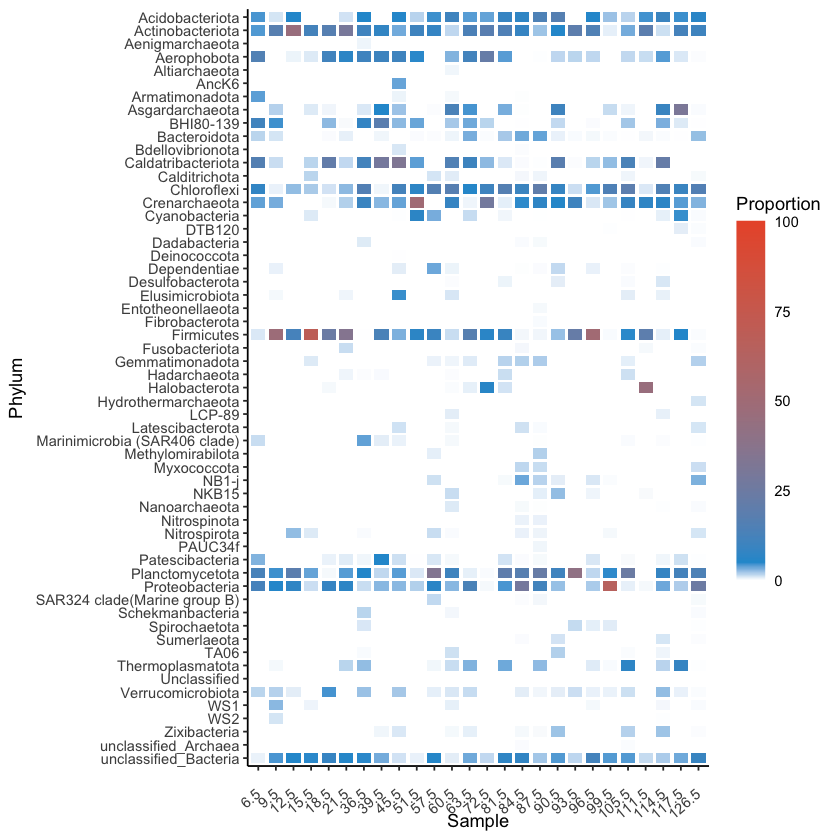

In [567]:
#GC02
#Combine Desulfobacterota
major_taxa_proportions_tab_gc02_for_plot.g2 <- major_taxa_proportions_tab_gc02_for_plot.g2 %>% 
  mutate(Phylum = if_else(Phylum  %ni% c('Desulfobacterota_1','Desulfobacterota_2'), Phylum , "Desulfobacterota"))
#Combine Bdellovibrionota
major_taxa_proportions_tab_gc02_for_plot.g2 <- major_taxa_proportions_tab_gc02_for_plot.g2 %>% 
  mutate(Phylum = if_else(Phylum  %ni% c('Bdellovibrionota_1','Bdellovibrionota_2'), Phylum , "Bdellovibrionota"))
#Organize things in plot
major_taxa_proportions_tab_gc02_for_plot.g2$Sample <-gsub("^.*_", "", major_taxa_proportions_tab_gc02_for_plot.g2$Sample)
major_taxa_proportions_tab_gc02_for_plot.g2$Sample <- factor(major_taxa_proportions_tab_gc02_for_plot.g2$Sample, levels=unique(major_taxa_proportions_tab_gc02_for_plot.g2$Sample)[order(as.numeric(gsub("^.*_","", unique(major_taxa_proportions_tab_gc02_for_plot.g2$Sample))))])
major_taxa_proportions_tab_gc02_for_plot.g2$Phylum <- with(major_taxa_proportions_tab_gc02_for_plot.g2,factor(Phylum,levels = rev(sort(unique(Phylum)))))

#Make plot
ggplot(major_taxa_proportions_tab_gc02_for_plot.g2, aes(x=Sample, y = Phylum, fill=Proportion)) + 
  geom_tile(width=0.8, height=0.8) +
  scale_fill_gradientn(
    colors=c("white","#2699D3","#EA5835"),
    values=rescale(c(0,5,100)),
    limits=c(0,100)
  ) +
  guides(fill=guide_colorbar(ticks.colour = NA, barheight = 15)) +
  theme_classic() + theme(axis.text.x = element_text(angle=40, hjust=1, vjust=0.5))


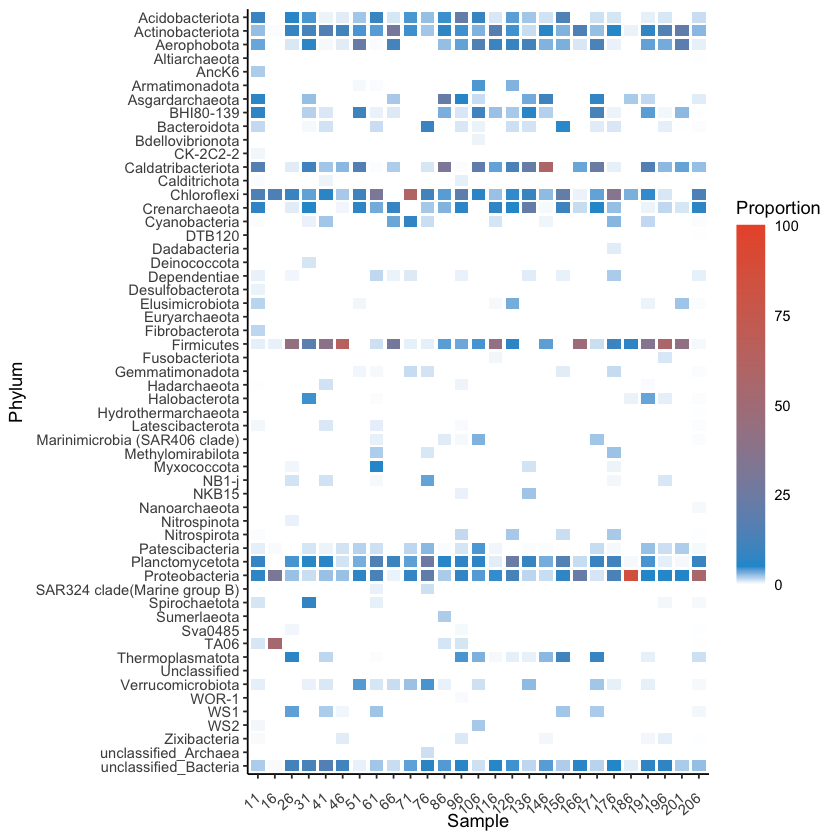

In [568]:
#GC04
#Combine Desulfobacterota
major_taxa_proportions_tab_gc04_for_plot.g2 <- major_taxa_proportions_tab_gc04_for_plot.g2 %>% 
  mutate(Phylum = if_else(Phylum  %ni% c('Desulfobacterota_1','Desulfobacterota_2'), Phylum , "Desulfobacterota"))
#Combine Bdellovibrionota
major_taxa_proportions_tab_gc04_for_plot.g2 <- major_taxa_proportions_tab_gc04_for_plot.g2 %>% 
  mutate(Phylum = if_else(Phylum  %ni% c('Bdellovibrionota_1','Bdellovibrionota_2'), Phylum , "Bdellovibrionota"))
#Organize things in plot
major_taxa_proportions_tab_gc04_for_plot.g2$Sample <-gsub("^.*_", "", major_taxa_proportions_tab_gc04_for_plot.g2$Sample)
major_taxa_proportions_tab_gc04_for_plot.g2$Sample <- factor(major_taxa_proportions_tab_gc04_for_plot.g2$Sample, levels=unique(major_taxa_proportions_tab_gc04_for_plot.g2$Sample)[order(as.numeric(gsub("^.*_","", unique(major_taxa_proportions_tab_gc04_for_plot.g2$Sample))))])
major_taxa_proportions_tab_gc04_for_plot.g2$Phylum <- with(major_taxa_proportions_tab_gc04_for_plot.g2,factor(Phylum,levels = rev(sort(unique(Phylum)))))
#Make plot
ggplot(major_taxa_proportions_tab_gc04_for_plot.g2, aes(x=Sample, y = Phylum, fill=Proportion)) + 
  geom_tile(width=0.8, height=0.8) +
  scale_fill_gradientn(
    colors=c("white","#2699D3","#EA5835"),
    values=rescale(c(0,5,100)),
    limits=c(0,100)
  ) +
  guides(fill=guide_colorbar(ticks.colour = NA, barheight = 15)) +
  theme_classic() + theme(axis.text.x = element_text(angle=40, hjust=1, vjust=0.5))

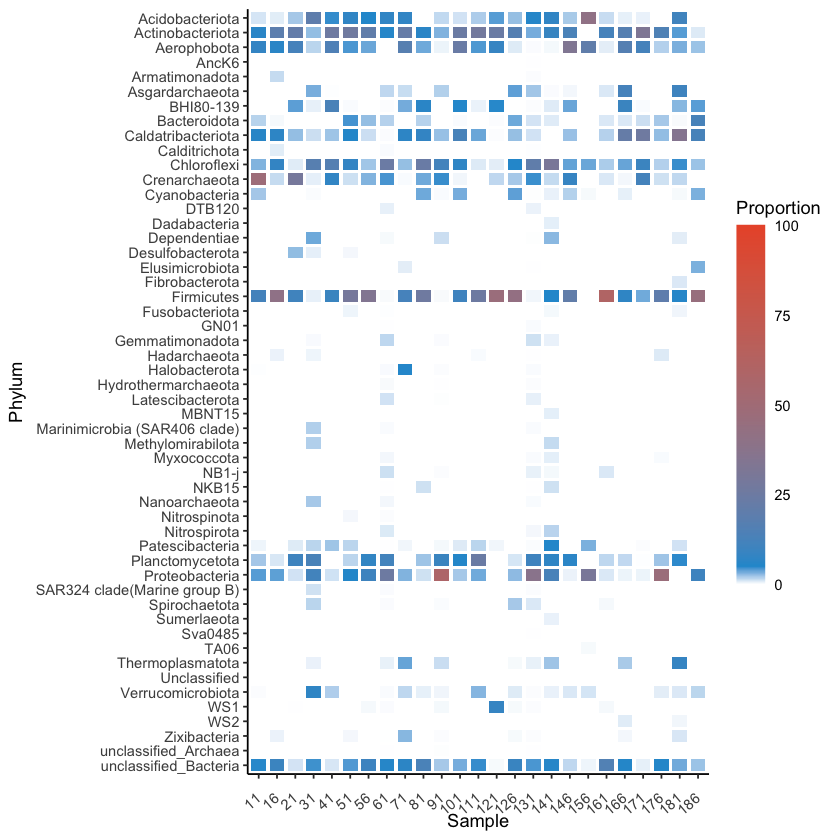

In [569]:
#GC06
#Combine Desulfobacterota
major_taxa_proportions_tab_gc06_for_plot.g2 <- major_taxa_proportions_tab_gc06_for_plot.g2 %>% 
  mutate(Phylum = if_else(Phylum  %ni% c('Desulfobacterota_1','Desulfobacterota_2'), Phylum , "Desulfobacterota"))
#Combine Bdellovibrionota
major_taxa_proportions_tab_gc06_for_plot.g2 <- major_taxa_proportions_tab_gc06_for_plot.g2 %>% 
  mutate(Phylum = if_else(Phylum  %ni% c('Bdellovibrionota_1','Bdellovibrionota_2'), Phylum , "Bdellovibrionota"))
#Organize things in plot
major_taxa_proportions_tab_gc06_for_plot.g2$Sample <-gsub("^.*_", "", major_taxa_proportions_tab_gc06_for_plot.g2$Sample)
major_taxa_proportions_tab_gc06_for_plot.g2$Sample <- factor(major_taxa_proportions_tab_gc06_for_plot.g2$Sample, levels=unique(major_taxa_proportions_tab_gc06_for_plot.g2$Sample)[order(as.numeric(gsub("^.*_","", unique(major_taxa_proportions_tab_gc06_for_plot.g2$Sample))))])
major_taxa_proportions_tab_gc06_for_plot.g2$Phylum <- with(major_taxa_proportions_tab_gc06_for_plot.g2,factor(Phylum,levels = rev(sort(unique(Phylum)))))
#Make plot
ggplot(major_taxa_proportions_tab_gc06_for_plot.g2, aes(x=Sample, y = Phylum, fill=Proportion)) + 
  geom_tile(width=0.8, height=0.8) +
  scale_fill_gradientn(
    colors=c("white","#2699D3","#EA5835"),
    values=rescale(c(0,5,100)),
    limits=c(0,100)
  ) +
  guides(fill=guide_colorbar(ticks.colour = NA, barheight = 15)) +
  theme_classic() + theme(axis.text.x = element_text(angle=40, hjust=1, vjust=0.5))